# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.7566888028890952 -2.8400103298341923
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [19]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
                                                                                       shape=[-1, 1])))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [20]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [21]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [22]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [23]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [24]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [26]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
d_lossR_list, d_lossQ_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ),
)
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model2.ckpt')

Episode:0 meanR:8.0000 gloss:0.0622 dloss:0.7338 dlossR:0.7338 dlossQ:0.6919
Episode:1 meanR:9.0000 gloss:0.0076 dloss:0.6981 dlossR:0.6981 dlossQ:0.6931
Episode:2 meanR:8.6667 gloss:-0.0368 dloss:0.6664 dlossR:0.6664 dlossQ:0.6926
Episode:3 meanR:9.0000 gloss:-0.0850 dloss:0.6303 dlossR:0.6303 dlossQ:0.6902
Episode:4 meanR:9.0000 gloss:-0.1239 dloss:0.6058 dlossR:0.6058 dlossQ:0.6871
Episode:5 meanR:9.1667 gloss:-0.1745 dloss:0.5775 dlossR:0.5775 dlossQ:0.6821
Episode:6 meanR:9.2857 gloss:-0.2292 dloss:0.5522 dlossR:0.5522 dlossQ:0.6760
Episode:7 meanR:10.3750 gloss:-0.1463 dloss:0.6060 dlossR:0.6060 dlossQ:0.6844
Episode:8 meanR:15.3333 gloss:-0.0319 dloss:0.6750 dlossR:0.6750 dlossQ:0.6932
Episode:9 meanR:17.0000 gloss:-0.0338 dloss:0.6710 dlossR:0.6710 dlossQ:0.6932
Episode:10 meanR:18.1818 gloss:-0.0426 dloss:0.6651 dlossR:0.6651 dlossQ:0.6930
Episode:11 meanR:20.0833 gloss:-0.0552 dloss:0.6597 dlossR:0.6597 dlossQ:0.6925
Episode:12 meanR:20.7692 gloss:-0.0472 dloss:0.6617 dlossR:

Episode:103 meanR:50.9200 gloss:-1.2264 dloss:0.3917 dlossR:0.3917 dlossQ:0.4136
Episode:104 meanR:51.4000 gloss:-1.2371 dloss:0.3598 dlossR:0.3598 dlossQ:0.4099
Episode:105 meanR:51.8500 gloss:-1.2324 dloss:0.3527 dlossR:0.3527 dlossQ:0.4116
Episode:106 meanR:52.3500 gloss:-1.2397 dloss:0.3711 dlossR:0.3711 dlossQ:0.4095
Episode:107 meanR:52.3300 gloss:-1.1699 dloss:0.2231 dlossR:0.2231 dlossQ:0.4306
Episode:108 meanR:52.0100 gloss:-1.1784 dloss:0.2451 dlossR:0.2451 dlossQ:0.4273
Episode:109 meanR:51.8600 gloss:-1.1645 dloss:0.2274 dlossR:0.2274 dlossQ:0.4322
Episode:110 meanR:51.7400 gloss:-1.2244 dloss:0.2210 dlossR:0.2210 dlossQ:0.4124
Episode:111 meanR:51.5000 gloss:-1.2596 dloss:0.2121 dlossR:0.2121 dlossQ:0.4005
Episode:112 meanR:51.3600 gloss:-1.3075 dloss:0.1982 dlossR:0.1982 dlossQ:0.3854
Episode:113 meanR:51.3100 gloss:-1.2999 dloss:0.1997 dlossR:0.1997 dlossQ:0.3884
Episode:114 meanR:51.2800 gloss:-1.3398 dloss:0.1944 dlossR:0.1944 dlossQ:0.3759
Episode:115 meanR:51.2600 gl

Episode:214 meanR:35.2000 gloss:-1.6943 dloss:2.5301 dlossR:2.5301 dlossQ:0.2780
Episode:215 meanR:35.8500 gloss:-1.7413 dloss:0.4896 dlossR:0.4896 dlossQ:0.2732
Episode:216 meanR:37.3100 gloss:-1.7021 dloss:0.8747 dlossR:0.8747 dlossQ:0.2771
Episode:217 meanR:38.7800 gloss:-1.6835 dloss:0.8584 dlossR:0.8584 dlossQ:0.2820
Episode:218 meanR:39.8300 gloss:-1.6582 dloss:0.6492 dlossR:0.6492 dlossQ:0.2884
Episode:219 meanR:40.8900 gloss:-1.6410 dloss:0.6407 dlossR:0.6407 dlossQ:0.2931
Episode:220 meanR:41.5200 gloss:-1.5815 dloss:0.4318 dlossR:0.4318 dlossQ:0.3094
Episode:221 meanR:42.0000 gloss:-1.5609 dloss:0.3672 dlossR:0.3672 dlossQ:0.3152
Episode:222 meanR:42.4300 gloss:-1.5710 dloss:0.3873 dlossR:0.3873 dlossQ:0.3142
Episode:223 meanR:42.7600 gloss:-1.4733 dloss:0.2964 dlossR:0.2964 dlossQ:0.3399
Episode:224 meanR:43.1400 gloss:-1.6076 dloss:0.3544 dlossR:0.3544 dlossQ:0.3070
Episode:225 meanR:43.5100 gloss:-1.6736 dloss:0.4377 dlossR:0.4377 dlossQ:0.2936
Episode:226 meanR:43.5400 gl

Episode:321 meanR:100.9200 gloss:-1.1973 dloss:0.2301 dlossR:0.2301 dlossQ:0.4295
Episode:322 meanR:100.6700 gloss:-0.8288 dloss:0.3624 dlossR:0.3624 dlossQ:0.5445
Episode:323 meanR:100.9000 gloss:-1.0118 dloss:0.4140 dlossR:0.4140 dlossQ:0.4867
Episode:324 meanR:100.9100 gloss:-0.8300 dloss:0.4043 dlossR:0.4043 dlossQ:0.5444
Episode:325 meanR:100.6900 gloss:-0.8421 dloss:0.3871 dlossR:0.3871 dlossQ:0.5405
Episode:326 meanR:100.4400 gloss:-1.0390 dloss:0.2883 dlossR:0.2883 dlossQ:0.4792
Episode:327 meanR:100.6900 gloss:-0.8749 dloss:0.4053 dlossR:0.4053 dlossQ:0.5308
Episode:328 meanR:100.6200 gloss:-1.4547 dloss:0.1917 dlossR:0.1917 dlossQ:0.3562
Episode:329 meanR:100.6300 gloss:-1.1233 dloss:0.2711 dlossR:0.2711 dlossQ:0.4537
Episode:330 meanR:100.5400 gloss:-1.4218 dloss:0.1965 dlossR:0.1965 dlossQ:0.3625
Episode:331 meanR:100.5400 gloss:-1.4007 dloss:0.2025 dlossR:0.2025 dlossQ:0.3701
Episode:332 meanR:100.9500 gloss:-0.9228 dloss:0.3916 dlossR:0.3916 dlossQ:0.5156
Episode:333 mean

Episode:422 meanR:54.9200 gloss:-1.3335 dloss:0.2146 dlossR:0.2146 dlossQ:0.3920
Episode:423 meanR:54.4900 gloss:-1.3010 dloss:0.2410 dlossR:0.2410 dlossQ:0.4017
Episode:424 meanR:54.3900 gloss:-1.1768 dloss:0.3298 dlossR:0.3298 dlossQ:0.4352
Episode:425 meanR:55.2600 gloss:-1.1212 dloss:0.6223 dlossR:0.6223 dlossQ:0.4495
Episode:426 meanR:60.0200 gloss:-1.0429 dloss:1.7071 dlossR:1.7071 dlossQ:0.4744
Episode:427 meanR:61.9400 gloss:-1.0327 dloss:0.9546 dlossR:0.9546 dlossQ:0.4791
Episode:428 meanR:63.0300 gloss:-1.0070 dloss:0.5619 dlossR:0.5619 dlossQ:0.4878
Episode:429 meanR:63.8800 gloss:-1.1580 dloss:0.5361 dlossR:0.5361 dlossQ:0.4398
Episode:430 meanR:64.5600 gloss:-1.1929 dloss:0.4473 dlossR:0.4473 dlossQ:0.4301
Episode:431 meanR:65.2200 gloss:-1.2293 dloss:0.4468 dlossR:0.4468 dlossQ:0.4188
Episode:432 meanR:65.4700 gloss:-1.1533 dloss:0.4477 dlossR:0.4477 dlossQ:0.4414
Episode:433 meanR:65.4800 gloss:-1.0978 dloss:0.3469 dlossR:0.3469 dlossQ:0.4574
Episode:434 meanR:65.3000 gl

Episode:532 meanR:70.4900 gloss:-1.4660 dloss:0.1808 dlossR:0.1808 dlossQ:0.3481
Episode:533 meanR:70.2100 gloss:-1.3193 dloss:0.2400 dlossR:0.2400 dlossQ:0.3948
Episode:534 meanR:69.9000 gloss:-1.5975 dloss:0.1635 dlossR:0.1635 dlossQ:0.3135
Episode:535 meanR:69.6300 gloss:-1.5356 dloss:0.1755 dlossR:0.1755 dlossQ:0.3295
Episode:536 meanR:69.6200 gloss:-1.2823 dloss:0.2653 dlossR:0.2653 dlossQ:0.4037
Episode:537 meanR:69.8500 gloss:-1.1940 dloss:0.3680 dlossR:0.3680 dlossQ:0.4337
Episode:538 meanR:69.7000 gloss:-1.5687 dloss:0.1641 dlossR:0.1641 dlossQ:0.3243
Episode:539 meanR:70.3400 gloss:-1.1630 dloss:0.4638 dlossR:0.4638 dlossQ:0.4406
Episode:540 meanR:70.6200 gloss:-1.1383 dloss:0.3725 dlossR:0.3725 dlossQ:0.4488
Episode:541 meanR:72.2300 gloss:-1.0566 dloss:0.7432 dlossR:0.7432 dlossQ:0.4739
Episode:542 meanR:77.0300 gloss:-1.0076 dloss:1.6670 dlossR:1.6670 dlossQ:0.4902
Episode:543 meanR:77.5500 gloss:-1.0597 dloss:0.4295 dlossR:0.4295 dlossQ:0.4718
Episode:544 meanR:78.5600 gl

Episode:633 meanR:147.8000 gloss:-0.5472 dloss:1.1712 dlossR:1.1712 dlossQ:0.6214
Episode:634 meanR:152.6900 gloss:-0.5561 dloss:1.1812 dlossR:1.1812 dlossQ:0.6185
Episode:635 meanR:157.5600 gloss:-0.5413 dloss:1.1654 dlossR:1.1654 dlossQ:0.6222
Episode:636 meanR:162.2600 gloss:-0.4992 dloss:1.1263 dlossR:1.1263 dlossQ:0.6305
Episode:637 meanR:162.6400 gloss:-0.5499 dloss:0.5324 dlossR:0.5324 dlossQ:0.6178
Episode:638 meanR:163.5700 gloss:-0.4280 dloss:0.5641 dlossR:0.5641 dlossQ:0.6462
Episode:639 meanR:163.0700 gloss:-0.5638 dloss:0.4358 dlossR:0.4358 dlossQ:0.6154
Episode:640 meanR:163.3600 gloss:-0.4662 dloss:0.5364 dlossR:0.5364 dlossQ:0.6380
Episode:641 meanR:162.3100 gloss:-0.4357 dloss:0.5271 dlossR:0.5271 dlossQ:0.6442
Episode:642 meanR:157.9600 gloss:-0.4279 dloss:0.5217 dlossR:0.5217 dlossQ:0.6433
Episode:643 meanR:158.0500 gloss:-0.4272 dloss:0.5435 dlossR:0.5435 dlossQ:0.6438
Episode:644 meanR:157.5100 gloss:-0.4395 dloss:0.5168 dlossR:0.5168 dlossQ:0.6458
Episode:645 mean

Episode:733 meanR:90.0500 gloss:-0.7671 dloss:1.3948 dlossR:1.3948 dlossQ:0.5642
Episode:734 meanR:90.0500 gloss:-0.7503 dloss:1.3765 dlossR:1.3765 dlossQ:0.5699
Episode:735 meanR:90.0500 gloss:-0.7337 dloss:1.3589 dlossR:1.3589 dlossQ:0.5747
Episode:736 meanR:90.0500 gloss:-0.7119 dloss:1.3367 dlossR:1.3367 dlossQ:0.5798
Episode:737 meanR:94.1100 gloss:-0.6587 dloss:1.2806 dlossR:1.2806 dlossQ:0.5956
Episode:738 meanR:98.0900 gloss:-0.5632 dloss:1.1825 dlossR:1.1825 dlossQ:0.6217
Episode:739 meanR:102.7300 gloss:-0.5183 dloss:1.1391 dlossR:1.1391 dlossQ:0.6315
Episode:740 meanR:106.8600 gloss:-0.5251 dloss:1.1475 dlossR:1.1475 dlossQ:0.6293
Episode:741 meanR:111.1300 gloss:-0.5100 dloss:1.1342 dlossR:1.1342 dlossQ:0.6338
Episode:742 meanR:115.4800 gloss:-0.5752 dloss:1.1991 dlossR:1.1991 dlossQ:0.6178
Episode:743 meanR:116.4000 gloss:-0.5188 dloss:0.6567 dlossR:0.6567 dlossQ:0.6300
Episode:744 meanR:117.3900 gloss:-0.5790 dloss:0.6544 dlossR:0.6544 dlossQ:0.6142
Episode:745 meanR:118.

Episode:836 meanR:109.6600 gloss:-1.7143 dloss:0.2843 dlossR:0.2843 dlossQ:0.3278
Episode:837 meanR:104.9400 gloss:-1.3448 dloss:0.2608 dlossR:0.2608 dlossQ:0.3932
Episode:838 meanR:100.1300 gloss:-1.5459 dloss:0.2057 dlossR:0.2057 dlossQ:0.3361
Episode:839 meanR:95.3100 gloss:-1.6110 dloss:0.1939 dlossR:0.1939 dlossQ:0.3171
Episode:840 meanR:90.5200 gloss:-1.6147 dloss:0.2099 dlossR:0.2099 dlossQ:0.3183
Episode:841 meanR:85.6700 gloss:-1.8364 dloss:0.1687 dlossR:0.1687 dlossQ:0.2626
Episode:842 meanR:80.8400 gloss:-1.7586 dloss:0.1872 dlossR:0.1872 dlossQ:0.2843
Episode:843 meanR:79.3200 gloss:-1.8213 dloss:0.2070 dlossR:0.2070 dlossQ:0.2691
Episode:844 meanR:77.8900 gloss:-1.7039 dloss:0.2372 dlossR:0.2372 dlossQ:0.3080
Episode:845 meanR:77.9700 gloss:-1.2842 dloss:0.6212 dlossR:0.6212 dlossQ:0.4085
Episode:846 meanR:76.8300 gloss:-1.2319 dloss:0.3122 dlossR:0.3122 dlossQ:0.4258
Episode:847 meanR:76.3900 gloss:-1.1443 dloss:0.2858 dlossR:0.2858 dlossQ:0.4529
Episode:848 meanR:75.5700

Episode:938 meanR:63.6000 gloss:-1.8284 dloss:0.5143 dlossR:0.5143 dlossQ:0.2619
Episode:939 meanR:63.5600 gloss:-1.6171 dloss:0.1668 dlossR:0.1668 dlossQ:0.3115
Episode:940 meanR:63.4900 gloss:-1.6728 dloss:0.1620 dlossR:0.1620 dlossQ:0.2957
Episode:941 meanR:63.5300 gloss:-1.6534 dloss:0.1864 dlossR:0.1864 dlossQ:0.3014
Episode:942 meanR:63.5300 gloss:-1.6818 dloss:0.1756 dlossR:0.1756 dlossQ:0.2937
Episode:943 meanR:63.4600 gloss:-1.7756 dloss:0.1650 dlossR:0.1650 dlossQ:0.2704
Episode:944 meanR:63.3500 gloss:-1.8069 dloss:0.1575 dlossR:0.1575 dlossQ:0.2619
Episode:945 meanR:62.2200 gloss:-1.8374 dloss:0.1467 dlossR:0.1467 dlossQ:0.2550
Episode:946 meanR:61.9200 gloss:-2.6671 dloss:0.1379 dlossR:0.1379 dlossQ:0.1652
Episode:947 meanR:61.7800 gloss:-1.8638 dloss:0.1499 dlossR:0.1499 dlossQ:0.2487
Episode:948 meanR:61.6900 gloss:-1.8392 dloss:0.1416 dlossR:0.1416 dlossQ:0.2566
Episode:949 meanR:61.7200 gloss:-1.9068 dloss:0.1580 dlossR:0.1580 dlossQ:0.2398
Episode:950 meanR:61.6900 gl

Episode:1042 meanR:59.4000 gloss:-1.3199 dloss:0.4134 dlossR:0.4134 dlossQ:0.4038
Episode:1043 meanR:59.5200 gloss:-1.2545 dloss:0.2654 dlossR:0.2654 dlossQ:0.4142
Episode:1044 meanR:59.6600 gloss:-1.3781 dloss:0.2555 dlossR:0.2555 dlossQ:0.3780
Episode:1045 meanR:59.8500 gloss:-1.4278 dloss:0.2643 dlossR:0.2643 dlossQ:0.3650
Episode:1046 meanR:60.1600 gloss:-1.3742 dloss:0.3029 dlossR:0.3029 dlossQ:0.3798
Episode:1047 meanR:60.1500 gloss:-1.5130 dloss:0.1844 dlossR:0.1844 dlossQ:0.3399
Episode:1048 meanR:60.4700 gloss:-1.2994 dloss:0.3163 dlossR:0.3163 dlossQ:0.4031
Episode:1049 meanR:61.0100 gloss:-1.2179 dloss:0.4242 dlossR:0.4242 dlossQ:0.4327
Episode:1050 meanR:62.5100 gloss:-1.0171 dloss:0.7037 dlossR:0.7037 dlossQ:0.4890
Episode:1051 meanR:63.7200 gloss:-1.0311 dloss:0.6252 dlossR:0.6252 dlossQ:0.4859
Episode:1052 meanR:64.7200 gloss:-1.0707 dloss:0.5569 dlossR:0.5569 dlossQ:0.4738
Episode:1053 meanR:65.8800 gloss:-1.0143 dloss:0.6098 dlossR:0.6098 dlossQ:0.4908
Episode:1054 mea

Episode:1143 meanR:113.4800 gloss:-0.5129 dloss:0.4201 dlossR:0.4201 dlossQ:0.6265
Episode:1144 meanR:115.1100 gloss:-0.5694 dloss:0.6873 dlossR:0.6873 dlossQ:0.6133
Episode:1145 meanR:115.1600 gloss:-0.6684 dloss:0.4088 dlossR:0.4088 dlossQ:0.5866
Episode:1146 meanR:116.0400 gloss:-0.5248 dloss:0.5856 dlossR:0.5856 dlossQ:0.6244
Episode:1147 meanR:117.1300 gloss:-0.5602 dloss:0.5743 dlossR:0.5743 dlossQ:0.6157
Episode:1148 meanR:118.0900 gloss:-0.5874 dloss:0.5978 dlossR:0.5978 dlossQ:0.6112
Episode:1149 meanR:119.1900 gloss:-0.5703 dloss:0.6669 dlossR:0.6669 dlossQ:0.6148
Episode:1150 meanR:119.0100 gloss:-0.6076 dloss:0.6096 dlossR:0.6096 dlossQ:0.6067
Episode:1151 meanR:118.5200 gloss:-0.6198 dloss:0.5128 dlossR:0.5128 dlossQ:0.5973
Episode:1152 meanR:118.4300 gloss:-0.6817 dloss:0.5332 dlossR:0.5332 dlossQ:0.5841
Episode:1153 meanR:117.4100 gloss:-0.7975 dloss:0.3617 dlossR:0.3617 dlossQ:0.5521
Episode:1154 meanR:118.2400 gloss:-0.6631 dloss:0.6580 dlossR:0.6580 dlossQ:0.5919
Epis

Episode:1243 meanR:131.3400 gloss:-0.8187 dloss:1.1279 dlossR:1.1279 dlossQ:0.5478
Episode:1244 meanR:129.8900 gloss:-0.9217 dloss:0.3777 dlossR:0.3777 dlossQ:0.5177
Episode:1245 meanR:131.4100 gloss:-0.8755 dloss:0.7391 dlossR:0.7391 dlossQ:0.5294
Episode:1246 meanR:130.6000 gloss:-0.7737 dloss:0.4064 dlossR:0.4064 dlossQ:0.5597
Episode:1247 meanR:130.0200 gloss:-0.6967 dloss:0.4492 dlossR:0.4492 dlossQ:0.5811
Episode:1248 meanR:128.9800 gloss:-0.7723 dloss:0.3802 dlossR:0.3802 dlossQ:0.5570
Episode:1249 meanR:127.4300 gloss:-0.8083 dloss:0.3482 dlossR:0.3482 dlossQ:0.5476
Episode:1250 meanR:126.0900 gloss:-1.2439 dloss:0.2198 dlossR:0.2198 dlossQ:0.4160
Episode:1251 meanR:125.3400 gloss:-1.2170 dloss:0.2269 dlossR:0.2269 dlossQ:0.4246
Episode:1252 meanR:124.5800 gloss:-0.8485 dloss:0.3468 dlossR:0.3468 dlossQ:0.5354
Episode:1253 meanR:125.6100 gloss:-0.5842 dloss:0.5862 dlossR:0.5862 dlossQ:0.6106
Episode:1254 meanR:125.2000 gloss:-0.6191 dloss:0.5790 dlossR:0.5790 dlossQ:0.6022
Epis

Episode:1343 meanR:74.4300 gloss:-1.2029 dloss:0.5086 dlossR:0.5086 dlossQ:0.4273
Episode:1344 meanR:74.8900 gloss:-1.1375 dloss:0.4851 dlossR:0.4851 dlossQ:0.4467
Episode:1345 meanR:73.3900 gloss:-1.2088 dloss:0.3033 dlossR:0.3033 dlossQ:0.4266
Episode:1346 meanR:73.2000 gloss:-1.3196 dloss:0.2536 dlossR:0.2536 dlossQ:0.3935
Episode:1347 meanR:72.8400 gloss:-1.3879 dloss:0.2487 dlossR:0.2487 dlossQ:0.3794
Episode:1348 meanR:72.7600 gloss:-1.3613 dloss:0.2437 dlossR:0.2437 dlossQ:0.3839
Episode:1349 meanR:72.8200 gloss:-1.2975 dloss:0.2759 dlossR:0.2759 dlossQ:0.4096
Episode:1350 meanR:73.7100 gloss:-1.2339 dloss:0.5204 dlossR:0.5204 dlossQ:0.4199
Episode:1351 meanR:73.7300 gloss:-2.0431 dloss:0.1539 dlossR:0.1539 dlossQ:0.2159
Episode:1352 meanR:73.6200 gloss:-1.9621 dloss:0.1672 dlossR:0.1672 dlossQ:0.2327
Episode:1353 meanR:72.3900 gloss:-2.2849 dloss:0.1230 dlossR:0.1230 dlossQ:0.1778
Episode:1354 meanR:71.3000 gloss:-1.9024 dloss:0.2007 dlossR:0.2007 dlossQ:0.2609
Episode:1355 mea

Episode:1443 meanR:42.8800 gloss:-1.8899 dloss:0.1447 dlossR:0.1447 dlossQ:0.2405
Episode:1444 meanR:42.1200 gloss:-1.8565 dloss:0.1662 dlossR:0.1662 dlossQ:0.2480
Episode:1445 meanR:41.8500 gloss:-1.9226 dloss:0.1379 dlossR:0.1379 dlossQ:0.2334
Episode:1446 meanR:41.8700 gloss:-1.6570 dloss:0.2732 dlossR:0.2732 dlossQ:0.3387
Episode:1447 meanR:41.7300 gloss:-1.8896 dloss:0.1516 dlossR:0.1516 dlossQ:0.2434
Episode:1448 meanR:41.6400 gloss:-2.1142 dloss:0.1853 dlossR:0.1853 dlossQ:0.2360
Episode:1449 meanR:41.4200 gloss:-2.3661 dloss:0.1160 dlossR:0.1160 dlossQ:0.1717
Episode:1450 meanR:40.5900 gloss:-1.7160 dloss:0.1982 dlossR:0.1982 dlossQ:0.3082
Episode:1451 meanR:40.7200 gloss:-1.5120 dloss:0.2458 dlossR:0.2458 dlossQ:0.3508
Episode:1452 meanR:40.8900 gloss:-1.4714 dloss:0.2709 dlossR:0.2709 dlossQ:0.3582
Episode:1453 meanR:41.1500 gloss:-1.4527 dloss:0.2746 dlossR:0.2746 dlossQ:0.3557
Episode:1454 meanR:41.3700 gloss:-1.3976 dloss:0.3027 dlossR:0.3027 dlossQ:0.3678
Episode:1455 mea

Episode:1543 meanR:66.4200 gloss:-1.2571 dloss:0.5239 dlossR:0.5239 dlossQ:0.4151
Episode:1544 meanR:66.3400 gloss:-1.9891 dloss:0.1345 dlossR:0.1345 dlossQ:0.2329
Episode:1545 meanR:67.7900 gloss:-1.3845 dloss:0.7640 dlossR:0.7640 dlossQ:0.3748
Episode:1546 meanR:67.9100 gloss:-1.2277 dloss:0.3386 dlossR:0.3386 dlossQ:0.4363
Episode:1547 meanR:67.8800 gloss:-2.1057 dloss:0.1332 dlossR:0.1332 dlossQ:0.2035
Episode:1548 meanR:68.5600 gloss:-1.1428 dloss:0.4799 dlossR:0.4799 dlossQ:0.4570
Episode:1549 meanR:73.4700 gloss:-1.2300 dloss:1.9372 dlossR:1.9372 dlossQ:0.4187
Episode:1550 meanR:74.9700 gloss:-0.9457 dloss:0.7001 dlossR:0.7001 dlossQ:0.5020
Episode:1551 meanR:75.9600 gloss:-0.7923 dloss:0.5851 dlossR:0.5851 dlossQ:0.5447
Episode:1552 meanR:76.3000 gloss:-1.0625 dloss:0.4070 dlossR:0.4070 dlossQ:0.4701
Episode:1553 meanR:76.4900 gloss:-1.0790 dloss:0.3660 dlossR:0.3660 dlossQ:0.4653
Episode:1554 meanR:76.3200 gloss:-1.2083 dloss:0.2578 dlossR:0.2578 dlossQ:0.4248
Episode:1555 mea

Episode:1643 meanR:190.9000 gloss:-0.0777 dloss:0.6671 dlossR:0.6671 dlossQ:0.6793
Episode:1644 meanR:191.3500 gloss:-0.0746 dloss:0.6691 dlossR:0.6691 dlossQ:0.6781
Episode:1645 meanR:190.1700 gloss:-0.1086 dloss:0.6464 dlossR:0.6464 dlossQ:0.6783
Episode:1646 meanR:190.0800 gloss:-0.1227 dloss:0.6357 dlossR:0.6357 dlossQ:0.6785
Episode:1647 meanR:190.2600 gloss:-0.1151 dloss:0.6382 dlossR:0.6382 dlossQ:0.6793
Episode:1648 meanR:189.6800 gloss:-0.0932 dloss:0.6497 dlossR:0.6497 dlossQ:0.6808
Episode:1649 meanR:184.8400 gloss:0.1540 dloss:0.7994 dlossR:0.7994 dlossQ:0.6867
Episode:1650 meanR:183.3000 gloss:0.0243 dloss:0.7102 dlossR:0.7102 dlossQ:0.6926
Episode:1651 meanR:182.1700 gloss:0.0272 dloss:0.7102 dlossR:0.7102 dlossQ:0.6927
Episode:1652 meanR:181.6100 gloss:-0.0684 dloss:0.6493 dlossR:0.6493 dlossQ:0.6915
Episode:1653 meanR:181.1600 gloss:-0.0850 dloss:0.6396 dlossR:0.6396 dlossQ:0.6909
Episode:1654 meanR:181.0300 gloss:-0.0753 dloss:0.6455 dlossR:0.6455 dlossQ:0.6911
Episode

Episode:1750 meanR:67.2300 gloss:-1.1969 dloss:0.4017 dlossR:0.4017 dlossQ:0.4333
Episode:1751 meanR:68.2100 gloss:-1.1502 dloss:0.5574 dlossR:0.5574 dlossQ:0.4443
Episode:1752 meanR:73.0900 gloss:-0.9490 dloss:1.5972 dlossR:1.5972 dlossQ:0.5080
Episode:1753 meanR:75.1000 gloss:-0.6714 dloss:0.7379 dlossR:0.7379 dlossQ:0.5870
Episode:1754 meanR:76.3000 gloss:-0.6720 dloss:0.5866 dlossR:0.5866 dlossQ:0.5862
Episode:1755 meanR:78.1700 gloss:-0.8766 dloss:0.7688 dlossR:0.7688 dlossQ:0.5252
Episode:1756 meanR:78.9700 gloss:-0.6988 dloss:0.4991 dlossR:0.4991 dlossQ:0.5825
Episode:1757 meanR:79.9200 gloss:-0.7420 dloss:0.5236 dlossR:0.5236 dlossQ:0.5704
Episode:1758 meanR:80.4900 gloss:-0.6845 dloss:0.4513 dlossR:0.4513 dlossQ:0.5887
Episode:1759 meanR:81.1700 gloss:-0.7935 dloss:0.4608 dlossR:0.4608 dlossQ:0.5554
Episode:1760 meanR:81.6700 gloss:-0.7716 dloss:0.4294 dlossR:0.4294 dlossQ:0.5654
Episode:1761 meanR:81.9600 gloss:-0.8900 dloss:0.3658 dlossR:0.3658 dlossQ:0.5299
Episode:1762 mea

Episode:1855 meanR:61.6300 gloss:-1.1801 dloss:0.2727 dlossR:0.2727 dlossQ:0.4360
Episode:1856 meanR:60.9600 gloss:-1.1773 dloss:0.2598 dlossR:0.2598 dlossQ:0.4366
Episode:1857 meanR:60.1700 gloss:-1.2383 dloss:0.2571 dlossR:0.2571 dlossQ:0.4178
Episode:1858 meanR:59.8200 gloss:-1.1605 dloss:0.2880 dlossR:0.2880 dlossQ:0.4417
Episode:1859 meanR:59.3000 gloss:-1.2046 dloss:0.2681 dlossR:0.2681 dlossQ:0.4298
Episode:1860 meanR:58.9500 gloss:-1.1683 dloss:0.2803 dlossR:0.2803 dlossQ:0.4409
Episode:1861 meanR:59.1000 gloss:-1.0410 dloss:0.3937 dlossR:0.3937 dlossQ:0.4787
Episode:1862 meanR:63.7100 gloss:-1.1231 dloss:1.8029 dlossR:1.8029 dlossQ:0.4493
Episode:1863 meanR:64.6600 gloss:-1.0665 dloss:0.6131 dlossR:0.6131 dlossQ:0.4717
Episode:1864 meanR:64.8800 gloss:-1.1666 dloss:0.3679 dlossR:0.3679 dlossQ:0.4421
Episode:1865 meanR:64.9300 gloss:-1.0994 dloss:0.3472 dlossR:0.3472 dlossQ:0.4706
Episode:1866 meanR:65.0300 gloss:-1.1602 dloss:0.3262 dlossR:0.3262 dlossQ:0.4501
Episode:1867 mea

Episode:1956 meanR:97.4900 gloss:-0.8224 dloss:1.4548 dlossR:1.4548 dlossQ:0.5462
Episode:1957 meanR:100.9300 gloss:-0.7098 dloss:1.0703 dlossR:1.0703 dlossQ:0.5796
Episode:1958 meanR:101.6200 gloss:-0.8092 dloss:0.5157 dlossR:0.5157 dlossQ:0.5528
Episode:1959 meanR:102.2500 gloss:-0.9844 dloss:0.4799 dlossR:0.4799 dlossQ:0.5000
Episode:1960 meanR:102.2700 gloss:-1.1292 dloss:0.3053 dlossR:0.3053 dlossQ:0.4649
Episode:1961 meanR:102.0300 gloss:-1.0538 dloss:0.3379 dlossR:0.3379 dlossQ:0.4884
Episode:1962 meanR:98.3300 gloss:-0.8469 dloss:0.5844 dlossR:0.5844 dlossQ:0.5422
Episode:1963 meanR:102.0000 gloss:-0.7060 dloss:1.3320 dlossR:1.3320 dlossQ:0.5816
Episode:1964 meanR:106.4400 gloss:-0.7705 dloss:1.3970 dlossR:1.3970 dlossQ:0.5621
Episode:1965 meanR:110.8800 gloss:-0.7259 dloss:1.3263 dlossR:1.3263 dlossQ:0.5747
Episode:1966 meanR:111.2400 gloss:-0.8478 dloss:0.4544 dlossR:0.4544 dlossQ:0.5388
Episode:1967 meanR:111.4700 gloss:-0.8390 dloss:0.4196 dlossR:0.4196 dlossQ:0.5431
Episod

Episode:2055 meanR:261.8100 gloss:-0.0554 dloss:0.6964 dlossR:0.6964 dlossQ:0.6920
Episode:2056 meanR:260.5900 gloss:-0.0357 dloss:0.7077 dlossR:0.7077 dlossQ:0.6921
Episode:2057 meanR:258.7800 gloss:-0.0594 dloss:0.6862 dlossR:0.6862 dlossQ:0.6903
Episode:2058 meanR:259.5800 gloss:-0.0644 dloss:0.6842 dlossR:0.6842 dlossQ:0.6902
Episode:2059 meanR:259.8900 gloss:-0.0514 dloss:0.6769 dlossR:0.6769 dlossQ:0.6912
Episode:2060 meanR:261.1900 gloss:-0.0548 dloss:0.6823 dlossR:0.6823 dlossQ:0.6906
Episode:2061 meanR:262.9900 gloss:-0.0484 dloss:0.6919 dlossR:0.6919 dlossQ:0.6905
Episode:2062 meanR:263.1300 gloss:-0.0366 dloss:0.6842 dlossR:0.6842 dlossQ:0.6916
Episode:2063 meanR:259.7400 gloss:-0.0471 dloss:0.6837 dlossR:0.6837 dlossQ:0.6914
Episode:2064 meanR:255.7800 gloss:-0.0695 dloss:0.6680 dlossR:0.6680 dlossQ:0.6902
Episode:2065 meanR:251.0600 gloss:-0.2648 dloss:0.5559 dlossR:0.5559 dlossQ:0.6686
Episode:2066 meanR:252.2000 gloss:-0.0519 dloss:0.6874 dlossR:0.6874 dlossQ:0.6907
Epis

Episode:2156 meanR:132.3500 gloss:-0.5772 dloss:0.5289 dlossR:0.5289 dlossQ:0.6119
Episode:2157 meanR:130.9200 gloss:-0.5536 dloss:0.4602 dlossR:0.4602 dlossQ:0.6178
Episode:2158 meanR:129.5800 gloss:-0.6924 dloss:0.4235 dlossR:0.4235 dlossQ:0.5819
Episode:2159 meanR:128.6000 gloss:-0.6935 dloss:0.4020 dlossR:0.4020 dlossQ:0.5822
Episode:2160 meanR:127.2900 gloss:-0.7338 dloss:0.3996 dlossR:0.3996 dlossQ:0.5679
Episode:2161 meanR:127.2800 gloss:-0.4038 dloss:0.7057 dlossR:0.7057 dlossQ:0.6496
Episode:2162 meanR:126.2100 gloss:-0.8765 dloss:0.3681 dlossR:0.3681 dlossQ:0.5280
Episode:2163 meanR:124.8500 gloss:-0.9738 dloss:0.3273 dlossR:0.3273 dlossQ:0.5051
Episode:2164 meanR:124.2900 gloss:-0.7583 dloss:0.4356 dlossR:0.4356 dlossQ:0.5682
Episode:2165 meanR:125.0200 gloss:-0.6364 dloss:0.5227 dlossR:0.5227 dlossQ:0.5987
Episode:2166 meanR:128.1100 gloss:-0.3608 dloss:0.9891 dlossR:0.9891 dlossQ:0.6624
Episode:2167 meanR:128.6800 gloss:-0.4262 dloss:0.7850 dlossR:0.7850 dlossQ:0.6466
Epis

Episode:2255 meanR:119.7300 gloss:-0.9809 dloss:1.6378 dlossR:1.6378 dlossQ:0.5054
Episode:2256 meanR:118.9600 gloss:-1.9348 dloss:0.1745 dlossR:0.1745 dlossQ:0.2502
Episode:2257 meanR:118.7400 gloss:-1.4167 dloss:0.2564 dlossR:0.2564 dlossQ:0.3870
Episode:2258 meanR:118.4100 gloss:-1.6592 dloss:0.1785 dlossR:0.1785 dlossQ:0.3049
Episode:2259 meanR:118.3100 gloss:-1.7702 dloss:0.1739 dlossR:0.1739 dlossQ:0.2800
Episode:2260 meanR:118.2600 gloss:-1.5149 dloss:0.2511 dlossR:0.2511 dlossQ:0.3616
Episode:2261 meanR:116.2200 gloss:-1.6910 dloss:0.1663 dlossR:0.1663 dlossQ:0.2933
Episode:2262 meanR:115.9700 gloss:-1.9541 dloss:0.1660 dlossR:0.1660 dlossQ:0.2476
Episode:2263 meanR:115.8100 gloss:-2.2056 dloss:0.1499 dlossR:0.1499 dlossQ:0.2175
Episode:2264 meanR:115.4300 gloss:-2.0374 dloss:0.1598 dlossR:0.1598 dlossQ:0.2406
Episode:2265 meanR:114.8000 gloss:-1.3405 dloss:0.2835 dlossR:0.2835 dlossQ:0.4176
Episode:2266 meanR:110.4500 gloss:-1.1037 dloss:0.4104 dlossR:0.4104 dlossQ:0.4652
Epis

Episode:2363 meanR:52.8000 gloss:-1.3687 dloss:0.2984 dlossR:0.2984 dlossQ:0.3975
Episode:2364 meanR:53.0700 gloss:-1.3683 dloss:0.2966 dlossR:0.2966 dlossQ:0.3902
Episode:2365 meanR:54.8600 gloss:-1.1292 dloss:0.8554 dlossR:0.8554 dlossQ:0.4542
Episode:2366 meanR:54.5900 gloss:-1.5507 dloss:0.2917 dlossR:0.2917 dlossQ:0.3457
Episode:2367 meanR:52.9000 gloss:-1.6460 dloss:0.2647 dlossR:0.2647 dlossQ:0.3206
Episode:2368 meanR:52.5400 gloss:-1.7237 dloss:0.2270 dlossR:0.2270 dlossQ:0.3048
Episode:2369 meanR:52.6900 gloss:-1.6049 dloss:0.2789 dlossR:0.2789 dlossQ:0.3272
Episode:2370 meanR:52.9000 gloss:-1.4129 dloss:0.3558 dlossR:0.3558 dlossQ:0.3779
Episode:2371 meanR:53.1500 gloss:-1.3010 dloss:0.3554 dlossR:0.3554 dlossQ:0.4098
Episode:2372 meanR:54.9000 gloss:-1.0126 dloss:0.7898 dlossR:0.7898 dlossQ:0.4918
Episode:2373 meanR:54.9700 gloss:-1.5486 dloss:0.2760 dlossR:0.2760 dlossQ:0.3666
Episode:2374 meanR:55.2500 gloss:-1.2579 dloss:0.3871 dlossR:0.3871 dlossQ:0.4350
Episode:2375 mea

Episode:2463 meanR:123.4300 gloss:-0.4181 dloss:0.7778 dlossR:0.7778 dlossQ:0.6507
Episode:2464 meanR:128.0600 gloss:-0.3512 dloss:0.9813 dlossR:0.9813 dlossQ:0.6641
Episode:2465 meanR:130.6900 gloss:-0.7581 dloss:1.3243 dlossR:1.3243 dlossQ:0.5621
Episode:2466 meanR:132.0500 gloss:-0.6544 dloss:0.6687 dlossR:0.6687 dlossQ:0.5922
Episode:2467 meanR:132.5200 gloss:-0.6361 dloss:0.5007 dlossR:0.5007 dlossQ:0.5957
Episode:2468 meanR:132.6500 gloss:-0.8259 dloss:0.3808 dlossR:0.3808 dlossQ:0.5431
Episode:2469 meanR:132.6600 gloss:-0.8067 dloss:0.3836 dlossR:0.3836 dlossQ:0.5483
Episode:2470 meanR:132.6800 gloss:-0.6944 dloss:0.4503 dlossR:0.4503 dlossQ:0.5771
Episode:2471 meanR:133.0100 gloss:-0.5769 dloss:0.5227 dlossR:0.5227 dlossQ:0.6091
Episode:2472 meanR:131.9500 gloss:-0.6659 dloss:0.5169 dlossR:0.5169 dlossQ:0.5877
Episode:2473 meanR:132.9200 gloss:-0.6041 dloss:0.5922 dlossR:0.5922 dlossQ:0.6038
Episode:2474 meanR:133.9400 gloss:-0.5372 dloss:0.6340 dlossR:0.6340 dlossQ:0.6254
Epis

Episode:2565 meanR:135.1300 gloss:-0.6656 dloss:0.5673 dlossR:0.5673 dlossQ:0.5892
Episode:2566 meanR:134.5100 gloss:-0.7693 dloss:0.5528 dlossR:0.5528 dlossQ:0.5590
Episode:2567 meanR:135.0500 gloss:-0.6979 dloss:0.5963 dlossR:0.5963 dlossQ:0.5807
Episode:2568 meanR:136.4800 gloss:-0.7597 dloss:0.6998 dlossR:0.6998 dlossQ:0.5644
Episode:2569 meanR:140.8200 gloss:-0.5147 dloss:1.0989 dlossR:1.0989 dlossQ:0.6280
Episode:2570 meanR:141.5100 gloss:-0.6853 dloss:0.5748 dlossR:0.5748 dlossQ:0.5868
Episode:2571 meanR:142.1500 gloss:-0.7374 dloss:0.6272 dlossR:0.6272 dlossQ:0.5722
Episode:2572 meanR:146.2500 gloss:-0.2429 dloss:0.8855 dlossR:0.8855 dlossQ:0.6795
Episode:2573 meanR:147.7900 gloss:-0.6504 dloss:0.8750 dlossR:0.8750 dlossQ:0.5937
Episode:2574 meanR:147.5900 gloss:-0.7643 dloss:0.6107 dlossR:0.6107 dlossQ:0.5639
Episode:2575 meanR:143.0100 gloss:-0.8804 dloss:0.3894 dlossR:0.3894 dlossQ:0.5315
Episode:2576 meanR:147.4800 gloss:-0.5628 dloss:1.1300 dlossR:1.1300 dlossQ:0.6205
Epis

Episode:2666 meanR:94.1800 gloss:-1.5803 dloss:0.2476 dlossR:0.2476 dlossQ:0.3388
Episode:2667 meanR:93.0600 gloss:-1.6905 dloss:0.2126 dlossR:0.2126 dlossQ:0.3076
Episode:2668 meanR:91.5500 gloss:-1.5263 dloss:0.2600 dlossR:0.2600 dlossQ:0.3544
Episode:2669 meanR:87.0800 gloss:-1.7276 dloss:0.2202 dlossR:0.2202 dlossQ:0.3003
Episode:2670 meanR:86.0500 gloss:-1.7903 dloss:0.1965 dlossR:0.1965 dlossQ:0.2777
Episode:2671 meanR:84.8800 gloss:-1.5982 dloss:0.2619 dlossR:0.2619 dlossQ:0.3320
Episode:2672 meanR:80.3800 gloss:-1.3851 dloss:0.3448 dlossR:0.3448 dlossQ:0.3895
Episode:2673 meanR:78.6100 gloss:-1.0131 dloss:0.5173 dlossR:0.5173 dlossQ:0.4888
Episode:2674 meanR:79.2200 gloss:-1.0873 dloss:0.8254 dlossR:0.8254 dlossQ:0.4656
Episode:2675 meanR:79.2000 gloss:-1.5157 dloss:0.3052 dlossR:0.3052 dlossQ:0.3571
Episode:2676 meanR:74.8600 gloss:-1.6812 dloss:0.2515 dlossR:0.2515 dlossQ:0.3125
Episode:2677 meanR:70.2500 gloss:-1.5360 dloss:0.2997 dlossR:0.2997 dlossQ:0.3558
Episode:2678 mea

Episode:2770 meanR:69.6600 gloss:-0.9865 dloss:0.4085 dlossR:0.4085 dlossQ:0.4949
Episode:2771 meanR:70.1900 gloss:-0.9161 dloss:0.4734 dlossR:0.4734 dlossQ:0.5166
Episode:2772 meanR:70.5600 gloss:-0.8625 dloss:0.4801 dlossR:0.4801 dlossQ:0.5322
Episode:2773 meanR:70.4900 gloss:-0.8755 dloss:0.5120 dlossR:0.5120 dlossQ:0.5278
Episode:2774 meanR:69.4700 gloss:-0.8705 dloss:0.5124 dlossR:0.5124 dlossQ:0.5297
Episode:2775 meanR:70.5300 gloss:-0.8307 dloss:0.6273 dlossR:0.6273 dlossQ:0.5427
Episode:2776 meanR:71.5900 gloss:-0.7820 dloss:0.5983 dlossR:0.5983 dlossQ:0.5579
Episode:2777 meanR:73.0200 gloss:-0.7967 dloss:0.7089 dlossR:0.7089 dlossQ:0.5558
Episode:2778 meanR:74.2200 gloss:-0.7201 dloss:0.6211 dlossR:0.6211 dlossQ:0.5749
Episode:2779 meanR:75.8100 gloss:-0.7118 dloss:0.7716 dlossR:0.7716 dlossQ:0.5787
Episode:2780 meanR:79.6200 gloss:-0.5800 dloss:1.2022 dlossR:1.2022 dlossQ:0.6159
Episode:2781 meanR:81.9700 gloss:-0.5942 dloss:0.8469 dlossR:0.8469 dlossQ:0.6100
Episode:2782 mea

Episode:2870 meanR:242.8300 gloss:-0.3232 dloss:0.5963 dlossR:0.5963 dlossQ:0.6631
Episode:2871 meanR:243.3300 gloss:-0.2943 dloss:0.6227 dlossR:0.6227 dlossQ:0.6674
Episode:2872 meanR:243.8000 gloss:-0.3164 dloss:0.6184 dlossR:0.6184 dlossQ:0.6637
Episode:2873 meanR:246.2500 gloss:-0.2518 dloss:0.7786 dlossR:0.7786 dlossQ:0.6757
Episode:2874 meanR:248.4600 gloss:-0.2723 dloss:0.7690 dlossR:0.7690 dlossQ:0.6720
Episode:2875 meanR:250.0500 gloss:-0.2776 dloss:0.7589 dlossR:0.7589 dlossQ:0.6719
Episode:2876 meanR:250.1300 gloss:-0.3420 dloss:0.6242 dlossR:0.6242 dlossQ:0.6594
Episode:2877 meanR:250.6300 gloss:-0.2647 dloss:0.7015 dlossR:0.7015 dlossQ:0.6720
Episode:2878 meanR:251.6500 gloss:-0.3026 dloss:0.7205 dlossR:0.7205 dlossQ:0.6673
Episode:2879 meanR:251.6200 gloss:-0.2746 dloss:0.6929 dlossR:0.6929 dlossQ:0.6706
Episode:2880 meanR:249.3900 gloss:-0.2633 dloss:0.7351 dlossR:0.7351 dlossQ:0.6725
Episode:2881 meanR:251.0400 gloss:-0.2304 dloss:0.8403 dlossR:0.8403 dlossQ:0.6780
Epis

Episode:2969 meanR:243.4200 gloss:-0.1080 dloss:0.6758 dlossR:0.6758 dlossQ:0.6898
Episode:2970 meanR:244.3200 gloss:-0.1095 dloss:0.6815 dlossR:0.6815 dlossQ:0.6898
Episode:2971 meanR:246.4600 gloss:-0.0946 dloss:0.7228 dlossR:0.7228 dlossQ:0.6906
Episode:2972 meanR:248.5100 gloss:-0.0970 dloss:0.7208 dlossR:0.7208 dlossQ:0.6906
Episode:2973 meanR:246.9700 gloss:-0.1075 dloss:0.6776 dlossR:0.6776 dlossQ:0.6899
Episode:2974 meanR:246.1000 gloss:-0.1054 dloss:0.6909 dlossR:0.6909 dlossQ:0.6900
Episode:2975 meanR:246.1900 gloss:-0.0978 dloss:0.7141 dlossR:0.7141 dlossQ:0.6904
Episode:2976 meanR:246.8200 gloss:-0.1067 dloss:0.6833 dlossR:0.6833 dlossQ:0.6899
Episode:2977 meanR:246.3600 gloss:-0.1108 dloss:0.6764 dlossR:0.6764 dlossQ:0.6896
Episode:2978 meanR:246.1100 gloss:-0.1057 dloss:0.6891 dlossR:0.6891 dlossQ:0.6899
Episode:2979 meanR:246.2200 gloss:-0.1013 dloss:0.6906 dlossR:0.6906 dlossQ:0.6903
Episode:2980 meanR:245.8800 gloss:-0.1048 dloss:0.6945 dlossR:0.6945 dlossQ:0.6899
Epis

Episode:3069 meanR:171.7000 gloss:-0.7215 dloss:0.3938 dlossR:0.3938 dlossQ:0.5768
Episode:3070 meanR:169.7800 gloss:-1.3483 dloss:0.2492 dlossR:0.2492 dlossQ:0.3968
Episode:3071 meanR:171.2900 gloss:-0.4874 dloss:1.1093 dlossR:1.1093 dlossQ:0.6413
Episode:3072 meanR:167.9900 gloss:-1.5776 dloss:0.2031 dlossR:0.2031 dlossQ:0.3363
Episode:3073 meanR:166.2200 gloss:-1.6127 dloss:0.2090 dlossR:0.2090 dlossQ:0.3319
Episode:3074 meanR:165.0700 gloss:-0.5369 dloss:0.5752 dlossR:0.5752 dlossQ:0.6223
Episode:3075 meanR:163.2400 gloss:-0.4782 dloss:0.5997 dlossR:0.5997 dlossQ:0.6366
Episode:3076 meanR:161.9000 gloss:-0.6167 dloss:0.4900 dlossR:0.4900 dlossQ:0.6005
Episode:3077 meanR:160.6700 gloss:-0.6995 dloss:0.4494 dlossR:0.4494 dlossQ:0.5798
Episode:3078 meanR:158.5300 gloss:-1.2473 dloss:0.2363 dlossR:0.2363 dlossQ:0.4214
Episode:3079 meanR:156.3400 gloss:-1.2952 dloss:0.2220 dlossR:0.2220 dlossQ:0.4045
Episode:3080 meanR:154.0500 gloss:-1.2231 dloss:0.2337 dlossR:0.2337 dlossQ:0.4266
Epis

Episode:3169 meanR:124.9600 gloss:-0.8936 dloss:0.5667 dlossR:0.5667 dlossQ:0.5239
Episode:3170 meanR:126.5600 gloss:-0.7343 dloss:0.6693 dlossR:0.6693 dlossQ:0.5716
Episode:3171 meanR:122.6900 gloss:-0.7959 dloss:0.5472 dlossR:0.5472 dlossQ:0.5542
Episode:3172 meanR:124.4500 gloss:-0.6640 dloss:0.6875 dlossR:0.6875 dlossQ:0.5918
Episode:3173 meanR:126.8300 gloss:-0.6366 dloss:0.8068 dlossR:0.8068 dlossQ:0.6034
Episode:3174 meanR:127.1600 gloss:-0.6652 dloss:0.6287 dlossR:0.6287 dlossQ:0.5952
Episode:3175 meanR:126.8000 gloss:-0.7908 dloss:0.5160 dlossR:0.5160 dlossQ:0.5634
Episode:3176 meanR:126.4800 gloss:-0.9737 dloss:0.3707 dlossR:0.3707 dlossQ:0.5113
Episode:3177 meanR:126.0100 gloss:-1.7250 dloss:0.1872 dlossR:0.1872 dlossQ:0.2943
Episode:3178 meanR:126.1300 gloss:-1.5721 dloss:0.2390 dlossR:0.2390 dlossQ:0.3399
Episode:3179 meanR:126.1200 gloss:-2.1886 dloss:0.1669 dlossR:0.1669 dlossQ:0.2264
Episode:3180 meanR:126.5100 gloss:-1.2599 dloss:0.3591 dlossR:0.3591 dlossQ:0.4153
Epis

Episode:3268 meanR:158.8500 gloss:-0.3538 dloss:0.9858 dlossR:0.9858 dlossQ:0.6601
Episode:3269 meanR:162.6700 gloss:-0.3978 dloss:1.0271 dlossR:1.0271 dlossQ:0.6512
Episode:3270 meanR:163.2400 gloss:-0.4815 dloss:0.7339 dlossR:0.7339 dlossQ:0.6305
Episode:3271 meanR:163.4100 gloss:-0.4149 dloss:0.6031 dlossR:0.6031 dlossQ:0.6477
Episode:3272 meanR:162.5800 gloss:-0.4956 dloss:0.5559 dlossR:0.5559 dlossQ:0.6300
Episode:3273 meanR:161.1400 gloss:-0.4964 dloss:0.5603 dlossR:0.5603 dlossQ:0.6311
Episode:3274 meanR:160.6500 gloss:-0.5588 dloss:0.5412 dlossR:0.5412 dlossQ:0.6175
Episode:3275 meanR:160.6000 gloss:-0.4831 dloss:0.5396 dlossR:0.5396 dlossQ:0.6339
Episode:3276 meanR:160.6000 gloss:-0.6301 dloss:0.4287 dlossR:0.4287 dlossQ:0.5989
Episode:3277 meanR:160.8200 gloss:-0.6550 dloss:0.4207 dlossR:0.4207 dlossQ:0.5917
Episode:3278 meanR:160.9600 gloss:-0.7075 dloss:0.4009 dlossR:0.4009 dlossQ:0.5787
Episode:3279 meanR:161.1800 gloss:-0.9333 dloss:0.3340 dlossR:0.3340 dlossQ:0.5120
Epis

Episode:3371 meanR:75.7200 gloss:-1.6006 dloss:0.2392 dlossR:0.2392 dlossQ:0.3247
Episode:3372 meanR:74.8800 gloss:-1.8733 dloss:0.1789 dlossR:0.1789 dlossQ:0.2539
Episode:3373 meanR:74.0400 gloss:-1.8053 dloss:0.2043 dlossR:0.2043 dlossQ:0.2739
Episode:3374 meanR:73.3000 gloss:-1.6539 dloss:0.2364 dlossR:0.2364 dlossQ:0.3141
Episode:3375 meanR:72.7800 gloss:-1.4566 dloss:0.2954 dlossR:0.2954 dlossQ:0.3662
Episode:3376 meanR:76.0500 gloss:-0.6840 dloss:1.0612 dlossR:1.0612 dlossQ:0.5849
Episode:3377 meanR:76.6000 gloss:-1.2065 dloss:0.4922 dlossR:0.4922 dlossQ:0.4279
Episode:3378 meanR:76.5100 gloss:-1.8395 dloss:0.2378 dlossR:0.2378 dlossQ:0.2645
Episode:3379 meanR:76.4000 gloss:-1.7128 dloss:0.2115 dlossR:0.2115 dlossQ:0.2964
Episode:3380 meanR:76.4100 gloss:-1.9828 dloss:0.1671 dlossR:0.1671 dlossQ:0.2355
Episode:3381 meanR:76.4200 gloss:-1.8777 dloss:0.1737 dlossR:0.1737 dlossQ:0.2645
Episode:3382 meanR:76.4500 gloss:-2.0710 dloss:0.1575 dlossR:0.1575 dlossQ:0.2205
Episode:3383 mea

Episode:3474 meanR:77.4600 gloss:-0.7999 dloss:0.4978 dlossR:0.4978 dlossQ:0.5546
Episode:3475 meanR:77.4500 gloss:-0.9658 dloss:0.3838 dlossR:0.3838 dlossQ:0.5188
Episode:3476 meanR:73.8700 gloss:-2.2470 dloss:0.1553 dlossR:0.1553 dlossQ:0.2093
Episode:3477 meanR:75.7700 gloss:-0.5877 dloss:0.8524 dlossR:0.8524 dlossQ:0.6114
Episode:3478 meanR:75.9400 gloss:-1.3725 dloss:0.3348 dlossR:0.3348 dlossQ:0.3904
Episode:3479 meanR:75.8500 gloss:-2.0325 dloss:0.1724 dlossR:0.1724 dlossQ:0.2479
Episode:3480 meanR:76.0700 gloss:-1.4946 dloss:0.2927 dlossR:0.2927 dlossQ:0.3587
Episode:3481 meanR:78.7900 gloss:-0.7659 dloss:0.9379 dlossR:0.9379 dlossQ:0.5645
Episode:3482 meanR:79.7400 gloss:-0.8481 dloss:0.5418 dlossR:0.5418 dlossQ:0.5423
Episode:3483 meanR:79.4900 gloss:-2.0275 dloss:0.1503 dlossR:0.1503 dlossQ:0.2311
Episode:3484 meanR:74.6300 gloss:-1.9606 dloss:0.1685 dlossR:0.1685 dlossQ:0.2437
Episode:3485 meanR:75.6600 gloss:-0.8836 dloss:0.5577 dlossR:0.5577 dlossQ:0.5322
Episode:3486 mea

Episode:3574 meanR:89.3300 gloss:-0.8363 dloss:0.9009 dlossR:0.9009 dlossQ:0.5435
Episode:3575 meanR:90.7400 gloss:-0.8581 dloss:0.7110 dlossR:0.7110 dlossQ:0.5376
Episode:3576 meanR:91.6000 gloss:-1.0364 dloss:0.5194 dlossR:0.5194 dlossQ:0.4847
Episode:3577 meanR:89.0800 gloss:-1.2856 dloss:0.3153 dlossR:0.3153 dlossQ:0.4389
Episode:3578 meanR:88.7300 gloss:-2.2666 dloss:0.1702 dlossR:0.1702 dlossQ:0.2226
Episode:3579 meanR:90.2100 gloss:-0.8400 dloss:0.6760 dlossR:0.6760 dlossQ:0.5447
Episode:3580 meanR:90.3500 gloss:-1.2644 dloss:0.3599 dlossR:0.3599 dlossQ:0.4177
Episode:3581 meanR:87.5900 gloss:-2.1454 dloss:0.1622 dlossR:0.1622 dlossQ:0.2200
Episode:3582 meanR:86.6000 gloss:-2.2102 dloss:0.1505 dlossR:0.1505 dlossQ:0.2063
Episode:3583 meanR:86.6300 gloss:-2.0801 dloss:0.1688 dlossR:0.1688 dlossQ:0.2274
Episode:3584 meanR:87.0600 gloss:-1.1170 dloss:0.3876 dlossR:0.3876 dlossQ:0.4653
Episode:3585 meanR:87.2600 gloss:-0.5964 dloss:0.6014 dlossR:0.6014 dlossQ:0.6105
Episode:3586 mea

Episode:3674 meanR:126.5200 gloss:-0.4990 dloss:1.1221 dlossR:1.1221 dlossQ:0.6339
Episode:3675 meanR:129.7400 gloss:-0.6250 dloss:1.2449 dlossR:1.2449 dlossQ:0.6071
Episode:3676 meanR:133.7800 gloss:-0.2650 dloss:0.9055 dlossR:0.9055 dlossQ:0.6782
Episode:3677 meanR:136.0000 gloss:-0.2936 dloss:0.7322 dlossR:0.7322 dlossQ:0.6666
Episode:3678 meanR:137.2200 gloss:-0.4836 dloss:0.6123 dlossR:0.6123 dlossQ:0.6340
Episode:3679 meanR:135.9900 gloss:-0.7336 dloss:0.4144 dlossR:0.4144 dlossQ:0.5751
Episode:3680 meanR:135.8000 gloss:-0.9795 dloss:0.3383 dlossR:0.3383 dlossQ:0.5024
Episode:3681 meanR:135.7900 gloss:-1.6074 dloss:0.2331 dlossR:0.2331 dlossQ:0.3541
Episode:3682 meanR:137.1700 gloss:-0.4266 dloss:0.6295 dlossR:0.6295 dlossQ:0.6448
Episode:3683 meanR:137.9900 gloss:-0.6614 dloss:0.5266 dlossR:0.5266 dlossQ:0.5862
Episode:3684 meanR:137.5300 gloss:-1.3594 dloss:0.2627 dlossR:0.2627 dlossQ:0.4003
Episode:3685 meanR:136.2800 gloss:-1.3718 dloss:0.2701 dlossR:0.2701 dlossQ:0.3982
Epis

Episode:3773 meanR:94.3000 gloss:-0.5073 dloss:0.7131 dlossR:0.7131 dlossQ:0.6258
Episode:3774 meanR:94.3000 gloss:-0.4782 dloss:1.1071 dlossR:1.1071 dlossQ:0.6327
Episode:3775 meanR:94.3000 gloss:-0.6551 dloss:1.2932 dlossR:1.2932 dlossQ:0.5852
Episode:3776 meanR:91.8500 gloss:-0.7256 dloss:0.8614 dlossR:0.8614 dlossQ:0.5646
Episode:3777 meanR:91.0800 gloss:-0.8618 dloss:0.7198 dlossR:0.7198 dlossQ:0.5262
Episode:3778 meanR:90.3600 gloss:-1.1520 dloss:0.3897 dlossR:0.3897 dlossQ:0.4446
Episode:3779 meanR:90.4200 gloss:-1.5600 dloss:0.3304 dlossR:0.3304 dlossQ:0.3451
Episode:3780 meanR:90.3400 gloss:-1.6531 dloss:0.2295 dlossR:0.2295 dlossQ:0.3148
Episode:3781 meanR:90.4100 gloss:-1.8680 dloss:0.1876 dlossR:0.1876 dlossQ:0.2640
Episode:3782 meanR:89.1100 gloss:-1.6210 dloss:0.2159 dlossR:0.2159 dlossQ:0.3323
Episode:3783 meanR:88.3000 gloss:-1.9618 dloss:0.1718 dlossR:0.1718 dlossQ:0.2478
Episode:3784 meanR:88.4600 gloss:-1.4710 dloss:0.2578 dlossR:0.2578 dlossQ:0.3653
Episode:3785 mea

Episode:3875 meanR:106.6100 gloss:-0.7616 dloss:0.4789 dlossR:0.4789 dlossQ:0.5595
Episode:3876 meanR:105.3800 gloss:-0.6361 dloss:0.5951 dlossR:0.5951 dlossQ:0.5968
Episode:3877 meanR:105.3800 gloss:-0.2609 dloss:0.6701 dlossR:0.6701 dlossQ:0.6688
Episode:3878 meanR:108.4200 gloss:-0.1453 dloss:0.7605 dlossR:0.7605 dlossQ:0.6813
Episode:3879 meanR:112.9800 gloss:-0.3254 dloss:0.9628 dlossR:0.9628 dlossQ:0.6661
Episode:3880 meanR:117.7400 gloss:-0.2765 dloss:0.9174 dlossR:0.9174 dlossQ:0.6733
Episode:3881 meanR:122.5700 gloss:-0.3476 dloss:0.9824 dlossR:0.9824 dlossQ:0.6616
Episode:3882 meanR:127.3900 gloss:-0.3116 dloss:0.9500 dlossR:0.9500 dlossQ:0.6677
Episode:3883 meanR:129.1500 gloss:-0.3447 dloss:0.6746 dlossR:0.6746 dlossQ:0.6590
Episode:3884 meanR:130.7300 gloss:-0.3381 dloss:0.6723 dlossR:0.6723 dlossQ:0.6609
Episode:3885 meanR:135.1500 gloss:-0.2595 dloss:0.9040 dlossR:0.9040 dlossQ:0.6757
Episode:3886 meanR:135.6600 gloss:-0.2344 dloss:0.6824 dlossR:0.6824 dlossQ:0.6765
Epis

Episode:3974 meanR:231.7500 gloss:-0.2381 dloss:0.6698 dlossR:0.6698 dlossQ:0.6773
Episode:3975 meanR:233.6200 gloss:-0.2855 dloss:0.7256 dlossR:0.7256 dlossQ:0.6716
Episode:3976 meanR:234.7600 gloss:-0.2491 dloss:0.7101 dlossR:0.7101 dlossQ:0.6760
Episode:3977 meanR:234.5900 gloss:-0.2459 dloss:0.6481 dlossR:0.6481 dlossQ:0.6759
Episode:3978 meanR:232.8900 gloss:-0.2903 dloss:0.6746 dlossR:0.6746 dlossQ:0.6694
Episode:3979 meanR:230.5500 gloss:-0.3065 dloss:0.7365 dlossR:0.7365 dlossQ:0.6688
Episode:3980 meanR:227.8900 gloss:-0.3104 dloss:0.7099 dlossR:0.7099 dlossQ:0.6671
Episode:3981 meanR:224.7300 gloss:-0.2752 dloss:0.6674 dlossR:0.6674 dlossQ:0.6706
Episode:3982 meanR:221.1700 gloss:-0.2590 dloss:0.6404 dlossR:0.6404 dlossQ:0.6714
Episode:3983 meanR:221.0300 gloss:-0.2413 dloss:0.6641 dlossR:0.6641 dlossQ:0.6752
Episode:3984 meanR:221.1300 gloss:-0.1875 dloss:0.6771 dlossR:0.6771 dlossQ:0.6817
Episode:3985 meanR:218.7600 gloss:-0.1856 dloss:0.7137 dlossR:0.7137 dlossQ:0.6817
Epis

Episode:4073 meanR:198.7900 gloss:-0.0978 dloss:0.7675 dlossR:0.7675 dlossQ:0.6905
Episode:4074 meanR:201.8800 gloss:-0.1022 dloss:0.7713 dlossR:0.7713 dlossQ:0.6897
Episode:4075 meanR:204.2800 gloss:-0.0782 dloss:0.7518 dlossR:0.7518 dlossQ:0.6916
Episode:4076 meanR:204.4400 gloss:-0.0985 dloss:0.7060 dlossR:0.7060 dlossQ:0.6867
Episode:4077 meanR:207.8500 gloss:-0.0582 dloss:0.7365 dlossR:0.7365 dlossQ:0.6922
Episode:4078 meanR:210.9000 gloss:-0.0467 dloss:0.7279 dlossR:0.7279 dlossQ:0.6925
Episode:4079 meanR:212.4100 gloss:-0.1077 dloss:0.7558 dlossR:0.7558 dlossQ:0.6844
Episode:4080 meanR:212.4100 gloss:-0.0702 dloss:0.6970 dlossR:0.6970 dlossQ:0.6879
Episode:4081 meanR:212.5700 gloss:-0.0886 dloss:0.6906 dlossR:0.6906 dlossQ:0.6854
Episode:4082 meanR:213.4700 gloss:-0.1551 dloss:0.7025 dlossR:0.7025 dlossQ:0.6801
Episode:4083 meanR:212.4200 gloss:-0.1633 dloss:0.6292 dlossR:0.6292 dlossQ:0.6773
Episode:4084 meanR:211.0200 gloss:-0.2350 dloss:0.6029 dlossR:0.6029 dlossQ:0.6619
Epis

Episode:4173 meanR:192.7900 gloss:-0.1486 dloss:0.7771 dlossR:0.7771 dlossQ:0.6588
Episode:4174 meanR:188.9600 gloss:-0.5822 dloss:0.5767 dlossR:0.5767 dlossQ:0.6042
Episode:4175 meanR:186.7200 gloss:-0.4608 dloss:0.7949 dlossR:0.7949 dlossQ:0.6356
Episode:4176 meanR:187.0200 gloss:-0.3524 dloss:0.7791 dlossR:0.7791 dlossQ:0.6548
Episode:4177 meanR:186.5000 gloss:-0.2845 dloss:0.8844 dlossR:0.8844 dlossQ:0.6670
Episode:4178 meanR:185.7300 gloss:-0.1869 dloss:0.8029 dlossR:0.8029 dlossQ:0.6785
Episode:4179 meanR:186.5600 gloss:-0.1230 dloss:0.7938 dlossR:0.7938 dlossQ:0.6828
Episode:4180 meanR:186.6500 gloss:-0.1043 dloss:0.7134 dlossR:0.7134 dlossQ:0.6781
Episode:4181 meanR:187.1000 gloss:-0.1039 dloss:0.7104 dlossR:0.7104 dlossQ:0.6796
Episode:4182 meanR:186.6800 gloss:-0.1049 dloss:0.6969 dlossR:0.6969 dlossQ:0.6780
Episode:4183 meanR:187.5100 gloss:-0.0865 dloss:0.6756 dlossR:0.6756 dlossQ:0.6868
Episode:4184 meanR:188.4500 gloss:-0.3593 dloss:0.6628 dlossR:0.6628 dlossQ:0.6411
Epis

Episode:4276 meanR:97.3100 gloss:-2.0469 dloss:0.2753 dlossR:0.2753 dlossQ:0.2432
Episode:4277 meanR:93.1000 gloss:-2.2418 dloss:0.2403 dlossR:0.2403 dlossQ:0.1985
Episode:4278 meanR:89.0000 gloss:-2.0716 dloss:0.1712 dlossR:0.1712 dlossQ:0.2351
Episode:4279 meanR:84.1100 gloss:-2.3960 dloss:0.1699 dlossR:0.1699 dlossQ:0.2147
Episode:4280 meanR:81.9800 gloss:-2.0816 dloss:0.2541 dlossR:0.2541 dlossQ:0.2274
Episode:4281 meanR:80.4300 gloss:-1.1757 dloss:0.4846 dlossR:0.4846 dlossQ:0.4406
Episode:4282 meanR:81.3500 gloss:-0.5710 dloss:0.8508 dlossR:0.8508 dlossQ:0.6022
Episode:4283 meanR:80.8200 gloss:-0.8853 dloss:0.5385 dlossR:0.5385 dlossQ:0.5119
Episode:4284 meanR:80.1700 gloss:-1.1735 dloss:0.5391 dlossR:0.5391 dlossQ:0.4170
Episode:4285 meanR:79.2900 gloss:-2.0972 dloss:0.1656 dlossR:0.1656 dlossQ:0.2304
Episode:4286 meanR:78.4600 gloss:-2.5039 dloss:0.1329 dlossR:0.1329 dlossQ:0.1762
Episode:4287 meanR:77.8000 gloss:-2.0855 dloss:0.1685 dlossR:0.1685 dlossQ:0.2270
Episode:4288 mea

Episode:4376 meanR:126.7700 gloss:-0.6471 dloss:0.6043 dlossR:0.6043 dlossQ:0.5899
Episode:4377 meanR:127.7700 gloss:-0.6070 dloss:0.5800 dlossR:0.5800 dlossQ:0.6042
Episode:4378 meanR:128.7600 gloss:-0.6238 dloss:0.5535 dlossR:0.5535 dlossQ:0.5985
Episode:4379 meanR:129.2200 gloss:-0.9952 dloss:0.4179 dlossR:0.4179 dlossQ:0.5138
Episode:4380 meanR:132.5000 gloss:-0.5067 dloss:0.9267 dlossR:0.9267 dlossQ:0.6277
Episode:4381 meanR:132.1500 gloss:-1.2605 dloss:0.3716 dlossR:0.3716 dlossQ:0.4195
Episode:4382 meanR:130.0300 gloss:-1.2142 dloss:0.4361 dlossR:0.4361 dlossQ:0.4345
Episode:4383 meanR:129.4000 gloss:-1.5640 dloss:0.2928 dlossR:0.2928 dlossQ:0.3378
Episode:4384 meanR:129.1300 gloss:-1.5107 dloss:0.3799 dlossR:0.3799 dlossQ:0.3537
Episode:4385 meanR:129.5100 gloss:-1.4374 dloss:0.3479 dlossR:0.3479 dlossQ:0.3688
Episode:4386 meanR:129.9600 gloss:-1.3793 dloss:0.3865 dlossR:0.3865 dlossQ:0.3816
Episode:4387 meanR:130.4300 gloss:-1.4217 dloss:0.4228 dlossR:0.4228 dlossQ:0.3731
Epis

Episode:4479 meanR:75.6800 gloss:-0.8794 dloss:0.6242 dlossR:0.6242 dlossQ:0.5276
Episode:4480 meanR:73.6400 gloss:-0.6839 dloss:0.6280 dlossR:0.6280 dlossQ:0.5820
Episode:4481 meanR:77.5000 gloss:-0.5558 dloss:1.0897 dlossR:1.0897 dlossQ:0.6133
Episode:4482 meanR:79.9500 gloss:-0.3446 dloss:0.8049 dlossR:0.8049 dlossQ:0.6539
Episode:4483 meanR:82.9800 gloss:-0.4457 dloss:0.8781 dlossR:0.8781 dlossQ:0.6325
Episode:4484 meanR:84.7300 gloss:-0.4299 dloss:0.7403 dlossR:0.7403 dlossQ:0.6323
Episode:4485 meanR:85.9900 gloss:-0.5529 dloss:0.6797 dlossR:0.6797 dlossQ:0.6024
Episode:4486 meanR:87.0600 gloss:-0.4934 dloss:0.6688 dlossR:0.6688 dlossQ:0.6080
Episode:4487 meanR:87.5400 gloss:-0.9077 dloss:0.5434 dlossR:0.5434 dlossQ:0.5139
Episode:4488 meanR:88.0300 gloss:-0.9267 dloss:0.4826 dlossR:0.4826 dlossQ:0.5092
Episode:4489 meanR:88.4200 gloss:-1.1687 dloss:0.4763 dlossR:0.4763 dlossQ:0.4388
Episode:4490 meanR:88.6700 gloss:-1.3293 dloss:0.4522 dlossR:0.4522 dlossQ:0.3929
Episode:4491 mea

Episode:4580 meanR:100.3500 gloss:-0.2684 dloss:0.7127 dlossR:0.7127 dlossQ:0.6609
Episode:4581 meanR:96.5300 gloss:-1.3761 dloss:0.3722 dlossR:0.3722 dlossQ:0.3789
Episode:4582 meanR:93.4700 gloss:-2.5223 dloss:0.1690 dlossR:0.1690 dlossQ:0.1974
Episode:4583 meanR:90.4200 gloss:-1.7294 dloss:0.2764 dlossR:0.2764 dlossQ:0.2925
Episode:4584 meanR:88.7600 gloss:-1.2241 dloss:0.3967 dlossR:0.3967 dlossQ:0.4235
Episode:4585 meanR:87.9600 gloss:-0.7721 dloss:0.5041 dlossR:0.5041 dlossQ:0.5628
Episode:4586 meanR:87.5000 gloss:-0.4920 dloss:0.5755 dlossR:0.5755 dlossQ:0.6283
Episode:4587 meanR:87.7700 gloss:-0.3660 dloss:0.6215 dlossR:0.6215 dlossQ:0.6499
Episode:4588 meanR:89.5500 gloss:-0.1035 dloss:0.7138 dlossR:0.7138 dlossQ:0.6792
Episode:4589 meanR:91.2700 gloss:-0.2779 dloss:0.7299 dlossR:0.7299 dlossQ:0.6660
Episode:4590 meanR:93.1000 gloss:-0.4640 dloss:0.7705 dlossR:0.7705 dlossQ:0.6345
Episode:4591 meanR:93.8400 gloss:-0.5958 dloss:0.5868 dlossR:0.5868 dlossQ:0.6054
Episode:4592 me

Episode:4680 meanR:114.8700 gloss:-0.5532 dloss:0.5697 dlossR:0.5697 dlossQ:0.6150
Episode:4681 meanR:119.2800 gloss:-0.0969 dloss:0.7745 dlossR:0.7745 dlossQ:0.6843
Episode:4682 meanR:124.1700 gloss:-0.2589 dloss:0.9333 dlossR:0.9333 dlossQ:0.6526
Episode:4683 meanR:127.9500 gloss:-0.2069 dloss:0.8483 dlossR:0.8483 dlossQ:0.6459
Episode:4684 meanR:130.4000 gloss:-0.1058 dloss:0.7433 dlossR:0.7433 dlossQ:0.6653
Episode:4685 meanR:132.3300 gloss:-0.0935 dloss:0.7469 dlossR:0.7469 dlossQ:0.6554
Episode:4686 meanR:133.0700 gloss:-0.0635 dloss:0.7212 dlossR:0.7212 dlossQ:0.6580
Episode:4687 meanR:133.8100 gloss:-0.1751 dloss:0.7276 dlossR:0.7276 dlossQ:0.6439
Episode:4688 meanR:132.7800 gloss:-0.0740 dloss:0.7304 dlossR:0.7304 dlossQ:0.6429
Episode:4689 meanR:132.2000 gloss:-0.1297 dloss:0.7670 dlossR:0.7670 dlossQ:0.6151
Episode:4690 meanR:131.2600 gloss:-0.1783 dloss:0.7622 dlossR:0.7622 dlossQ:0.5977
Episode:4691 meanR:132.2100 gloss:-0.2921 dloss:0.7934 dlossR:0.7934 dlossQ:0.5902
Epis

Episode:4779 meanR:110.0800 gloss:-1.4677 dloss:0.3361 dlossR:0.3361 dlossQ:0.3801
Episode:4780 meanR:109.4100 gloss:-1.3705 dloss:0.3685 dlossR:0.3685 dlossQ:0.4064
Episode:4781 meanR:105.2100 gloss:-0.9274 dloss:0.4846 dlossR:0.4846 dlossQ:0.5304
Episode:4782 meanR:101.2500 gloss:-0.4528 dloss:0.5771 dlossR:0.5771 dlossQ:0.6393
Episode:4783 meanR:98.1600 gloss:-0.8108 dloss:0.5204 dlossR:0.5204 dlossQ:0.5498
Episode:4784 meanR:95.4800 gloss:-1.3420 dloss:0.3042 dlossR:0.3042 dlossQ:0.3824
Episode:4785 meanR:92.8300 gloss:-1.9684 dloss:0.2008 dlossR:0.2008 dlossQ:0.2204
Episode:4786 meanR:91.0500 gloss:-2.1550 dloss:0.1693 dlossR:0.1693 dlossQ:0.2269
Episode:4787 meanR:89.0600 gloss:-2.3099 dloss:0.1592 dlossR:0.1592 dlossQ:0.2131
Episode:4788 meanR:87.5600 gloss:-2.2905 dloss:0.1591 dlossR:0.1591 dlossQ:0.1964
Episode:4789 meanR:85.8100 gloss:-1.7816 dloss:0.2109 dlossR:0.2109 dlossQ:0.2630
Episode:4790 meanR:84.7600 gloss:-1.1813 dloss:0.3802 dlossR:0.3802 dlossQ:0.4345
Episode:4791

Episode:4881 meanR:115.5100 gloss:-1.1366 dloss:0.3877 dlossR:0.3877 dlossQ:0.4485
Episode:4882 meanR:115.0100 gloss:-1.1725 dloss:0.3592 dlossR:0.3592 dlossQ:0.4368
Episode:4883 meanR:114.3800 gloss:-1.2984 dloss:0.3148 dlossR:0.3148 dlossQ:0.3997
Episode:4884 meanR:114.3700 gloss:-1.3313 dloss:0.3091 dlossR:0.3091 dlossQ:0.3901
Episode:4885 meanR:114.4400 gloss:-1.4670 dloss:0.2572 dlossR:0.2572 dlossQ:0.3502
Episode:4886 meanR:114.7000 gloss:-1.4767 dloss:0.2874 dlossR:0.2874 dlossQ:0.3526
Episode:4887 meanR:114.9400 gloss:-1.5780 dloss:0.2685 dlossR:0.2685 dlossQ:0.3252
Episode:4888 meanR:115.0800 gloss:-1.7850 dloss:0.2255 dlossR:0.2255 dlossQ:0.2751
Episode:4889 meanR:115.1700 gloss:-1.5030 dloss:0.2948 dlossR:0.2948 dlossQ:0.3616
Episode:4890 meanR:114.7500 gloss:-1.9768 dloss:0.1851 dlossR:0.1851 dlossQ:0.2363
Episode:4891 meanR:112.7300 gloss:-1.9364 dloss:0.1842 dlossR:0.1842 dlossQ:0.2542
Episode:4892 meanR:111.2300 gloss:-1.5813 dloss:0.2971 dlossR:0.2971 dlossQ:0.3388
Epis

Episode:4980 meanR:97.2600 gloss:-0.7061 dloss:0.6136 dlossR:0.6136 dlossQ:0.5758
Episode:4981 meanR:97.8900 gloss:-0.8306 dloss:0.5974 dlossR:0.5974 dlossQ:0.5458
Episode:4982 meanR:98.0800 gloss:-0.6970 dloss:0.5025 dlossR:0.5025 dlossQ:0.5765
Episode:4983 meanR:98.7800 gloss:-0.8387 dloss:0.5723 dlossR:0.5723 dlossQ:0.5448
Episode:4984 meanR:101.3500 gloss:-0.9507 dloss:1.0715 dlossR:1.0715 dlossQ:0.5157
Episode:4985 meanR:102.5400 gloss:-0.5429 dloss:0.6439 dlossR:0.6439 dlossQ:0.6219
Episode:4986 meanR:103.2200 gloss:-1.2437 dloss:0.5595 dlossR:0.5595 dlossQ:0.4305
Episode:4987 meanR:103.7100 gloss:-1.3763 dloss:0.4992 dlossR:0.4992 dlossQ:0.3930
Episode:4988 meanR:103.5500 gloss:-2.3704 dloss:0.1544 dlossR:0.1544 dlossQ:0.2042
Episode:4989 meanR:103.9400 gloss:-1.1934 dloss:0.4418 dlossR:0.4418 dlossQ:0.4474
Episode:4990 meanR:105.1800 gloss:-0.7657 dloss:0.6342 dlossR:0.6342 dlossQ:0.5638
Episode:4991 meanR:105.3500 gloss:-1.6128 dloss:0.3016 dlossR:0.3016 dlossQ:0.3490
Episode:

Episode:5079 meanR:132.4600 gloss:-0.6812 dloss:0.5716 dlossR:0.5716 dlossQ:0.5862
Episode:5080 meanR:132.4100 gloss:-0.6016 dloss:0.5829 dlossR:0.5829 dlossQ:0.6059
Episode:5081 meanR:132.4500 gloss:-0.5359 dloss:0.5898 dlossR:0.5898 dlossQ:0.6221
Episode:5082 meanR:133.7300 gloss:-0.2045 dloss:0.6913 dlossR:0.6913 dlossQ:0.6757
Episode:5083 meanR:134.1000 gloss:-0.6086 dloss:0.6249 dlossR:0.6249 dlossQ:0.6041
Episode:5084 meanR:132.3500 gloss:-0.6966 dloss:0.5771 dlossR:0.5771 dlossQ:0.5819
Episode:5085 meanR:132.3500 gloss:-0.6796 dloss:0.6228 dlossR:0.6228 dlossQ:0.5878
Episode:5086 meanR:131.6300 gloss:-1.1540 dloss:0.3210 dlossR:0.3210 dlossQ:0.4583
Episode:5087 meanR:130.9100 gloss:-1.8628 dloss:0.1877 dlossR:0.1877 dlossQ:0.2880
Episode:5088 meanR:130.9300 gloss:-2.1501 dloss:0.1719 dlossR:0.1719 dlossQ:0.2395
Episode:5089 meanR:130.5500 gloss:-1.2269 dloss:0.3544 dlossR:0.3544 dlossQ:0.4588
Episode:5090 meanR:130.7100 gloss:-0.6155 dloss:0.6377 dlossR:0.6377 dlossQ:0.6034
Epis

Episode:5178 meanR:109.7800 gloss:-1.1484 dloss:0.3736 dlossR:0.3736 dlossQ:0.4498
Episode:5179 meanR:109.1000 gloss:-1.3692 dloss:0.3560 dlossR:0.3560 dlossQ:0.3845
Episode:5180 meanR:108.3100 gloss:-1.5355 dloss:0.3141 dlossR:0.3141 dlossQ:0.3347
Episode:5181 meanR:107.5300 gloss:-1.6453 dloss:0.3321 dlossR:0.3321 dlossQ:0.3118
Episode:5182 meanR:105.9600 gloss:-1.8031 dloss:0.3224 dlossR:0.3224 dlossQ:0.2869
Episode:5183 meanR:104.9100 gloss:-1.6064 dloss:0.3150 dlossR:0.3150 dlossQ:0.3245
Episode:5184 meanR:105.2200 gloss:-0.4509 dloss:0.6686 dlossR:0.6686 dlossQ:0.6101
Episode:5185 meanR:105.9000 gloss:-0.3188 dloss:0.7138 dlossR:0.7138 dlossQ:0.6492
Episode:5186 meanR:108.1100 gloss:-0.6700 dloss:0.8201 dlossR:0.8201 dlossQ:0.5875
Episode:5187 meanR:108.8700 gloss:-0.9197 dloss:0.4829 dlossR:0.4829 dlossQ:0.5174
Episode:5188 meanR:109.2500 gloss:-1.2182 dloss:0.3477 dlossR:0.3477 dlossQ:0.4251
Episode:5189 meanR:109.5100 gloss:-1.2388 dloss:0.3963 dlossR:0.3963 dlossQ:0.4287
Epis

Episode:5279 meanR:126.7300 gloss:-0.4224 dloss:0.7208 dlossR:0.7208 dlossQ:0.6411
Episode:5280 meanR:127.2600 gloss:-0.8659 dloss:0.5393 dlossR:0.5393 dlossQ:0.5298
Episode:5281 meanR:127.0000 gloss:-1.6496 dloss:0.2263 dlossR:0.2263 dlossQ:0.3260
Episode:5282 meanR:126.7100 gloss:-1.9149 dloss:0.1910 dlossR:0.1910 dlossQ:0.2713
Episode:5283 meanR:126.4500 gloss:-1.7601 dloss:0.2009 dlossR:0.2009 dlossQ:0.2936
Episode:5284 meanR:125.8100 gloss:-0.8391 dloss:0.5339 dlossR:0.5339 dlossQ:0.5257
Episode:5285 meanR:124.7600 gloss:-0.5344 dloss:0.5857 dlossR:0.5857 dlossQ:0.6075
Episode:5286 meanR:124.8200 gloss:-0.4153 dloss:0.7625 dlossR:0.7625 dlossQ:0.6446
Episode:5287 meanR:126.4800 gloss:-0.2943 dloss:0.7267 dlossR:0.7267 dlossQ:0.6666
Episode:5288 meanR:127.9100 gloss:-0.3481 dloss:0.6787 dlossR:0.6787 dlossQ:0.6543
Episode:5289 meanR:128.5400 gloss:-0.5998 dloss:0.5728 dlossR:0.5728 dlossQ:0.6047
Episode:5290 meanR:129.3200 gloss:-0.8272 dloss:0.5584 dlossR:0.5584 dlossQ:0.5433
Epis

Episode:5379 meanR:248.4700 gloss:0.8445 dloss:1.1878 dlossR:1.1878 dlossQ:0.5346
Episode:5380 meanR:248.8400 gloss:0.8089 dloss:1.1410 dlossR:1.1410 dlossQ:0.5433
Episode:5381 meanR:249.8700 gloss:0.6639 dloss:1.0641 dlossR:1.0641 dlossQ:0.5817
Episode:5382 meanR:251.2800 gloss:0.5350 dloss:0.9404 dlossR:0.9404 dlossQ:0.6065
Episode:5383 meanR:252.4500 gloss:0.4684 dloss:0.9261 dlossR:0.9261 dlossQ:0.6261
Episode:5384 meanR:252.9800 gloss:0.3997 dloss:0.8881 dlossR:0.8881 dlossQ:0.6303
Episode:5385 meanR:253.3400 gloss:0.0561 dloss:0.7682 dlossR:0.7682 dlossQ:0.6424
Episode:5386 meanR:251.9800 gloss:0.1431 dloss:0.7915 dlossR:0.7915 dlossQ:0.6532
Episode:5387 meanR:250.5700 gloss:0.0454 dloss:0.7648 dlossR:0.7648 dlossQ:0.6473
Episode:5388 meanR:249.7600 gloss:-0.0722 dloss:0.7382 dlossR:0.7382 dlossQ:0.6309
Episode:5389 meanR:248.7400 gloss:-0.2692 dloss:0.5951 dlossR:0.5951 dlossQ:0.6514
Episode:5390 meanR:248.4700 gloss:-0.6016 dloss:0.5864 dlossR:0.5864 dlossQ:0.5663
Episode:5391 

Episode:5481 meanR:101.4700 gloss:-1.9485 dloss:0.1923 dlossR:0.1923 dlossQ:0.2556
Episode:5482 meanR:100.0600 gloss:-1.9036 dloss:0.1882 dlossR:0.1882 dlossQ:0.2633
Episode:5483 meanR:98.8700 gloss:-1.6873 dloss:0.2169 dlossR:0.2169 dlossQ:0.3184
Episode:5484 meanR:97.6100 gloss:-1.9457 dloss:0.1974 dlossR:0.1974 dlossQ:0.2596
Episode:5485 meanR:96.4300 gloss:-1.6077 dloss:0.2651 dlossR:0.2651 dlossQ:0.3439
Episode:5486 meanR:95.5700 gloss:-1.4760 dloss:0.3043 dlossR:0.3043 dlossQ:0.3833
Episode:5487 meanR:94.9700 gloss:-1.0543 dloss:0.3902 dlossR:0.3902 dlossQ:0.5013
Episode:5488 meanR:94.8500 gloss:-0.5476 dloss:0.5552 dlossR:0.5552 dlossQ:0.6258
Episode:5489 meanR:96.6900 gloss:-0.2003 dloss:0.6935 dlossR:0.6935 dlossQ:0.6820
Episode:5490 meanR:96.9400 gloss:-0.6409 dloss:0.5723 dlossR:0.5723 dlossQ:0.5916
Episode:5491 meanR:97.1800 gloss:-1.2977 dloss:0.3502 dlossR:0.3502 dlossQ:0.4033
Episode:5492 meanR:97.3300 gloss:-1.6765 dloss:0.2794 dlossR:0.2794 dlossQ:0.3057
Episode:5493 m

Episode:5585 meanR:95.4000 gloss:-0.4213 dloss:0.6040 dlossR:0.6040 dlossQ:0.6349
Episode:5586 meanR:97.3900 gloss:-0.3004 dloss:0.7176 dlossR:0.7176 dlossQ:0.6644
Episode:5587 meanR:97.6900 gloss:-0.7814 dloss:0.4981 dlossR:0.4981 dlossQ:0.5555
Episode:5588 meanR:97.3700 gloss:-1.2120 dloss:0.4474 dlossR:0.4474 dlossQ:0.4431
Episode:5589 meanR:95.4300 gloss:-2.6214 dloss:0.1648 dlossR:0.1648 dlossQ:0.1754
Episode:5590 meanR:95.2900 gloss:-0.6023 dloss:0.5546 dlossR:0.5546 dlossQ:0.6022
Episode:5591 meanR:96.5000 gloss:-0.4758 dloss:0.6536 dlossR:0.6536 dlossQ:0.6370
Episode:5592 meanR:96.9100 gloss:-1.2065 dloss:0.4610 dlossR:0.4610 dlossQ:0.4351
Episode:5593 meanR:96.7100 gloss:-2.6198 dloss:0.1517 dlossR:0.1517 dlossQ:0.1901
Episode:5594 meanR:98.1100 gloss:-0.4807 dloss:0.6449 dlossR:0.6449 dlossQ:0.6294
Episode:5595 meanR:98.0700 gloss:-2.8479 dloss:0.1521 dlossR:0.1521 dlossQ:0.1480
Episode:5596 meanR:98.0700 gloss:-2.9474 dloss:0.1569 dlossR:0.1569 dlossQ:0.1621
Episode:5597 mea

Episode:5687 meanR:100.8200 gloss:0.6218 dloss:0.5762 dlossR:0.5762 dlossQ:0.5363
Episode:5688 meanR:100.6100 gloss:-1.2610 dloss:0.3587 dlossR:0.3587 dlossQ:0.4399
Episode:5689 meanR:100.6300 gloss:-2.3240 dloss:0.1660 dlossR:0.1660 dlossQ:0.1890
Episode:5690 meanR:99.6800 gloss:-2.7193 dloss:0.1517 dlossR:0.1517 dlossQ:0.1667
Episode:5691 meanR:98.0700 gloss:-2.7192 dloss:0.1634 dlossR:0.1634 dlossQ:0.1712
Episode:5692 meanR:97.4700 gloss:-2.0604 dloss:0.1796 dlossR:0.1796 dlossQ:0.2338
Episode:5693 meanR:98.0300 gloss:-1.1743 dloss:0.4121 dlossR:0.4121 dlossQ:0.4547
Episode:5694 meanR:99.7600 gloss:-0.1622 dloss:0.7489 dlossR:0.7489 dlossQ:0.6783
Episode:5695 meanR:104.2800 gloss:0.1620 dloss:0.7364 dlossR:0.7364 dlossQ:0.5811
Episode:5696 meanR:105.2000 gloss:-0.8008 dloss:0.5145 dlossR:0.5145 dlossQ:0.5499
Episode:5697 meanR:105.5200 gloss:-1.4235 dloss:0.3210 dlossR:0.3210 dlossQ:0.3660
Episode:5698 meanR:104.9900 gloss:-1.6204 dloss:0.2223 dlossR:0.2223 dlossQ:0.3102
Episode:569

Episode:5787 meanR:259.2600 gloss:0.0709 dloss:0.7372 dlossR:0.7372 dlossQ:0.6776
Episode:5788 meanR:260.8800 gloss:0.2098 dloss:0.7412 dlossR:0.7412 dlossQ:0.6714
Episode:5789 meanR:262.7500 gloss:0.2309 dloss:0.7496 dlossR:0.7496 dlossQ:0.6707
Episode:5790 meanR:265.0800 gloss:0.4704 dloss:0.7716 dlossR:0.7716 dlossQ:0.6302
Episode:5791 meanR:267.4200 gloss:0.4938 dloss:0.7853 dlossR:0.7853 dlossQ:0.6183
Episode:5792 meanR:269.3200 gloss:0.4208 dloss:0.8118 dlossR:0.8118 dlossQ:0.6338
Episode:5793 meanR:271.0900 gloss:0.4461 dloss:0.7744 dlossR:0.7744 dlossQ:0.6286
Episode:5794 meanR:272.7800 gloss:0.3370 dloss:0.4848 dlossR:0.4848 dlossQ:0.6604
Episode:5795 meanR:272.2200 gloss:0.3402 dloss:0.5786 dlossR:0.5786 dlossQ:0.6567
Episode:5796 meanR:274.6900 gloss:0.2971 dloss:0.6399 dlossR:0.6399 dlossQ:0.6641
Episode:5797 meanR:279.2400 gloss:0.2567 dloss:0.5256 dlossR:0.5256 dlossQ:0.6761
Episode:5798 meanR:281.2600 gloss:0.2750 dloss:0.7486 dlossR:0.7486 dlossQ:0.6592
Episode:5799 mea

Episode:5887 meanR:144.6500 gloss:-1.9387 dloss:0.2299 dlossR:0.2299 dlossQ:0.2489
Episode:5888 meanR:142.7800 gloss:-2.0177 dloss:0.2094 dlossR:0.2094 dlossQ:0.2300
Episode:5889 meanR:140.8800 gloss:-2.2992 dloss:0.1547 dlossR:0.1547 dlossQ:0.1974
Episode:5890 meanR:138.5600 gloss:-2.3498 dloss:0.1433 dlossR:0.1433 dlossQ:0.1891
Episode:5891 meanR:136.2200 gloss:-2.4581 dloss:0.1356 dlossR:0.1356 dlossQ:0.1704
Episode:5892 meanR:134.3200 gloss:-2.0126 dloss:0.1709 dlossR:0.1709 dlossQ:0.2267
Episode:5893 meanR:132.2400 gloss:-1.8060 dloss:0.2672 dlossR:0.2672 dlossQ:0.2705
Episode:5894 meanR:127.7600 gloss:-1.5380 dloss:0.3523 dlossR:0.3523 dlossQ:0.3375
Episode:5895 meanR:124.2300 gloss:-1.4078 dloss:0.3563 dlossR:0.3563 dlossQ:0.3714
Episode:5896 meanR:121.2900 gloss:-1.3353 dloss:0.3527 dlossR:0.3527 dlossQ:0.3871
Episode:5897 meanR:116.7900 gloss:-1.2554 dloss:0.3391 dlossR:0.3391 dlossQ:0.4101
Episode:5898 meanR:115.3600 gloss:-1.0836 dloss:0.4580 dlossR:0.4580 dlossQ:0.4659
Epis

Episode:5993 meanR:282.3800 gloss:-2.6514 dloss:0.1734 dlossR:0.1734 dlossQ:0.1620
Episode:5994 meanR:282.1600 gloss:-1.6164 dloss:0.3219 dlossR:0.3219 dlossQ:0.3754
Episode:5995 meanR:283.3400 gloss:-1.3567 dloss:0.9712 dlossR:0.9712 dlossQ:0.4179
Episode:5996 meanR:283.5400 gloss:-0.2413 dloss:0.5911 dlossR:0.5911 dlossQ:0.6767
Episode:5997 meanR:284.0300 gloss:-0.7531 dloss:0.5335 dlossR:0.5335 dlossQ:0.5582
Episode:5998 meanR:283.9000 gloss:-0.9682 dloss:0.4547 dlossR:0.4547 dlossQ:0.4870
Episode:5999 meanR:283.7800 gloss:-1.1599 dloss:0.4916 dlossR:0.4916 dlossQ:0.4323
Episode:6000 meanR:283.2400 gloss:-1.1000 dloss:0.3205 dlossR:0.3205 dlossQ:0.4577
Episode:6001 meanR:281.5900 gloss:-1.3176 dloss:0.2636 dlossR:0.2636 dlossQ:0.4021
Episode:6002 meanR:276.7800 gloss:-1.4491 dloss:0.2441 dlossR:0.2441 dlossQ:0.3739
Episode:6003 meanR:271.9800 gloss:-1.3769 dloss:0.2529 dlossR:0.2529 dlossQ:0.3917
Episode:6004 meanR:269.9600 gloss:-1.4350 dloss:0.2371 dlossR:0.2371 dlossQ:0.3710
Epis

Episode:6097 meanR:36.7400 gloss:-1.6630 dloss:0.3242 dlossR:0.3242 dlossQ:0.3075
Episode:6098 meanR:37.8200 gloss:-1.0295 dloss:0.7407 dlossR:0.7407 dlossQ:0.4815
Episode:6099 meanR:37.1300 gloss:-3.4219 dloss:0.1544 dlossR:0.1544 dlossQ:0.1490
Episode:6100 meanR:37.1900 gloss:-1.8268 dloss:0.2699 dlossR:0.2699 dlossQ:0.2783
Episode:6101 meanR:37.0900 gloss:-2.8355 dloss:0.1434 dlossR:0.1434 dlossQ:0.1404
Episode:6102 meanR:36.9900 gloss:-2.7492 dloss:0.1373 dlossR:0.1373 dlossQ:0.1707
Episode:6103 meanR:36.9500 gloss:-2.3595 dloss:0.1596 dlossR:0.1596 dlossQ:0.1673
Episode:6104 meanR:37.2300 gloss:-1.5608 dloss:0.2945 dlossR:0.2945 dlossQ:0.3247
Episode:6105 meanR:37.5100 gloss:-1.4033 dloss:0.3101 dlossR:0.3101 dlossQ:0.3766
Episode:6106 meanR:37.5200 gloss:-2.3010 dloss:0.1666 dlossR:0.1666 dlossQ:0.1959
Episode:6107 meanR:37.5500 gloss:-2.2691 dloss:0.1793 dlossR:0.1793 dlossQ:0.2026
Episode:6108 meanR:37.5600 gloss:-2.6143 dloss:0.1441 dlossR:0.1441 dlossQ:0.1432
Episode:6109 mea

Episode:6199 meanR:133.3900 gloss:-0.8638 dloss:0.4568 dlossR:0.4568 dlossQ:0.5326
Episode:6200 meanR:133.8900 gloss:-0.6776 dloss:0.5247 dlossR:0.5247 dlossQ:0.5811
Episode:6201 meanR:134.6700 gloss:-0.7138 dloss:0.5260 dlossR:0.5260 dlossQ:0.5747
Episode:6202 meanR:135.9700 gloss:-0.5856 dloss:0.6248 dlossR:0.6248 dlossQ:0.6043
Episode:6203 meanR:137.3000 gloss:-0.5322 dloss:0.6362 dlossR:0.6362 dlossQ:0.6181
Episode:6204 meanR:138.6400 gloss:-0.4402 dloss:0.6596 dlossR:0.6596 dlossQ:0.6436
Episode:6205 meanR:139.6300 gloss:-0.3750 dloss:0.6313 dlossR:0.6313 dlossQ:0.6515
Episode:6206 meanR:141.9300 gloss:-0.3699 dloss:0.7320 dlossR:0.7320 dlossQ:0.6559
Episode:6207 meanR:146.7000 gloss:-0.4027 dloss:1.0281 dlossR:1.0281 dlossQ:0.6519
Episode:6208 meanR:150.0400 gloss:-0.2332 dloss:0.7856 dlossR:0.7856 dlossQ:0.6703
Episode:6209 meanR:152.7500 gloss:-0.0510 dloss:0.7194 dlossR:0.7194 dlossQ:0.6746
Episode:6210 meanR:157.5100 gloss:-0.2708 dloss:0.9132 dlossR:0.9132 dlossQ:0.6709
Epis

Episode:6299 meanR:95.7900 gloss:-0.4850 dloss:0.8451 dlossR:0.8451 dlossQ:0.6204
Episode:6300 meanR:98.2800 gloss:-0.7286 dloss:1.0117 dlossR:1.0117 dlossQ:0.5692
Episode:6301 meanR:99.0900 gloss:-0.8937 dloss:0.6897 dlossR:0.6897 dlossQ:0.5222
Episode:6302 meanR:98.7800 gloss:-1.1533 dloss:0.5380 dlossR:0.5380 dlossQ:0.4422
Episode:6303 meanR:97.9900 gloss:-1.3561 dloss:0.4114 dlossR:0.4114 dlossQ:0.3799
Episode:6304 meanR:96.7700 gloss:-1.5043 dloss:0.3428 dlossR:0.3428 dlossQ:0.3350
Episode:6305 meanR:95.7700 gloss:-1.7101 dloss:0.2951 dlossR:0.2951 dlossQ:0.2818
Episode:6306 meanR:93.6100 gloss:-1.9569 dloss:0.2384 dlossR:0.2384 dlossQ:0.2273
Episode:6307 meanR:88.9300 gloss:-2.0459 dloss:0.2281 dlossR:0.2281 dlossQ:0.2148
Episode:6308 meanR:85.5600 gloss:-2.3392 dloss:0.1437 dlossR:0.1437 dlossQ:0.1917
Episode:6309 meanR:82.8300 gloss:-2.3157 dloss:0.1758 dlossR:0.1758 dlossQ:0.2128
Episode:6310 meanR:78.0400 gloss:-2.3137 dloss:0.1656 dlossR:0.1656 dlossQ:0.1932
Episode:6311 mea

Episode:6400 meanR:96.1500 gloss:-0.4767 dloss:0.5747 dlossR:0.5747 dlossQ:0.6308
Episode:6401 meanR:94.7900 gloss:-1.3266 dloss:0.3133 dlossR:0.3133 dlossQ:0.4246
Episode:6402 meanR:94.0400 gloss:-1.4525 dloss:0.2956 dlossR:0.2956 dlossQ:0.3902
Episode:6403 meanR:93.7900 gloss:-1.2735 dloss:0.3485 dlossR:0.3485 dlossQ:0.4301
Episode:6404 meanR:98.0200 gloss:-0.5149 dloss:1.1181 dlossR:1.1181 dlossQ:0.6185
Episode:6405 meanR:99.2500 gloss:-0.5513 dloss:0.6528 dlossR:0.6528 dlossQ:0.6122
Episode:6406 meanR:100.1000 gloss:-0.8981 dloss:0.5501 dlossR:0.5501 dlossQ:0.5235
Episode:6407 meanR:100.6400 gloss:-1.1113 dloss:0.4500 dlossR:0.4500 dlossQ:0.4564
Episode:6408 meanR:101.1700 gloss:-1.4441 dloss:0.3857 dlossR:0.3857 dlossQ:0.3557
Episode:6409 meanR:101.6100 gloss:-1.6931 dloss:0.3642 dlossR:0.3642 dlossQ:0.2897
Episode:6410 meanR:101.7100 gloss:-1.8940 dloss:0.2057 dlossR:0.2057 dlossQ:0.2513
Episode:6411 meanR:101.7100 gloss:-2.0665 dloss:0.1673 dlossR:0.1673 dlossQ:0.2247
Episode:64

Episode:6503 meanR:80.7300 gloss:-1.0552 dloss:0.4537 dlossR:0.4537 dlossQ:0.4760
Episode:6504 meanR:77.3900 gloss:-0.7662 dloss:0.6071 dlossR:0.6071 dlossQ:0.5615
Episode:6505 meanR:77.0100 gloss:-0.6240 dloss:0.5832 dlossR:0.5832 dlossQ:0.5969
Episode:6506 meanR:80.8600 gloss:-0.6927 dloss:1.3154 dlossR:1.3154 dlossQ:0.5866
Episode:6507 meanR:85.0500 gloss:-0.2388 dloss:0.8958 dlossR:0.8958 dlossQ:0.6738
Episode:6508 meanR:88.1900 gloss:-0.2972 dloss:0.8427 dlossR:0.8427 dlossQ:0.6633
Episode:6509 meanR:91.0800 gloss:-0.3974 dloss:0.8636 dlossR:0.8636 dlossQ:0.6468
Episode:6510 meanR:91.2900 gloss:-1.0719 dloss:0.3948 dlossR:0.3948 dlossQ:0.4943
Episode:6511 meanR:91.2800 gloss:-2.1167 dloss:0.1819 dlossR:0.1819 dlossQ:0.2441
Episode:6512 meanR:92.3400 gloss:-0.4722 dloss:0.5886 dlossR:0.5886 dlossQ:0.6321
Episode:6513 meanR:92.2900 gloss:-1.9646 dloss:0.2009 dlossR:0.2009 dlossQ:0.2738
Episode:6514 meanR:91.9300 gloss:-2.1765 dloss:0.1631 dlossR:0.1631 dlossQ:0.2346
Episode:6515 mea

Episode:6603 meanR:136.9600 gloss:-0.2249 dloss:0.6774 dlossR:0.6774 dlossQ:0.6735
Episode:6604 meanR:138.2500 gloss:0.2965 dloss:0.7128 dlossR:0.7128 dlossQ:0.6599
Episode:6605 meanR:139.2000 gloss:-0.1798 dloss:0.6956 dlossR:0.6956 dlossQ:0.6801
Episode:6606 meanR:135.3700 gloss:-0.4104 dloss:0.5918 dlossR:0.5918 dlossQ:0.6441
Episode:6607 meanR:131.4500 gloss:-0.6482 dloss:0.5483 dlossR:0.5483 dlossQ:0.5916
Episode:6608 meanR:127.8100 gloss:-1.2865 dloss:0.2796 dlossR:0.2796 dlossQ:0.4223
Episode:6609 meanR:124.5100 gloss:-1.3722 dloss:0.2688 dlossR:0.2688 dlossQ:0.4038
Episode:6610 meanR:125.2300 gloss:-0.5707 dloss:0.5685 dlossR:0.5685 dlossQ:0.6111
Episode:6611 meanR:126.5000 gloss:-0.3567 dloss:0.6209 dlossR:0.6209 dlossQ:0.6573
Episode:6612 meanR:129.5200 gloss:-0.1631 dloss:0.7884 dlossR:0.7884 dlossQ:0.6888
Episode:6613 meanR:130.7000 gloss:-0.1070 dloss:0.6749 dlossR:0.6749 dlossQ:0.6783
Episode:6614 meanR:131.1900 gloss:-0.3790 dloss:0.5524 dlossR:0.5524 dlossQ:0.6410
Episo

Episode:6706 meanR:106.2400 gloss:-0.9924 dloss:0.4956 dlossR:0.4956 dlossQ:0.4850
Episode:6707 meanR:106.0800 gloss:-0.8876 dloss:0.5163 dlossR:0.5163 dlossQ:0.5173
Episode:6708 meanR:107.0800 gloss:-0.8567 dloss:0.5661 dlossR:0.5661 dlossQ:0.5251
Episode:6709 meanR:108.1400 gloss:-0.7082 dloss:0.5707 dlossR:0.5707 dlossQ:0.5734
Episode:6710 meanR:108.4300 gloss:-0.6135 dloss:0.6147 dlossR:0.6147 dlossQ:0.6013
Episode:6711 meanR:108.5100 gloss:-0.4040 dloss:0.6292 dlossR:0.6292 dlossQ:0.6453
Episode:6712 meanR:107.3400 gloss:-0.6326 dloss:0.9035 dlossR:0.9035 dlossQ:0.5993
Episode:6713 meanR:106.9600 gloss:-0.8682 dloss:0.4908 dlossR:0.4908 dlossQ:0.5317
Episode:6714 meanR:107.4100 gloss:-0.9421 dloss:0.5214 dlossR:0.5214 dlossQ:0.5104
Episode:6715 meanR:107.0700 gloss:-1.2769 dloss:0.2996 dlossR:0.2996 dlossQ:0.4132
Episode:6716 meanR:107.7900 gloss:-0.8357 dloss:0.5961 dlossR:0.5961 dlossQ:0.5422
Episode:6717 meanR:108.7000 gloss:-0.7087 dloss:0.6629 dlossR:0.6629 dlossQ:0.5768
Epis

Episode:6807 meanR:109.2300 gloss:-1.9334 dloss:0.2117 dlossR:0.2117 dlossQ:0.2476
Episode:6808 meanR:108.4300 gloss:-1.8675 dloss:0.2573 dlossR:0.2573 dlossQ:0.2592
Episode:6809 meanR:107.5700 gloss:-1.8368 dloss:0.2721 dlossR:0.2721 dlossQ:0.2729
Episode:6810 meanR:106.5800 gloss:-1.8017 dloss:0.3195 dlossR:0.3195 dlossQ:0.2647
Episode:6811 meanR:105.3500 gloss:-1.8956 dloss:0.2204 dlossR:0.2204 dlossQ:0.2597
Episode:6812 meanR:102.4900 gloss:-2.0551 dloss:0.1917 dlossR:0.1917 dlossQ:0.2286
Episode:6813 meanR:101.7500 gloss:-2.1379 dloss:0.1757 dlossR:0.1757 dlossQ:0.2142
Episode:6814 meanR:100.9400 gloss:-2.0166 dloss:0.2022 dlossR:0.2022 dlossQ:0.2370
Episode:6815 meanR:100.9600 gloss:-1.6843 dloss:0.2891 dlossR:0.2891 dlossQ:0.3101
Episode:6816 meanR:100.3500 gloss:-1.3157 dloss:0.4302 dlossR:0.4302 dlossQ:0.3966
Episode:6817 meanR:101.6600 gloss:-0.7146 dloss:0.9433 dlossR:0.9433 dlossQ:0.5670
Episode:6818 meanR:100.5600 gloss:-1.4784 dloss:0.3891 dlossR:0.3891 dlossQ:0.3485
Epis

Episode:6909 meanR:108.2100 gloss:-0.4724 dloss:0.7638 dlossR:0.7638 dlossQ:0.6318
Episode:6910 meanR:107.9400 gloss:-1.7700 dloss:0.2065 dlossR:0.2065 dlossQ:0.3005
Episode:6911 meanR:109.2700 gloss:-0.5647 dloss:0.6389 dlossR:0.6389 dlossQ:0.6117
Episode:6912 meanR:111.9700 gloss:-0.3533 dloss:0.7792 dlossR:0.7792 dlossQ:0.6581
Episode:6913 meanR:112.5900 gloss:-0.8171 dloss:0.4638 dlossR:0.4638 dlossQ:0.5473
Episode:6914 meanR:112.7800 gloss:-1.4531 dloss:0.3030 dlossR:0.3030 dlossQ:0.3570
Episode:6915 meanR:112.5000 gloss:-2.1156 dloss:0.1634 dlossR:0.1634 dlossQ:0.2345
Episode:6916 meanR:113.2300 gloss:-0.3753 dloss:0.6315 dlossR:0.6315 dlossQ:0.6487
Episode:6917 meanR:112.5900 gloss:-0.5020 dloss:0.7498 dlossR:0.7498 dlossQ:0.6261
Episode:6918 meanR:112.8100 gloss:-1.2669 dloss:0.4691 dlossR:0.4691 dlossQ:0.4091
Episode:6919 meanR:112.5900 gloss:-2.3434 dloss:0.1555 dlossR:0.1555 dlossQ:0.1927
Episode:6920 meanR:112.8900 gloss:-1.6011 dloss:0.3630 dlossR:0.3630 dlossQ:0.3117
Epis

Episode:7009 meanR:165.3800 gloss:-0.1068 dloss:0.7266 dlossR:0.7266 dlossQ:0.6821
Episode:7010 meanR:166.4900 gloss:-0.3592 dloss:0.6205 dlossR:0.6205 dlossQ:0.6515
Episode:7011 meanR:165.8400 gloss:-0.6451 dloss:0.5187 dlossR:0.5187 dlossQ:0.5940
Episode:7012 meanR:163.5900 gloss:-1.0025 dloss:0.4125 dlossR:0.4125 dlossQ:0.4920
Episode:7013 meanR:162.9300 gloss:-1.8715 dloss:0.2200 dlossR:0.2200 dlossQ:0.2882
Episode:7014 meanR:163.2500 gloss:-1.0512 dloss:0.4335 dlossR:0.4335 dlossQ:0.4763
Episode:7015 meanR:164.1200 gloss:-0.7393 dloss:0.5186 dlossR:0.5186 dlossQ:0.5683
Episode:7016 meanR:163.8300 gloss:-0.4924 dloss:0.5825 dlossR:0.5825 dlossQ:0.6280
Episode:7017 meanR:163.1100 gloss:-0.3169 dloss:0.6560 dlossR:0.6560 dlossQ:0.6591
Episode:7018 meanR:164.1400 gloss:-0.2342 dloss:0.6839 dlossR:0.6839 dlossQ:0.6676
Episode:7019 meanR:167.4100 gloss:-0.2813 dloss:0.8002 dlossR:0.8002 dlossQ:0.6755
Episode:7020 meanR:169.1800 gloss:-0.2664 dloss:0.7227 dlossR:0.7227 dlossQ:0.6734
Epis

Episode:7111 meanR:171.9800 gloss:-0.3399 dloss:0.6378 dlossR:0.6378 dlossQ:0.6533
Episode:7112 meanR:173.5400 gloss:-0.6111 dloss:0.7528 dlossR:0.7528 dlossQ:0.6062
Episode:7113 meanR:174.5900 gloss:-0.9992 dloss:0.5668 dlossR:0.5668 dlossQ:0.4985
Episode:7114 meanR:174.5700 gloss:-1.6471 dloss:0.4497 dlossR:0.4497 dlossQ:0.3214
Episode:7115 meanR:174.2400 gloss:-1.9386 dloss:0.4505 dlossR:0.4505 dlossQ:0.2747
Episode:7116 meanR:173.4400 gloss:-2.1457 dloss:0.2934 dlossR:0.2934 dlossQ:0.2171
Episode:7117 meanR:172.3700 gloss:-2.0707 dloss:0.4207 dlossR:0.4207 dlossQ:0.2492
Episode:7118 meanR:171.0700 gloss:-2.0302 dloss:0.4143 dlossR:0.4143 dlossQ:0.2494
Episode:7119 meanR:168.3600 gloss:-1.4850 dloss:0.4181 dlossR:0.4181 dlossQ:0.3603
Episode:7120 meanR:168.0200 gloss:-0.6482 dloss:0.7230 dlossR:0.7230 dlossQ:0.5953
Episode:7121 meanR:170.0100 gloss:-0.2112 dloss:0.8699 dlossR:0.8699 dlossQ:0.6904
Episode:7122 meanR:170.2600 gloss:-0.5532 dloss:0.6486 dlossR:0.6486 dlossQ:0.6289
Epis

Episode:7211 meanR:160.8800 gloss:-0.6301 dloss:0.6336 dlossR:0.6336 dlossQ:0.6005
Episode:7212 meanR:159.9200 gloss:-0.6716 dloss:0.5752 dlossR:0.5752 dlossQ:0.5881
Episode:7213 meanR:159.6700 gloss:-0.7225 dloss:0.5126 dlossR:0.5126 dlossQ:0.5750
Episode:7214 meanR:160.0300 gloss:-0.7724 dloss:0.5361 dlossR:0.5361 dlossQ:0.5609
Episode:7215 meanR:160.3300 gloss:-0.7794 dloss:0.5127 dlossR:0.5127 dlossQ:0.5609
Episode:7216 meanR:161.2100 gloss:-0.7025 dloss:0.5743 dlossR:0.5743 dlossQ:0.5805
Episode:7217 meanR:162.3400 gloss:-0.5704 dloss:0.6542 dlossR:0.6542 dlossQ:0.6152
Episode:7218 meanR:163.6600 gloss:-0.6052 dloss:0.6884 dlossR:0.6884 dlossQ:0.6066
Episode:7219 meanR:164.9000 gloss:-0.6153 dloss:0.6948 dlossR:0.6948 dlossQ:0.6045
Episode:7220 meanR:164.6500 gloss:-0.6714 dloss:0.6714 dlossR:0.6714 dlossQ:0.5913
Episode:7221 meanR:161.0900 gloss:-0.7452 dloss:0.5079 dlossR:0.5079 dlossQ:0.5695
Episode:7222 meanR:161.1900 gloss:-0.6429 dloss:0.6544 dlossR:0.6544 dlossQ:0.5983
Epis

Episode:7310 meanR:208.0600 gloss:0.1864 dloss:0.7224 dlossR:0.7224 dlossQ:0.6770
Episode:7311 meanR:208.8800 gloss:0.1303 dloss:0.7121 dlossR:0.7121 dlossQ:0.6809
Episode:7312 meanR:209.3000 gloss:0.0469 dloss:0.7131 dlossR:0.7131 dlossQ:0.6867
Episode:7313 meanR:209.9600 gloss:0.0115 dloss:0.7044 dlossR:0.7044 dlossQ:0.6873
Episode:7314 meanR:210.6500 gloss:-0.0438 dloss:0.6932 dlossR:0.6932 dlossQ:0.6882
Episode:7315 meanR:211.2800 gloss:-0.1227 dloss:0.6818 dlossR:0.6818 dlossQ:0.6771
Episode:7316 meanR:211.4700 gloss:-0.1308 dloss:0.6673 dlossR:0.6673 dlossQ:0.6840
Episode:7317 meanR:211.3800 gloss:-0.2892 dloss:0.6735 dlossR:0.6735 dlossQ:0.6508
Episode:7318 meanR:210.9900 gloss:-0.3442 dloss:0.6597 dlossR:0.6597 dlossQ:0.6433
Episode:7319 meanR:210.1500 gloss:-0.3566 dloss:0.5891 dlossR:0.5891 dlossQ:0.6579
Episode:7320 meanR:209.4300 gloss:-0.5543 dloss:0.5591 dlossR:0.5591 dlossQ:0.6094
Episode:7321 meanR:209.1800 gloss:-0.7021 dloss:0.4570 dlossR:0.4570 dlossQ:0.5815
Episode:

Episode:7410 meanR:116.3900 gloss:-0.4966 dloss:0.6412 dlossR:0.6412 dlossQ:0.6260
Episode:7411 meanR:115.7600 gloss:-0.0783 dloss:0.6994 dlossR:0.6994 dlossQ:0.6748
Episode:7412 meanR:119.0900 gloss:0.0846 dloss:0.6390 dlossR:0.6390 dlossQ:0.6959
Episode:7413 meanR:119.9700 gloss:-0.3066 dloss:0.7402 dlossR:0.7402 dlossQ:0.6535
Episode:7414 meanR:119.8300 gloss:-0.5350 dloss:0.6600 dlossR:0.6600 dlossQ:0.6108
Episode:7415 meanR:119.7000 gloss:-0.7708 dloss:0.6361 dlossR:0.6361 dlossQ:0.5528
Episode:7416 meanR:119.4700 gloss:-0.9317 dloss:0.6095 dlossR:0.6095 dlossQ:0.4932
Episode:7417 meanR:118.6300 gloss:-1.6220 dloss:0.4672 dlossR:0.4672 dlossQ:0.3116
Episode:7418 meanR:117.3700 gloss:-1.6559 dloss:0.2332 dlossR:0.2332 dlossQ:0.3131
Episode:7419 meanR:116.4200 gloss:-2.1762 dloss:0.1954 dlossR:0.1954 dlossQ:0.2285
Episode:7420 meanR:115.5400 gloss:-2.0255 dloss:0.1991 dlossR:0.1991 dlossQ:0.2594
Episode:7421 meanR:115.0200 gloss:-2.0234 dloss:0.2069 dlossR:0.2069 dlossQ:0.2549
Episo

Episode:7515 meanR:100.2600 gloss:-1.1296 dloss:0.4465 dlossR:0.4465 dlossQ:0.4546
Episode:7516 meanR:100.6100 gloss:-0.5558 dloss:0.6591 dlossR:0.6591 dlossQ:0.6275
Episode:7517 meanR:99.9300 gloss:-3.3478 dloss:0.1719 dlossR:0.1719 dlossQ:0.1591
Episode:7518 meanR:99.7900 gloss:-2.3325 dloss:0.1787 dlossR:0.1787 dlossQ:0.2211
Episode:7519 meanR:99.7600 gloss:-2.4879 dloss:0.1823 dlossR:0.1823 dlossQ:0.2257
Episode:7520 meanR:99.7200 gloss:-2.3908 dloss:0.1454 dlossR:0.1454 dlossQ:0.1848
Episode:7521 meanR:100.0900 gloss:-1.4032 dloss:0.3595 dlossR:0.3595 dlossQ:0.3762
Episode:7522 meanR:100.4700 gloss:-1.1004 dloss:0.4019 dlossR:0.4019 dlossQ:0.4704
Episode:7523 meanR:100.0200 gloss:-2.1579 dloss:0.1954 dlossR:0.1954 dlossQ:0.2222
Episode:7524 meanR:99.4500 gloss:-2.7484 dloss:0.1333 dlossR:0.1333 dlossQ:0.1382
Episode:7525 meanR:97.5800 gloss:-2.3468 dloss:0.1466 dlossR:0.1466 dlossQ:0.1817
Episode:7526 meanR:95.8600 gloss:-2.1473 dloss:0.1761 dlossR:0.1761 dlossQ:0.2092
Episode:752

Episode:7619 meanR:93.2600 gloss:-0.6347 dloss:0.7844 dlossR:0.7844 dlossQ:0.5996
Episode:7620 meanR:93.3000 gloss:-2.1158 dloss:0.1769 dlossR:0.1769 dlossQ:0.2242
Episode:7621 meanR:92.8700 gloss:-2.1054 dloss:0.1532 dlossR:0.1532 dlossQ:0.2362
Episode:7622 meanR:92.3700 gloss:-2.1846 dloss:0.1619 dlossR:0.1619 dlossQ:0.2175
Episode:7623 meanR:95.8100 gloss:-0.5548 dloss:0.9642 dlossR:0.9642 dlossQ:0.6189
Episode:7624 meanR:97.0800 gloss:-0.6165 dloss:0.6032 dlossR:0.6032 dlossQ:0.5974
Episode:7625 meanR:97.7300 gloss:-1.5525 dloss:0.4547 dlossR:0.4547 dlossQ:0.3267
Episode:7626 meanR:97.7700 gloss:-2.0536 dloss:0.2124 dlossR:0.2124 dlossQ:0.2219
Episode:7627 meanR:97.3600 gloss:-2.1579 dloss:0.1536 dlossR:0.1536 dlossQ:0.2273
Episode:7628 meanR:96.1000 gloss:-2.1074 dloss:0.1748 dlossR:0.1748 dlossQ:0.2332
Episode:7629 meanR:93.3300 gloss:-2.2107 dloss:0.1587 dlossR:0.1587 dlossQ:0.2188
Episode:7630 meanR:91.6300 gloss:-2.0500 dloss:0.1774 dlossR:0.1774 dlossQ:0.2619
Episode:7631 mea

Episode:7721 meanR:99.8900 gloss:-1.4274 dloss:0.3142 dlossR:0.3142 dlossQ:0.3620
Episode:7722 meanR:100.3200 gloss:-1.3492 dloss:0.3554 dlossR:0.3554 dlossQ:0.3856
Episode:7723 meanR:97.4900 gloss:-1.1094 dloss:0.4484 dlossR:0.4484 dlossQ:0.4584
Episode:7724 meanR:96.7600 gloss:-1.0323 dloss:0.4012 dlossR:0.4012 dlossQ:0.4817
Episode:7725 meanR:97.2100 gloss:-0.7740 dloss:0.5636 dlossR:0.5636 dlossQ:0.5603
Episode:7726 meanR:97.9700 gloss:-0.8223 dloss:0.5151 dlossR:0.5151 dlossQ:0.5436
Episode:7727 meanR:98.9700 gloss:-0.6943 dloss:0.5426 dlossR:0.5426 dlossQ:0.5810
Episode:7728 meanR:100.2100 gloss:-0.5218 dloss:0.5965 dlossR:0.5965 dlossQ:0.6256
Episode:7729 meanR:101.4900 gloss:-0.5183 dloss:0.6096 dlossR:0.6096 dlossQ:0.6219
Episode:7730 meanR:104.6500 gloss:-0.4760 dloss:0.8649 dlossR:0.8649 dlossQ:0.6370
Episode:7731 meanR:106.3700 gloss:-0.4919 dloss:0.6774 dlossR:0.6774 dlossQ:0.6288
Episode:7732 meanR:108.3300 gloss:-0.4790 dloss:0.7019 dlossR:0.7019 dlossQ:0.6335
Episode:77

Episode:7826 meanR:87.3100 gloss:-1.7528 dloss:0.3146 dlossR:0.3146 dlossQ:0.2733
Episode:7827 meanR:86.6600 gloss:-1.6378 dloss:0.3064 dlossR:0.3064 dlossQ:0.3010
Episode:7828 meanR:85.7300 gloss:-1.5343 dloss:0.3007 dlossR:0.3007 dlossQ:0.3324
Episode:7829 meanR:84.7800 gloss:-1.5570 dloss:0.3032 dlossR:0.3032 dlossQ:0.3274
Episode:7830 meanR:81.9000 gloss:-1.5893 dloss:0.2837 dlossR:0.2837 dlossQ:0.3266
Episode:7831 meanR:80.7900 gloss:-1.2002 dloss:0.4300 dlossR:0.4300 dlossQ:0.4349
Episode:7832 meanR:79.5700 gloss:-1.0297 dloss:0.4601 dlossR:0.4601 dlossQ:0.4854
Episode:7833 meanR:78.9000 gloss:-0.7104 dloss:0.5186 dlossR:0.5186 dlossQ:0.5760
Episode:7834 meanR:78.2900 gloss:-1.2141 dloss:0.4137 dlossR:0.4137 dlossQ:0.4281
Episode:7835 meanR:76.9600 gloss:-1.5742 dloss:0.3100 dlossR:0.3100 dlossQ:0.3304
Episode:7836 meanR:75.7700 gloss:-1.3734 dloss:0.4479 dlossR:0.4479 dlossQ:0.3833
Episode:7837 meanR:76.0700 gloss:-1.0621 dloss:0.6132 dlossR:0.6132 dlossQ:0.4727
Episode:7838 mea

Episode:7929 meanR:84.6900 gloss:-0.3943 dloss:0.6076 dlossR:0.6076 dlossQ:0.6469
Episode:7930 meanR:86.3900 gloss:-0.2870 dloss:0.6893 dlossR:0.6893 dlossQ:0.6657
Episode:7931 meanR:88.0100 gloss:-0.1916 dloss:0.7057 dlossR:0.7057 dlossQ:0.6756
Episode:7932 meanR:92.1700 gloss:-0.4045 dloss:1.0344 dlossR:1.0344 dlossQ:0.6569
Episode:7933 meanR:96.1700 gloss:-0.3862 dloss:1.0141 dlossR:1.0141 dlossQ:0.6603
Episode:7934 meanR:97.6100 gloss:-0.2975 dloss:0.6935 dlossR:0.6935 dlossQ:0.6677
Episode:7935 meanR:97.6900 gloss:-0.4559 dloss:0.4969 dlossR:0.4969 dlossQ:0.6371
Episode:7936 meanR:97.6800 gloss:-0.4891 dloss:0.5219 dlossR:0.5219 dlossQ:0.6311
Episode:7937 meanR:97.3900 gloss:-0.4393 dloss:0.5810 dlossR:0.5810 dlossQ:0.6386
Episode:7938 meanR:96.8500 gloss:-0.3990 dloss:0.5483 dlossR:0.5483 dlossQ:0.6478
Episode:7939 meanR:96.7700 gloss:-0.2795 dloss:0.5699 dlossR:0.5699 dlossQ:0.6655
Episode:7940 meanR:97.8600 gloss:-0.2712 dloss:0.6711 dlossR:0.6711 dlossQ:0.6718
Episode:7941 mea

Episode:8029 meanR:113.3700 gloss:-0.9293 dloss:0.6020 dlossR:0.6020 dlossQ:0.5152
Episode:8030 meanR:112.2900 gloss:-0.6611 dloss:0.5358 dlossR:0.5358 dlossQ:0.5931
Episode:8031 meanR:111.1700 gloss:-0.7612 dloss:0.5659 dlossR:0.5659 dlossQ:0.5639
Episode:8032 meanR:107.9800 gloss:-0.7833 dloss:0.6982 dlossR:0.6982 dlossQ:0.5598
Episode:8033 meanR:107.0600 gloss:-0.7468 dloss:1.1790 dlossR:1.1790 dlossQ:0.5735
Episode:8034 meanR:106.5900 gloss:-0.7979 dloss:0.6662 dlossR:0.6662 dlossQ:0.5567
Episode:8035 meanR:107.5400 gloss:-0.8008 dloss:0.6268 dlossR:0.6268 dlossQ:0.5560
Episode:8036 meanR:107.9400 gloss:-0.6909 dloss:0.5530 dlossR:0.5530 dlossQ:0.5825
Episode:8037 meanR:109.3200 gloss:-0.7779 dloss:0.8360 dlossR:0.8360 dlossQ:0.5601
Episode:8038 meanR:108.9600 gloss:-1.1882 dloss:0.3253 dlossR:0.3253 dlossQ:0.4383
Episode:8039 meanR:109.2100 gloss:-1.1233 dloss:0.4633 dlossR:0.4633 dlossQ:0.4602
Episode:8040 meanR:108.4300 gloss:-0.9927 dloss:0.5519 dlossR:0.5519 dlossQ:0.4990
Epis

Episode:8129 meanR:61.7100 gloss:-0.8599 dloss:0.6588 dlossR:0.6588 dlossQ:0.5335
Episode:8130 meanR:61.9800 gloss:-0.8605 dloss:0.5735 dlossR:0.5735 dlossQ:0.5348
Episode:8131 meanR:61.3600 gloss:-0.8772 dloss:0.4149 dlossR:0.4149 dlossQ:0.5287
Episode:8132 meanR:60.1300 gloss:-0.8751 dloss:0.4097 dlossR:0.4097 dlossQ:0.5310
Episode:8133 meanR:57.3100 gloss:-0.7554 dloss:0.5724 dlossR:0.5724 dlossQ:0.5662
Episode:8134 meanR:56.5100 gloss:-0.6068 dloss:0.5089 dlossR:0.5089 dlossQ:0.6061
Episode:8135 meanR:55.1500 gloss:-1.7046 dloss:0.1889 dlossR:0.1889 dlossQ:0.3156
Episode:8136 meanR:54.0900 gloss:-2.5632 dloss:0.1511 dlossR:0.1511 dlossQ:0.1967
Episode:8137 meanR:51.7500 gloss:-2.5321 dloss:0.1514 dlossR:0.1514 dlossQ:0.1892
Episode:8138 meanR:51.7700 gloss:-1.4755 dloss:0.3009 dlossR:0.3009 dlossQ:0.3437
Episode:8139 meanR:51.0700 gloss:-2.2495 dloss:0.1478 dlossR:0.1478 dlossQ:0.2073
Episode:8140 meanR:50.0500 gloss:-2.0148 dloss:0.1373 dlossR:0.1373 dlossQ:0.2368
Episode:8141 mea

Episode:8231 meanR:70.4400 gloss:-1.5785 dloss:0.3469 dlossR:0.3469 dlossQ:0.3186
Episode:8232 meanR:69.9700 gloss:-2.4921 dloss:0.1424 dlossR:0.1424 dlossQ:0.1768
Episode:8233 meanR:68.8000 gloss:-2.3796 dloss:0.1353 dlossR:0.1353 dlossQ:0.1897
Episode:8234 meanR:68.3900 gloss:-1.4545 dloss:0.3143 dlossR:0.3143 dlossQ:0.3536
Episode:8235 meanR:70.6000 gloss:-0.6941 dloss:0.7930 dlossR:0.7930 dlossQ:0.5751
Episode:8236 meanR:71.3700 gloss:-1.1757 dloss:0.4694 dlossR:0.4694 dlossQ:0.4343
Episode:8237 meanR:71.4600 gloss:-2.2933 dloss:0.1631 dlossR:0.1631 dlossQ:0.1631
Episode:8238 meanR:71.1400 gloss:-2.3464 dloss:0.1306 dlossR:0.1306 dlossQ:0.1666
Episode:8239 meanR:71.1600 gloss:-2.1918 dloss:0.1479 dlossR:0.1479 dlossQ:0.1997
Episode:8240 meanR:71.1900 gloss:-2.3487 dloss:0.1483 dlossR:0.1483 dlossQ:0.1827
Episode:8241 meanR:71.1000 gloss:-2.3151 dloss:0.1627 dlossR:0.1627 dlossQ:0.1720
Episode:8242 meanR:69.9100 gloss:-1.9497 dloss:0.2214 dlossR:0.2214 dlossQ:0.2246
Episode:8243 mea

Episode:8332 meanR:103.8700 gloss:-1.7582 dloss:0.1636 dlossR:0.1636 dlossQ:0.2819
Episode:8333 meanR:103.8700 gloss:-1.8559 dloss:0.1492 dlossR:0.1492 dlossQ:0.2657
Episode:8334 meanR:104.6800 gloss:-0.7916 dloss:0.5668 dlossR:0.5668 dlossQ:0.5546
Episode:8335 meanR:102.8900 gloss:-1.5048 dloss:0.3415 dlossR:0.3415 dlossQ:0.3365
Episode:8336 meanR:102.1300 gloss:-2.0511 dloss:0.1607 dlossR:0.1607 dlossQ:0.2349
Episode:8337 meanR:102.0800 gloss:-1.9744 dloss:0.1474 dlossR:0.1474 dlossQ:0.2330
Episode:8338 meanR:103.1100 gloss:-0.9038 dloss:0.5529 dlossR:0.5529 dlossQ:0.5166
Episode:8339 meanR:106.7700 gloss:-0.5061 dloss:0.9606 dlossR:0.9606 dlossQ:0.6225
Episode:8340 meanR:108.6900 gloss:-0.1790 dloss:0.7166 dlossR:0.7166 dlossQ:0.6535
Episode:8341 meanR:109.5500 gloss:-0.9391 dloss:0.5253 dlossR:0.5253 dlossQ:0.5069
Episode:8342 meanR:109.9100 gloss:-2.0045 dloss:0.4372 dlossR:0.4372 dlossQ:0.2260
Episode:8343 meanR:109.2000 gloss:-1.7196 dloss:0.1857 dlossR:0.1857 dlossQ:0.2996
Epis

Episode:8433 meanR:99.1500 gloss:-0.5641 dloss:0.8695 dlossR:0.8695 dlossQ:0.6085
Episode:8434 meanR:99.2600 gloss:-1.2350 dloss:0.6567 dlossR:0.6567 dlossQ:0.4192
Episode:8435 meanR:99.6400 gloss:-1.8424 dloss:0.5541 dlossR:0.5541 dlossQ:0.2534
Episode:8436 meanR:99.6500 gloss:-2.0766 dloss:0.1782 dlossR:0.1782 dlossQ:0.2325
Episode:8437 meanR:99.6400 gloss:-2.2284 dloss:0.1693 dlossR:0.1693 dlossQ:0.2169
Episode:8438 meanR:98.6100 gloss:-2.2533 dloss:0.1674 dlossR:0.1674 dlossQ:0.2083
Episode:8439 meanR:94.9500 gloss:-2.1187 dloss:0.1772 dlossR:0.1772 dlossQ:0.2246
Episode:8440 meanR:93.1200 gloss:-1.9092 dloss:0.2016 dlossR:0.2016 dlossQ:0.2503
Episode:8441 meanR:93.3600 gloss:-1.0218 dloss:0.7010 dlossR:0.7010 dlossQ:0.4607
Episode:8442 meanR:94.1400 gloss:-0.7027 dloss:0.7766 dlossR:0.7766 dlossQ:0.4782
Episode:8443 meanR:95.4900 gloss:-0.4891 dloss:0.7957 dlossR:0.7957 dlossQ:0.4999
Episode:8444 meanR:96.8700 gloss:-0.5707 dloss:0.7859 dlossR:0.7859 dlossQ:0.4995
Episode:8445 mea

Episode:8532 meanR:130.9700 gloss:-1.0872 dloss:0.3205 dlossR:0.3205 dlossQ:0.4722
Episode:8533 meanR:129.1700 gloss:-0.6392 dloss:0.5478 dlossR:0.5478 dlossQ:0.5990
Episode:8534 meanR:130.1500 gloss:-0.4377 dloss:0.7287 dlossR:0.7287 dlossQ:0.6454
Episode:8535 meanR:132.5200 gloss:0.0183 dloss:0.7075 dlossR:0.7075 dlossQ:0.6767
Episode:8536 meanR:134.0400 gloss:-0.5407 dloss:0.6541 dlossR:0.6541 dlossQ:0.6099
Episode:8537 meanR:134.6200 gloss:-1.2567 dloss:0.4185 dlossR:0.4185 dlossQ:0.4149
Episode:8538 meanR:134.8100 gloss:-1.4349 dloss:0.2698 dlossR:0.2698 dlossQ:0.3698
Episode:8539 meanR:135.5500 gloss:-0.6463 dloss:0.5058 dlossR:0.5058 dlossQ:0.5905
Episode:8540 meanR:137.6500 gloss:-0.2399 dloss:0.7260 dlossR:0.7260 dlossQ:0.6524
Episode:8541 meanR:141.0400 gloss:-0.0157 dloss:0.7427 dlossR:0.7427 dlossQ:0.6577
Episode:8542 meanR:144.6200 gloss:-0.2261 dloss:0.8841 dlossR:0.8841 dlossQ:0.6716
Episode:8543 meanR:148.1500 gloss:-0.3526 dloss:0.9870 dlossR:0.9870 dlossQ:0.6639
Episo

Episode:8638 meanR:165.3000 gloss:-1.8165 dloss:0.2297 dlossR:0.2297 dlossQ:0.2807
Episode:8639 meanR:164.7400 gloss:-1.6154 dloss:0.2859 dlossR:0.2859 dlossQ:0.3333
Episode:8640 meanR:162.8300 gloss:-1.4333 dloss:0.3181 dlossR:0.3181 dlossQ:0.3725
Episode:8641 meanR:159.0500 gloss:-0.7048 dloss:0.5019 dlossR:0.5019 dlossQ:0.5768
Episode:8642 meanR:158.8000 gloss:0.0991 dloss:0.6455 dlossR:0.6455 dlossQ:0.6849
Episode:8643 meanR:155.3000 gloss:-0.3198 dloss:0.6418 dlossR:0.6418 dlossQ:0.6635
Episode:8644 meanR:153.3200 gloss:-0.7461 dloss:0.4401 dlossR:0.4401 dlossQ:0.5659
Episode:8645 meanR:149.9900 gloss:-1.1607 dloss:0.3621 dlossR:0.3621 dlossQ:0.4484
Episode:8646 meanR:146.3200 gloss:-1.2632 dloss:0.3128 dlossR:0.3128 dlossQ:0.4304
Episode:8647 meanR:142.9600 gloss:-1.7937 dloss:0.2499 dlossR:0.2499 dlossQ:0.3047
Episode:8648 meanR:139.9500 gloss:-1.3459 dloss:0.2934 dlossR:0.2934 dlossQ:0.4073
Episode:8649 meanR:138.1000 gloss:-1.0824 dloss:0.3807 dlossR:0.3807 dlossQ:0.4683
Episo

Episode:8740 meanR:151.3200 gloss:0.2892 dloss:0.5723 dlossR:0.5723 dlossQ:0.6667
Episode:8741 meanR:151.0900 gloss:-0.9253 dloss:0.4417 dlossR:0.4417 dlossQ:0.5049
Episode:8742 meanR:146.5300 gloss:-1.5913 dloss:0.2417 dlossR:0.2417 dlossQ:0.3287
Episode:8743 meanR:145.1600 gloss:-0.9253 dloss:0.3404 dlossR:0.3404 dlossQ:0.5043
Episode:8744 meanR:144.6300 gloss:-0.6594 dloss:0.4073 dlossR:0.4073 dlossQ:0.5748
Episode:8745 meanR:144.1800 gloss:-0.7741 dloss:0.3684 dlossR:0.3684 dlossQ:0.5533
Episode:8746 meanR:144.0000 gloss:-1.2027 dloss:0.2832 dlossR:0.2832 dlossQ:0.4377
Episode:8747 meanR:143.9800 gloss:-1.3026 dloss:0.3245 dlossR:0.3245 dlossQ:0.4047
Episode:8748 meanR:143.8800 gloss:-1.9304 dloss:0.1821 dlossR:0.1821 dlossQ:0.2421
Episode:8749 meanR:145.3600 gloss:-0.3948 dloss:0.6988 dlossR:0.6988 dlossQ:0.6513
Episode:8750 meanR:144.9100 gloss:-1.8800 dloss:0.2433 dlossR:0.2433 dlossQ:0.3096
Episode:8751 meanR:143.4100 gloss:-2.4549 dloss:0.1823 dlossR:0.1823 dlossQ:0.2159
Episo

Episode:8840 meanR:69.6900 gloss:-0.9776 dloss:0.5328 dlossR:0.5328 dlossQ:0.4988
Episode:8841 meanR:69.4100 gloss:-1.1619 dloss:0.3560 dlossR:0.3560 dlossQ:0.4701
Episode:8842 meanR:69.4400 gloss:-1.7439 dloss:0.2597 dlossR:0.2597 dlossQ:0.3426
Episode:8843 meanR:69.5200 gloss:-1.8730 dloss:0.2454 dlossR:0.2454 dlossQ:0.3171
Episode:8844 meanR:70.1300 gloss:-1.0129 dloss:0.4241 dlossR:0.4241 dlossQ:0.4851
Episode:8845 meanR:70.5000 gloss:-1.3347 dloss:0.3218 dlossR:0.3218 dlossQ:0.3905
Episode:8846 meanR:70.5800 gloss:-1.8432 dloss:0.1844 dlossR:0.1844 dlossQ:0.2554
Episode:8847 meanR:70.6800 gloss:-1.9686 dloss:0.2023 dlossR:0.2023 dlossQ:0.2378
Episode:8848 meanR:70.6700 gloss:-2.0947 dloss:0.1857 dlossR:0.1857 dlossQ:0.2281
Episode:8849 meanR:68.7200 gloss:-2.7190 dloss:0.1299 dlossR:0.1299 dlossQ:0.1366
Episode:8850 meanR:68.6500 gloss:-2.3455 dloss:0.1726 dlossR:0.1726 dlossQ:0.1797
Episode:8851 meanR:68.7000 gloss:-1.9922 dloss:0.1939 dlossR:0.1939 dlossQ:0.2456
Episode:8852 mea

Episode:8941 meanR:59.1300 gloss:-0.5725 dloss:0.5859 dlossR:0.5859 dlossQ:0.6103
Episode:8942 meanR:59.2500 gloss:-1.4574 dloss:0.2670 dlossR:0.2670 dlossQ:0.3531
Episode:8943 meanR:59.1400 gloss:-2.1354 dloss:0.1454 dlossR:0.1454 dlossQ:0.2192
Episode:8944 meanR:59.5300 gloss:-0.9182 dloss:0.5356 dlossR:0.5356 dlossQ:0.5145
Episode:8945 meanR:59.6700 gloss:-1.5065 dloss:0.3737 dlossR:0.3737 dlossQ:0.3410
Episode:8946 meanR:59.5800 gloss:-2.2943 dloss:0.1457 dlossR:0.1457 dlossQ:0.2042
Episode:8947 meanR:60.0200 gloss:-1.4583 dloss:0.4003 dlossR:0.4003 dlossQ:0.3484
Episode:8948 meanR:61.1400 gloss:-1.0042 dloss:0.5909 dlossR:0.5909 dlossQ:0.4882
Episode:8949 meanR:63.5800 gloss:-0.7518 dloss:0.8586 dlossR:0.8586 dlossQ:0.5595
Episode:8950 meanR:64.0700 gloss:-1.0170 dloss:0.4079 dlossR:0.4079 dlossQ:0.4840
Episode:8951 meanR:64.1000 gloss:-1.3385 dloss:0.2258 dlossR:0.2258 dlossQ:0.3810
Episode:8952 meanR:63.7400 gloss:-1.6830 dloss:0.2059 dlossR:0.2059 dlossQ:0.2875
Episode:8953 mea

Episode:9045 meanR:100.6300 gloss:-0.8539 dloss:0.3810 dlossR:0.3810 dlossQ:0.5363
Episode:9046 meanR:102.6000 gloss:-0.1852 dloss:0.6852 dlossR:0.6852 dlossQ:0.6805
Episode:9047 meanR:104.0200 gloss:-0.2955 dloss:0.6886 dlossR:0.6886 dlossQ:0.6654
Episode:9048 meanR:104.1100 gloss:-0.5684 dloss:0.5980 dlossR:0.5980 dlossQ:0.6165
Episode:9049 meanR:102.1800 gloss:-0.9160 dloss:0.4069 dlossR:0.4069 dlossQ:0.5183
Episode:9050 meanR:101.7900 gloss:-1.4712 dloss:0.2593 dlossR:0.2593 dlossQ:0.3694
Episode:9051 meanR:102.1300 gloss:-0.9373 dloss:0.3957 dlossR:0.3957 dlossQ:0.5114
Episode:9052 meanR:103.5000 gloss:-0.6066 dloss:0.6595 dlossR:0.6595 dlossQ:0.5877
Episode:9053 meanR:105.1900 gloss:-0.4650 dloss:0.6875 dlossR:0.6875 dlossQ:0.6267
Episode:9054 meanR:107.3000 gloss:-0.4065 dloss:0.7163 dlossR:0.7163 dlossQ:0.6426
Episode:9055 meanR:108.6500 gloss:-0.4021 dloss:0.6483 dlossR:0.6483 dlossQ:0.6441
Episode:9056 meanR:109.9900 gloss:-0.3277 dloss:0.6515 dlossR:0.6515 dlossQ:0.6590
Epis

Episode:9145 meanR:113.5900 gloss:-1.0259 dloss:0.3942 dlossR:0.3942 dlossQ:0.4806
Episode:9146 meanR:112.2200 gloss:-1.0760 dloss:0.4109 dlossR:0.4109 dlossQ:0.4644
Episode:9147 meanR:110.7200 gloss:-1.1214 dloss:0.3734 dlossR:0.3734 dlossQ:0.4499
Episode:9148 meanR:110.0600 gloss:-1.0959 dloss:0.4173 dlossR:0.4173 dlossQ:0.4595
Episode:9149 meanR:111.0200 gloss:-0.9551 dloss:0.6622 dlossR:0.6622 dlossQ:0.5068
Episode:9150 meanR:110.9100 gloss:-1.6938 dloss:0.2106 dlossR:0.2106 dlossQ:0.3317
Episode:9151 meanR:110.4500 gloss:-2.4518 dloss:0.1518 dlossR:0.1518 dlossQ:0.1851
Episode:9152 meanR:108.9700 gloss:-2.4201 dloss:0.1487 dlossR:0.1487 dlossQ:0.1812
Episode:9153 meanR:107.1800 gloss:-2.3706 dloss:0.1428 dlossR:0.1428 dlossQ:0.1923
Episode:9154 meanR:105.0700 gloss:-2.5761 dloss:0.1132 dlossR:0.1132 dlossQ:0.1444
Episode:9155 meanR:103.5400 gloss:-2.6859 dloss:0.1300 dlossR:0.1300 dlossQ:0.1437
Episode:9156 meanR:102.1300 gloss:-2.0785 dloss:0.2147 dlossR:0.2147 dlossQ:0.2082
Epis

Episode:9245 meanR:72.3300 gloss:-0.7141 dloss:0.7807 dlossR:0.7807 dlossQ:0.5786
Episode:9246 meanR:74.9200 gloss:-0.6985 dloss:0.9802 dlossR:0.9802 dlossQ:0.5852
Episode:9247 meanR:74.7800 gloss:-1.2366 dloss:0.3339 dlossR:0.3339 dlossQ:0.4245
Episode:9248 meanR:75.6000 gloss:-0.7902 dloss:0.6408 dlossR:0.6408 dlossQ:0.5579
Episode:9249 meanR:75.6900 gloss:-0.4296 dloss:0.6422 dlossR:0.6422 dlossQ:0.6444
Episode:9250 meanR:77.8700 gloss:-0.5916 dloss:0.7568 dlossR:0.7568 dlossQ:0.6116
Episode:9251 meanR:79.4700 gloss:-0.6610 dloss:0.6555 dlossR:0.6555 dlossQ:0.5923
Episode:9252 meanR:81.8200 gloss:-0.6157 dloss:0.7901 dlossR:0.7901 dlossQ:0.6038
Episode:9253 meanR:82.6800 gloss:-0.7114 dloss:0.5080 dlossR:0.5080 dlossQ:0.5769
Episode:9254 meanR:83.1600 gloss:-0.8011 dloss:0.4111 dlossR:0.4111 dlossQ:0.5504
Episode:9255 meanR:84.1600 gloss:-0.5616 dloss:0.5516 dlossR:0.5516 dlossQ:0.6154
Episode:9256 meanR:84.5500 gloss:-0.5542 dloss:0.4788 dlossR:0.4788 dlossQ:0.6178
Episode:9257 mea

Episode:9345 meanR:95.0800 gloss:-1.4056 dloss:0.2728 dlossR:0.2728 dlossQ:0.3769
Episode:9346 meanR:92.1300 gloss:-0.8727 dloss:0.3487 dlossR:0.3487 dlossQ:0.5333
Episode:9347 meanR:92.4300 gloss:-0.6125 dloss:0.4873 dlossR:0.4873 dlossQ:0.6058
Episode:9348 meanR:93.3200 gloss:0.0729 dloss:0.7192 dlossR:0.7192 dlossQ:0.6765
Episode:9349 meanR:95.2700 gloss:-0.0311 dloss:0.7243 dlossR:0.7243 dlossQ:0.6791
Episode:9350 meanR:94.2000 gloss:-0.4366 dloss:0.5957 dlossR:0.5957 dlossQ:0.6453
Episode:9351 meanR:92.9700 gloss:-0.8446 dloss:0.3888 dlossR:0.3888 dlossQ:0.5382
Episode:9352 meanR:90.8400 gloss:-1.0208 dloss:0.3404 dlossR:0.3404 dlossQ:0.4805
Episode:9353 meanR:90.0500 gloss:-1.2705 dloss:0.2496 dlossR:0.2496 dlossQ:0.4069
Episode:9354 meanR:89.6100 gloss:-1.2171 dloss:0.2658 dlossR:0.2658 dlossQ:0.4211
Episode:9355 meanR:88.6000 gloss:-1.2337 dloss:0.2272 dlossR:0.2272 dlossQ:0.4195
Episode:9356 meanR:88.0700 gloss:-1.3045 dloss:0.2654 dlossR:0.2654 dlossQ:0.3996
Episode:9357 mean

Episode:9450 meanR:104.8500 gloss:-0.3584 dloss:0.6300 dlossR:0.6300 dlossQ:0.6563
Episode:9451 meanR:106.2900 gloss:-0.0035 dloss:0.7054 dlossR:0.7054 dlossQ:0.6821
Episode:9452 meanR:107.2600 gloss:-0.1811 dloss:0.6580 dlossR:0.6580 dlossQ:0.6691
Episode:9453 meanR:110.2300 gloss:-0.1189 dloss:0.7347 dlossR:0.7347 dlossQ:0.6777
Episode:9454 meanR:111.1500 gloss:-0.4454 dloss:0.5670 dlossR:0.5670 dlossQ:0.6410
Episode:9455 meanR:111.9800 gloss:-0.6053 dloss:0.5162 dlossR:0.5162 dlossQ:0.6070
Episode:9456 meanR:112.8400 gloss:-0.7188 dloss:0.5194 dlossR:0.5194 dlossQ:0.5749
Episode:9457 meanR:113.2800 gloss:-1.1384 dloss:0.3684 dlossR:0.3684 dlossQ:0.4491
Episode:9458 meanR:113.4900 gloss:-1.2481 dloss:0.3347 dlossR:0.3347 dlossQ:0.4207
Episode:9459 meanR:113.4400 gloss:-1.4419 dloss:0.2669 dlossR:0.2669 dlossQ:0.3618
Episode:9460 meanR:112.5500 gloss:-1.6368 dloss:0.2352 dlossR:0.2352 dlossQ:0.3132
Episode:9461 meanR:111.6100 gloss:-2.0194 dloss:0.1780 dlossR:0.1780 dlossQ:0.2365
Epis

Episode:9550 meanR:74.8500 gloss:-0.1095 dloss:0.7108 dlossR:0.7108 dlossQ:0.6801
Episode:9551 meanR:73.3500 gloss:-1.3217 dloss:0.3123 dlossR:0.3123 dlossQ:0.3978
Episode:9552 meanR:74.0900 gloss:-0.6293 dloss:0.7154 dlossR:0.7154 dlossQ:0.6034
Episode:9553 meanR:72.1000 gloss:-0.9976 dloss:0.5540 dlossR:0.5540 dlossQ:0.4945
Episode:9554 meanR:71.8100 gloss:-1.3374 dloss:0.4511 dlossR:0.4511 dlossQ:0.3972
Episode:9555 meanR:71.2400 gloss:-1.7355 dloss:0.2728 dlossR:0.2728 dlossQ:0.2913
Episode:9556 meanR:70.7900 gloss:-1.4213 dloss:0.3526 dlossR:0.3526 dlossQ:0.3705
Episode:9557 meanR:71.2000 gloss:-0.8499 dloss:0.4977 dlossR:0.4977 dlossQ:0.5377
Episode:9558 meanR:72.9200 gloss:-0.4814 dloss:0.7156 dlossR:0.7156 dlossQ:0.6353
Episode:9559 meanR:73.0100 gloss:-1.4822 dloss:0.2879 dlossR:0.2879 dlossQ:0.3466
Episode:9560 meanR:75.7100 gloss:-0.2211 dloss:0.7497 dlossR:0.7497 dlossQ:0.6711
Episode:9561 meanR:76.6500 gloss:-1.0959 dloss:0.5376 dlossR:0.5376 dlossQ:0.4629
Episode:9562 mea

Episode:9650 meanR:92.5600 gloss:-0.7283 dloss:0.6370 dlossR:0.6370 dlossQ:0.5705
Episode:9651 meanR:97.1300 gloss:-0.1916 dloss:0.8674 dlossR:0.8674 dlossQ:0.6626
Episode:9652 meanR:96.9200 gloss:-0.3718 dloss:0.6713 dlossR:0.6713 dlossQ:0.6487
Episode:9653 meanR:96.8000 gloss:-0.9349 dloss:0.5167 dlossR:0.5167 dlossQ:0.5104
Episode:9654 meanR:96.3100 gloss:-1.3043 dloss:0.2476 dlossR:0.2476 dlossQ:0.3928
Episode:9655 meanR:96.2100 gloss:-1.8624 dloss:0.2147 dlossR:0.2147 dlossQ:0.2533
Episode:9656 meanR:95.8300 gloss:-1.9852 dloss:0.1818 dlossR:0.1818 dlossQ:0.2376
Episode:9657 meanR:94.9600 gloss:-2.2202 dloss:0.1386 dlossR:0.1386 dlossQ:0.1986
Episode:9658 meanR:93.1000 gloss:-1.6385 dloss:0.2606 dlossR:0.2606 dlossQ:0.3164
Episode:9659 meanR:93.5200 gloss:-0.5899 dloss:0.5004 dlossR:0.5004 dlossQ:0.6070
Episode:9660 meanR:92.2800 gloss:-0.4812 dloss:0.6411 dlossR:0.6411 dlossQ:0.6359
Episode:9661 meanR:91.8000 gloss:-1.0982 dloss:0.3777 dlossR:0.3777 dlossQ:0.4621
Episode:9662 mea

Episode:9756 meanR:204.3600 gloss:-1.2884 dloss:0.4721 dlossR:0.4721 dlossQ:0.3859
Episode:9757 meanR:204.3800 gloss:-1.5299 dloss:0.3768 dlossR:0.3768 dlossQ:0.3527
Episode:9758 meanR:204.1900 gloss:-1.5786 dloss:0.3258 dlossR:0.3258 dlossQ:0.3430
Episode:9759 meanR:203.5100 gloss:-1.8392 dloss:0.2794 dlossR:0.2794 dlossQ:0.2948
Episode:9760 meanR:201.9800 gloss:-1.9198 dloss:0.2662 dlossR:0.2662 dlossQ:0.2832
Episode:9761 meanR:201.8500 gloss:-1.8114 dloss:0.3507 dlossR:0.3507 dlossQ:0.2837
Episode:9762 meanR:202.4400 gloss:-0.9390 dloss:0.5355 dlossR:0.5355 dlossQ:0.5214
Episode:9763 meanR:203.6100 gloss:-0.6209 dloss:0.6217 dlossR:0.6217 dlossQ:0.6000
Episode:9764 meanR:207.8800 gloss:0.1377 dloss:0.6180 dlossR:0.6180 dlossQ:0.6945
Episode:9765 meanR:208.2000 gloss:0.0395 dloss:0.7223 dlossR:0.7223 dlossQ:0.6864
Episode:9766 meanR:208.3600 gloss:-0.3988 dloss:0.5663 dlossR:0.5663 dlossQ:0.6487
Episode:9767 meanR:208.4300 gloss:-0.8979 dloss:0.3388 dlossR:0.3388 dlossQ:0.5234
Episod

Episode:9859 meanR:67.9600 gloss:-1.2795 dloss:0.3667 dlossR:0.3667 dlossQ:0.4139
Episode:9860 meanR:68.7700 gloss:-0.8908 dloss:0.5044 dlossR:0.5044 dlossQ:0.5319
Episode:9861 meanR:73.3200 gloss:-0.5194 dloss:1.1515 dlossR:1.1515 dlossQ:0.6320
Episode:9862 meanR:77.3400 gloss:-0.5526 dloss:1.1766 dlossR:1.1766 dlossQ:0.6315
Episode:9863 meanR:76.9700 gloss:-0.7873 dloss:0.5121 dlossR:0.5121 dlossQ:0.5556
Episode:9864 meanR:73.0800 gloss:-0.8204 dloss:0.5323 dlossR:0.5323 dlossQ:0.5451
Episode:9865 meanR:72.2700 gloss:-0.9022 dloss:0.4921 dlossR:0.4921 dlossQ:0.5213
Episode:9866 meanR:72.0500 gloss:-0.9975 dloss:0.4136 dlossR:0.4136 dlossQ:0.4920
Episode:9867 meanR:72.4400 gloss:-1.0652 dloss:0.4094 dlossR:0.4094 dlossQ:0.4729
Episode:9868 meanR:72.6100 gloss:-1.2218 dloss:0.2794 dlossR:0.2794 dlossQ:0.4238
Episode:9869 meanR:72.9500 gloss:-1.2260 dloss:0.3285 dlossR:0.3285 dlossQ:0.4246
Episode:9870 meanR:73.3200 gloss:-1.1612 dloss:0.3483 dlossR:0.3483 dlossQ:0.4466
Episode:9871 mea

Episode:9959 meanR:140.4100 gloss:-0.2676 dloss:0.7631 dlossR:0.7631 dlossQ:0.6781
Episode:9960 meanR:142.7900 gloss:-0.0965 dloss:0.7271 dlossR:0.7271 dlossQ:0.6908
Episode:9961 meanR:139.8800 gloss:-0.2426 dloss:0.6865 dlossR:0.6865 dlossQ:0.6755
Episode:9962 meanR:135.8000 gloss:-0.5761 dloss:0.5225 dlossR:0.5225 dlossQ:0.6162
Episode:9963 meanR:135.3700 gloss:-0.8741 dloss:0.4028 dlossR:0.4028 dlossQ:0.5294
Episode:9964 meanR:134.8600 gloss:-0.9195 dloss:0.4177 dlossR:0.4177 dlossQ:0.5258
Episode:9965 meanR:134.5100 gloss:-0.9809 dloss:0.4170 dlossR:0.4170 dlossQ:0.5031
Episode:9966 meanR:134.5300 gloss:-0.8402 dloss:0.4501 dlossR:0.4501 dlossQ:0.5491
Episode:9967 meanR:135.3900 gloss:-0.4395 dloss:0.6345 dlossR:0.6345 dlossQ:0.6436
Episode:9968 meanR:136.6400 gloss:-0.2772 dloss:0.6531 dlossR:0.6531 dlossQ:0.6695
Episode:9969 meanR:138.8600 gloss:-0.3154 dloss:0.7622 dlossR:0.7622 dlossQ:0.6705
Episode:9970 meanR:139.8100 gloss:-0.4495 dloss:0.6410 dlossR:0.6410 dlossQ:0.6425
Epis

Episode:10064 meanR:153.8800 gloss:-0.7717 dloss:0.5671 dlossR:0.5671 dlossQ:0.5450
Episode:10065 meanR:154.5800 gloss:-0.4029 dloss:0.6182 dlossR:0.6182 dlossQ:0.6363
Episode:10066 meanR:156.9600 gloss:0.0545 dloss:0.6972 dlossR:0.6972 dlossQ:0.6826
Episode:10067 meanR:160.4300 gloss:0.3243 dloss:0.4908 dlossR:0.4908 dlossQ:0.6660
Episode:10068 meanR:161.5000 gloss:0.0602 dloss:0.7044 dlossR:0.7044 dlossQ:0.6815
Episode:10069 meanR:160.2100 gloss:-0.6722 dloss:0.6030 dlossR:0.6030 dlossQ:0.5854
Episode:10070 meanR:159.2400 gloss:-1.4242 dloss:0.3251 dlossR:0.3251 dlossQ:0.3605
Episode:10071 meanR:158.4600 gloss:-1.5547 dloss:0.2451 dlossR:0.2451 dlossQ:0.3444
Episode:10072 meanR:157.8300 gloss:-1.9736 dloss:0.2044 dlossR:0.2044 dlossQ:0.2570
Episode:10073 meanR:156.6200 gloss:-1.9862 dloss:0.1921 dlossR:0.1921 dlossQ:0.2625
Episode:10074 meanR:155.9400 gloss:-1.7545 dloss:0.2392 dlossR:0.2392 dlossQ:0.2999
Episode:10075 meanR:153.7800 gloss:-1.7790 dloss:0.2495 dlossR:0.2495 dlossQ:0.

Episode:10162 meanR:152.9900 gloss:-1.2045 dloss:0.4241 dlossR:0.4241 dlossQ:0.4369
Episode:10163 meanR:154.2800 gloss:-0.7176 dloss:0.6257 dlossR:0.6257 dlossQ:0.5772
Episode:10164 meanR:154.8700 gloss:-0.5938 dloss:0.6580 dlossR:0.6580 dlossQ:0.6035
Episode:10165 meanR:157.6400 gloss:0.0035 dloss:0.7019 dlossR:0.7019 dlossQ:0.6868
Episode:10166 meanR:156.2300 gloss:-0.4196 dloss:0.6501 dlossR:0.6501 dlossQ:0.6464
Episode:10167 meanR:152.2500 gloss:-0.6207 dloss:0.5345 dlossR:0.5345 dlossQ:0.6001
Episode:10168 meanR:150.2200 gloss:-0.9983 dloss:0.3966 dlossR:0.3966 dlossQ:0.4956
Episode:10169 meanR:149.1700 gloss:-1.3342 dloss:0.2859 dlossR:0.2859 dlossQ:0.3938
Episode:10170 meanR:148.9700 gloss:-1.8324 dloss:0.2406 dlossR:0.2406 dlossQ:0.2780
Episode:10171 meanR:148.9800 gloss:-1.8188 dloss:0.2328 dlossR:0.2328 dlossQ:0.2751
Episode:10172 meanR:149.1300 gloss:-1.8153 dloss:0.2404 dlossR:0.2404 dlossQ:0.2771
Episode:10173 meanR:149.3400 gloss:-1.5942 dloss:0.2727 dlossR:0.2727 dlossQ:

Episode:10260 meanR:96.8900 gloss:-0.6178 dloss:0.7899 dlossR:0.7899 dlossQ:0.6045
Episode:10261 meanR:97.4900 gloss:-0.8333 dloss:0.5009 dlossR:0.5009 dlossQ:0.5434
Episode:10262 meanR:97.2700 gloss:-1.0582 dloss:0.3618 dlossR:0.3618 dlossQ:0.4742
Episode:10263 meanR:96.1000 gloss:-1.3003 dloss:0.2833 dlossR:0.2833 dlossQ:0.4003
Episode:10264 meanR:95.2000 gloss:-0.8389 dloss:0.4612 dlossR:0.4612 dlossQ:0.5415
Episode:10265 meanR:91.7200 gloss:-1.0748 dloss:0.4308 dlossR:0.4308 dlossQ:0.4994
Episode:10266 meanR:90.7800 gloss:-0.9829 dloss:0.4757 dlossR:0.4757 dlossQ:0.5202
Episode:10267 meanR:91.7400 gloss:-0.6757 dloss:0.7159 dlossR:0.7159 dlossQ:0.5872
Episode:10268 meanR:91.9000 gloss:-1.0727 dloss:0.4392 dlossR:0.4392 dlossQ:0.4719
Episode:10269 meanR:92.4200 gloss:-1.1485 dloss:0.4670 dlossR:0.4670 dlossQ:0.4470
Episode:10270 meanR:92.8000 gloss:-1.2042 dloss:0.3953 dlossR:0.3953 dlossQ:0.4273
Episode:10271 meanR:93.3600 gloss:-1.1352 dloss:0.4558 dlossR:0.4558 dlossQ:0.4534
Epis

Episode:10360 meanR:84.7100 gloss:-0.7426 dloss:0.5749 dlossR:0.5749 dlossQ:0.5707
Episode:10361 meanR:85.9700 gloss:-0.0901 dloss:0.7013 dlossR:0.7013 dlossQ:0.6851
Episode:10362 meanR:86.4300 gloss:-0.8638 dloss:0.5106 dlossR:0.5106 dlossQ:0.5351
Episode:10363 meanR:86.2500 gloss:-1.8188 dloss:0.1825 dlossR:0.1825 dlossQ:0.2756
Episode:10364 meanR:86.0800 gloss:-1.0544 dloss:0.4011 dlossR:0.4011 dlossQ:0.4841
Episode:10365 meanR:88.1300 gloss:-0.2312 dloss:0.7229 dlossR:0.7229 dlossQ:0.6768
Episode:10366 meanR:88.7300 gloss:-0.4860 dloss:0.5941 dlossR:0.5941 dlossQ:0.6355
Episode:10367 meanR:87.6000 gloss:-0.9861 dloss:0.4639 dlossR:0.4639 dlossQ:0.4962
Episode:10368 meanR:87.2800 gloss:-1.4943 dloss:0.3104 dlossR:0.3104 dlossQ:0.3428
Episode:10369 meanR:86.7900 gloss:-1.9158 dloss:0.2716 dlossR:0.2716 dlossQ:0.2471
Episode:10370 meanR:86.3500 gloss:-2.5425 dloss:0.1821 dlossR:0.1821 dlossQ:0.1306
Episode:10371 meanR:85.8300 gloss:-1.8064 dloss:0.2342 dlossR:0.2342 dlossQ:0.2647
Epis

Episode:10461 meanR:113.7500 gloss:-0.9329 dloss:0.4573 dlossR:0.4573 dlossQ:0.5098
Episode:10462 meanR:113.9500 gloss:-1.0337 dloss:0.5580 dlossR:0.5580 dlossQ:0.4813
Episode:10463 meanR:114.9700 gloss:-0.9303 dloss:0.5625 dlossR:0.5625 dlossQ:0.5133
Episode:10464 meanR:116.2000 gloss:-0.7460 dloss:0.6952 dlossR:0.6952 dlossQ:0.5682
Episode:10465 meanR:114.7900 gloss:-0.7095 dloss:0.5633 dlossR:0.5633 dlossQ:0.5769
Episode:10466 meanR:114.7400 gloss:-0.6663 dloss:0.5766 dlossR:0.5766 dlossQ:0.5895
Episode:10467 meanR:116.7300 gloss:-0.5242 dloss:0.8180 dlossR:0.8180 dlossQ:0.6259
Episode:10468 meanR:117.8100 gloss:-0.4372 dloss:0.6242 dlossR:0.6242 dlossQ:0.6432
Episode:10469 meanR:122.4600 gloss:-0.3770 dloss:1.0062 dlossR:1.0062 dlossQ:0.6563
Episode:10470 meanR:126.7700 gloss:-0.3501 dloss:0.9325 dlossR:0.9325 dlossQ:0.6613
Episode:10471 meanR:128.9700 gloss:-0.3871 dloss:0.7368 dlossR:0.7368 dlossQ:0.6552
Episode:10472 meanR:131.4000 gloss:-0.3153 dloss:0.7663 dlossR:0.7663 dlossQ

Episode:10559 meanR:190.2100 gloss:-0.3938 dloss:0.6247 dlossR:0.6247 dlossQ:0.6518
Episode:10560 meanR:190.5700 gloss:-0.6591 dloss:0.5742 dlossR:0.5742 dlossQ:0.5883
Episode:10561 meanR:191.1200 gloss:-0.7966 dloss:0.6083 dlossR:0.6083 dlossQ:0.5565
Episode:10562 meanR:190.7400 gloss:-1.1063 dloss:0.4515 dlossR:0.4515 dlossQ:0.4608
Episode:10563 meanR:190.1700 gloss:-1.5660 dloss:0.4019 dlossR:0.4019 dlossQ:0.3349
Episode:10564 meanR:188.7800 gloss:-1.8063 dloss:0.3431 dlossR:0.3431 dlossQ:0.2840
Episode:10565 meanR:187.7800 gloss:-1.8475 dloss:0.2508 dlossR:0.2508 dlossQ:0.2702
Episode:10566 meanR:186.6600 gloss:-2.1019 dloss:0.1837 dlossR:0.1837 dlossQ:0.2167
Episode:10567 meanR:183.9600 gloss:-2.1462 dloss:0.2626 dlossR:0.2626 dlossQ:0.2423
Episode:10568 meanR:182.5900 gloss:-2.2035 dloss:0.2212 dlossR:0.2212 dlossQ:0.2258
Episode:10569 meanR:177.7600 gloss:-2.0867 dloss:0.2462 dlossR:0.2462 dlossQ:0.2464
Episode:10570 meanR:173.3900 gloss:-2.1384 dloss:0.1812 dlossR:0.1812 dlossQ

Episode:10663 meanR:115.8700 gloss:-2.1246 dloss:0.1669 dlossR:0.1669 dlossQ:0.2121
Episode:10664 meanR:115.9900 gloss:-1.5350 dloss:0.3695 dlossR:0.3695 dlossQ:0.3287
Episode:10665 meanR:117.2700 gloss:-0.8354 dloss:0.6375 dlossR:0.6375 dlossQ:0.5407
Episode:10666 meanR:119.4900 gloss:-0.2798 dloss:0.7114 dlossR:0.7114 dlossQ:0.6709
Episode:10667 meanR:120.1400 gloss:-1.1474 dloss:0.4409 dlossR:0.4409 dlossQ:0.4440
Episode:10668 meanR:120.1200 gloss:-1.7604 dloss:0.1983 dlossR:0.1983 dlossQ:0.2874
Episode:10669 meanR:120.0400 gloss:-2.3094 dloss:0.1320 dlossR:0.1320 dlossQ:0.1879
Episode:10670 meanR:120.0600 gloss:-1.6658 dloss:0.1929 dlossR:0.1929 dlossQ:0.2966
Episode:10671 meanR:121.1400 gloss:-0.8353 dloss:0.5648 dlossR:0.5648 dlossQ:0.5450
Episode:10672 meanR:122.0500 gloss:-0.3896 dloss:0.6077 dlossR:0.6077 dlossQ:0.6518
Episode:10673 meanR:123.2600 gloss:-0.4360 dloss:0.6672 dlossR:0.6672 dlossQ:0.6464
Episode:10674 meanR:123.6200 gloss:-0.7396 dloss:0.5292 dlossR:0.5292 dlossQ

Episode:10762 meanR:88.9000 gloss:-0.2826 dloss:0.8034 dlossR:0.8034 dlossQ:0.6684
Episode:10763 meanR:93.7500 gloss:-0.2263 dloss:0.8839 dlossR:0.8839 dlossQ:0.6736
Episode:10764 meanR:96.6100 gloss:-0.2768 dloss:0.8006 dlossR:0.8006 dlossQ:0.6670
Episode:10765 meanR:97.8500 gloss:-0.3949 dloss:0.7848 dlossR:0.7848 dlossQ:0.6405
Episode:10766 meanR:97.3100 gloss:-0.5632 dloss:0.6936 dlossR:0.6936 dlossQ:0.6025
Episode:10767 meanR:98.3300 gloss:-0.7201 dloss:0.7050 dlossR:0.7050 dlossQ:0.5645
Episode:10768 meanR:99.3600 gloss:-0.7345 dloss:0.5728 dlossR:0.5728 dlossQ:0.5613
Episode:10769 meanR:100.1500 gloss:-1.1114 dloss:0.4921 dlossR:0.4921 dlossQ:0.4574
Episode:10770 meanR:100.4900 gloss:-1.6047 dloss:0.3352 dlossR:0.3352 dlossQ:0.3121
Episode:10771 meanR:99.3800 gloss:-1.6795 dloss:0.2319 dlossR:0.2319 dlossQ:0.3103
Episode:10772 meanR:98.1400 gloss:-1.9296 dloss:0.1948 dlossR:0.1948 dlossQ:0.2650
Episode:10773 meanR:96.3900 gloss:-1.8203 dloss:0.1915 dlossR:0.1915 dlossQ:0.2883
Ep

Episode:10860 meanR:116.1200 gloss:0.1739 dloss:0.5877 dlossR:0.5877 dlossQ:0.6800
Episode:10861 meanR:116.3900 gloss:-0.0729 dloss:0.7207 dlossR:0.7207 dlossQ:0.6875
Episode:10862 meanR:115.2100 gloss:-0.1671 dloss:0.7044 dlossR:0.7044 dlossQ:0.6786
Episode:10863 meanR:112.6200 gloss:-0.2463 dloss:0.7208 dlossR:0.7208 dlossQ:0.6694
Episode:10864 meanR:111.2100 gloss:-0.3445 dloss:0.7051 dlossR:0.7051 dlossQ:0.6481
Episode:10865 meanR:110.0100 gloss:-0.3541 dloss:0.6503 dlossR:0.6503 dlossQ:0.6458
Episode:10866 meanR:109.4600 gloss:-0.4514 dloss:0.6120 dlossR:0.6120 dlossQ:0.6286
Episode:10867 meanR:109.0400 gloss:-0.6132 dloss:0.6255 dlossR:0.6255 dlossQ:0.5910
Episode:10868 meanR:109.0400 gloss:-0.6375 dloss:0.5808 dlossR:0.5808 dlossQ:0.5877
Episode:10869 meanR:109.2900 gloss:-0.7965 dloss:0.5773 dlossR:0.5773 dlossQ:0.5442
Episode:10870 meanR:109.6100 gloss:-0.9344 dloss:0.4814 dlossR:0.4814 dlossQ:0.5100
Episode:10871 meanR:110.2800 gloss:-1.3599 dloss:0.4640 dlossR:0.4640 dlossQ:

Episode:10960 meanR:103.2100 gloss:-0.8751 dloss:0.5659 dlossR:0.5659 dlossQ:0.5299
Episode:10961 meanR:105.0500 gloss:0.2827 dloss:0.5244 dlossR:0.5244 dlossQ:0.6656
Episode:10962 meanR:104.2200 gloss:-0.7284 dloss:0.6272 dlossR:0.6272 dlossQ:0.5735
Episode:10963 meanR:102.0900 gloss:-1.9275 dloss:0.2436 dlossR:0.2436 dlossQ:0.2571
Episode:10964 meanR:100.1500 gloss:-2.5088 dloss:0.1645 dlossR:0.1645 dlossQ:0.1893
Episode:10965 meanR:98.7800 gloss:-2.1003 dloss:0.2169 dlossR:0.2169 dlossQ:0.2229
Episode:10966 meanR:98.0600 gloss:-1.2576 dloss:0.3627 dlossR:0.3627 dlossQ:0.4088
Episode:10967 meanR:97.7300 gloss:-0.7304 dloss:0.5404 dlossR:0.5404 dlossQ:0.5703
Episode:10968 meanR:100.1000 gloss:-0.0731 dloss:0.7255 dlossR:0.7255 dlossQ:0.6898
Episode:10969 meanR:103.9700 gloss:0.0786 dloss:0.6397 dlossR:0.6397 dlossQ:0.6943
Episode:10970 meanR:105.0600 gloss:-0.0903 dloss:0.7002 dlossR:0.7002 dlossQ:0.6809
Episode:10971 meanR:106.5300 gloss:-0.2477 dloss:0.7078 dlossR:0.7078 dlossQ:0.67

Episode:11059 meanR:167.6600 gloss:-0.7474 dloss:0.5800 dlossR:0.5800 dlossQ:0.5575
Episode:11060 meanR:166.9400 gloss:-1.1188 dloss:0.3569 dlossR:0.3569 dlossQ:0.4558
Episode:11061 meanR:165.5200 gloss:0.3641 dloss:0.6281 dlossR:0.6281 dlossQ:0.6489
Episode:11062 meanR:164.4500 gloss:-1.1046 dloss:0.3205 dlossR:0.3205 dlossQ:0.4557
Episode:11063 meanR:164.8300 gloss:-1.0634 dloss:0.3995 dlossR:0.3995 dlossQ:0.4694
Episode:11064 meanR:165.6000 gloss:-0.8566 dloss:0.4741 dlossR:0.4741 dlossQ:0.5352
Episode:11065 meanR:167.4800 gloss:0.0792 dloss:0.7111 dlossR:0.7111 dlossQ:0.6864
Episode:11066 meanR:168.7000 gloss:-0.0014 dloss:0.6979 dlossR:0.6979 dlossQ:0.6894
Episode:11067 meanR:169.5100 gloss:-0.0803 dloss:0.6886 dlossR:0.6886 dlossQ:0.6851
Episode:11068 meanR:167.9500 gloss:-0.2463 dloss:0.6815 dlossR:0.6815 dlossQ:0.6725
Episode:11069 meanR:165.2300 gloss:-0.2867 dloss:0.7062 dlossR:0.7062 dlossQ:0.6668
Episode:11070 meanR:165.1800 gloss:-0.3996 dloss:0.6719 dlossR:0.6719 dlossQ:0

Episode:11157 meanR:117.3100 gloss:-0.9034 dloss:0.5511 dlossR:0.5511 dlossQ:0.5336
Episode:11158 meanR:117.2500 gloss:-1.9321 dloss:0.3498 dlossR:0.3498 dlossQ:0.2679
Episode:11159 meanR:116.1300 gloss:-2.2542 dloss:0.2115 dlossR:0.2115 dlossQ:0.2488
Episode:11160 meanR:115.7400 gloss:-2.0083 dloss:0.1211 dlossR:0.1211 dlossQ:0.2221
Episode:11161 meanR:112.2800 gloss:-1.8902 dloss:0.1614 dlossR:0.1614 dlossQ:0.2578
Episode:11162 meanR:111.9900 gloss:-2.2753 dloss:0.1403 dlossR:0.1403 dlossQ:0.1749
Episode:11163 meanR:111.4200 gloss:-2.4233 dloss:0.1473 dlossR:0.1473 dlossQ:0.1964
Episode:11164 meanR:112.6700 gloss:-0.3957 dloss:0.6990 dlossR:0.6990 dlossQ:0.6501
Episode:11165 meanR:110.7100 gloss:-1.8115 dloss:0.2096 dlossR:0.2096 dlossQ:0.2902
Episode:11166 meanR:109.0400 gloss:-2.1687 dloss:0.1376 dlossR:0.1376 dlossQ:0.1992
Episode:11167 meanR:107.2800 gloss:-1.9366 dloss:0.1568 dlossR:0.1568 dlossQ:0.2430
Episode:11168 meanR:105.8000 gloss:-1.5717 dloss:0.3350 dlossR:0.3350 dlossQ

Episode:11257 meanR:108.5000 gloss:-0.5125 dloss:0.5675 dlossR:0.5675 dlossQ:0.6287
Episode:11258 meanR:109.9300 gloss:-0.4179 dloss:0.6669 dlossR:0.6669 dlossQ:0.6496
Episode:11259 meanR:110.9000 gloss:-0.6636 dloss:0.5337 dlossR:0.5337 dlossQ:0.5909
Episode:11260 meanR:112.0300 gloss:-0.6039 dloss:0.5636 dlossR:0.5636 dlossQ:0.6059
Episode:11261 meanR:113.1600 gloss:-0.7450 dloss:0.5669 dlossR:0.5669 dlossQ:0.5684
Episode:11262 meanR:113.8900 gloss:-0.8867 dloss:0.4700 dlossR:0.4700 dlossQ:0.5242
Episode:11263 meanR:114.4100 gloss:-0.9562 dloss:0.3970 dlossR:0.3970 dlossQ:0.5028
Episode:11264 meanR:112.8900 gloss:-1.1119 dloss:0.3808 dlossR:0.3808 dlossQ:0.4571
Episode:11265 meanR:113.2700 gloss:-1.3887 dloss:0.3204 dlossR:0.3204 dlossQ:0.3685
Episode:11266 meanR:113.6800 gloss:-1.4253 dloss:0.3439 dlossR:0.3439 dlossQ:0.3600
Episode:11267 meanR:113.8000 gloss:-1.8087 dloss:0.2192 dlossR:0.2192 dlossQ:0.2653
Episode:11268 meanR:113.4400 gloss:-2.1691 dloss:0.1407 dlossR:0.1407 dlossQ

Episode:11355 meanR:110.4000 gloss:-0.2338 dloss:0.6863 dlossR:0.6863 dlossQ:0.6801
Episode:11356 meanR:110.3300 gloss:-0.2496 dloss:0.6242 dlossR:0.6242 dlossQ:0.6763
Episode:11357 meanR:111.2100 gloss:-0.2611 dloss:0.6811 dlossR:0.6811 dlossQ:0.6770
Episode:11358 meanR:110.6000 gloss:-0.3494 dloss:0.6092 dlossR:0.6092 dlossQ:0.6620
Episode:11359 meanR:111.6300 gloss:-0.2508 dloss:0.6885 dlossR:0.6885 dlossQ:0.6758
Episode:11360 meanR:112.0500 gloss:-0.1995 dloss:0.6572 dlossR:0.6572 dlossQ:0.6805
Episode:11361 meanR:114.6900 gloss:-0.1509 dloss:0.7639 dlossR:0.7639 dlossQ:0.6868
Episode:11362 meanR:115.9100 gloss:-0.0736 dloss:0.6890 dlossR:0.6890 dlossQ:0.6897
Episode:11363 meanR:117.9100 gloss:-0.0172 dloss:0.6985 dlossR:0.6985 dlossQ:0.6897
Episode:11364 meanR:119.0300 gloss:-0.3220 dloss:0.6777 dlossR:0.6777 dlossQ:0.6495
Episode:11365 meanR:119.6400 gloss:-0.5581 dloss:0.5788 dlossR:0.5788 dlossQ:0.6099
Episode:11366 meanR:120.0400 gloss:-0.7159 dloss:0.5212 dlossR:0.5212 dlossQ

Episode:11453 meanR:86.9300 gloss:-0.5122 dloss:0.6750 dlossR:0.6750 dlossQ:0.6212
Episode:11454 meanR:87.7900 gloss:-0.2014 dloss:0.7213 dlossR:0.7213 dlossQ:0.6724
Episode:11455 meanR:90.6700 gloss:-0.5058 dloss:1.1249 dlossR:1.1249 dlossQ:0.6339
Episode:11456 meanR:93.1900 gloss:-0.2862 dloss:0.8428 dlossR:0.8428 dlossQ:0.6589
Episode:11457 meanR:94.1500 gloss:-0.4252 dloss:0.8240 dlossR:0.8240 dlossQ:0.6349
Episode:11458 meanR:95.1800 gloss:-0.5523 dloss:0.7604 dlossR:0.7604 dlossQ:0.6104
Episode:11459 meanR:94.3000 gloss:-0.7757 dloss:0.5710 dlossR:0.5710 dlossQ:0.5550
Episode:11460 meanR:93.8200 gloss:-0.9963 dloss:0.5562 dlossR:0.5562 dlossQ:0.4943
Episode:11461 meanR:90.6400 gloss:-1.1413 dloss:0.4199 dlossR:0.4199 dlossQ:0.4479
Episode:11462 meanR:89.0100 gloss:-1.4820 dloss:0.3167 dlossR:0.3167 dlossQ:0.3445
Episode:11463 meanR:86.6900 gloss:-1.5846 dloss:0.2312 dlossR:0.2312 dlossQ:0.3090
Episode:11464 meanR:85.2200 gloss:-1.7272 dloss:0.2336 dlossR:0.2336 dlossQ:0.2874
Epis

Episode:11554 meanR:149.2700 gloss:-0.5667 dloss:0.7157 dlossR:0.7157 dlossQ:0.6129
Episode:11555 meanR:148.3800 gloss:-0.0399 dloss:0.7398 dlossR:0.7398 dlossQ:0.6700
Episode:11556 meanR:145.0400 gloss:-1.3313 dloss:0.3474 dlossR:0.3474 dlossQ:0.4082
Episode:11557 meanR:142.6400 gloss:-1.2559 dloss:0.3771 dlossR:0.3771 dlossQ:0.4116
Episode:11558 meanR:140.4400 gloss:-1.7728 dloss:0.1772 dlossR:0.1772 dlossQ:0.2947
Episode:11559 meanR:139.3200 gloss:-1.9405 dloss:0.1490 dlossR:0.1490 dlossQ:0.2450
Episode:11560 meanR:138.2600 gloss:-2.0104 dloss:0.1206 dlossR:0.1206 dlossQ:0.2195
Episode:11561 meanR:141.5400 gloss:0.0250 dloss:0.7184 dlossR:0.7184 dlossQ:0.6616
Episode:11562 meanR:141.1900 gloss:-2.1286 dloss:0.1307 dlossR:0.1307 dlossQ:0.2009
Episode:11563 meanR:141.4800 gloss:-0.9628 dloss:0.3865 dlossR:0.3865 dlossQ:0.4999
Episode:11564 meanR:146.2100 gloss:0.3050 dloss:0.5315 dlossR:0.5315 dlossQ:0.6426
Episode:11565 meanR:151.0700 gloss:-0.2855 dloss:0.9244 dlossR:0.9244 dlossQ:0

Episode:11654 meanR:201.3600 gloss:-1.6532 dloss:0.3305 dlossR:0.3305 dlossQ:0.3600
Episode:11655 meanR:197.7700 gloss:-1.1185 dloss:0.3980 dlossR:0.3980 dlossQ:0.4401
Episode:11656 meanR:200.1800 gloss:0.1735 dloss:0.6970 dlossR:0.6970 dlossQ:0.6784
Episode:11657 meanR:204.5800 gloss:0.6609 dloss:0.3312 dlossR:0.3312 dlossQ:0.5947
Episode:11658 meanR:209.4800 gloss:1.2512 dloss:0.1627 dlossR:0.1627 dlossQ:0.4083
Episode:11659 meanR:212.2600 gloss:0.4432 dloss:0.7108 dlossR:0.7108 dlossQ:0.6408
Episode:11660 meanR:213.7900 gloss:-0.1169 dloss:0.6988 dlossR:0.6988 dlossQ:0.6735
Episode:11661 meanR:210.1800 gloss:-0.9496 dloss:0.3496 dlossR:0.3496 dlossQ:0.5012
Episode:11662 meanR:210.3300 gloss:-1.3237 dloss:0.3128 dlossR:0.3128 dlossQ:0.3988
Episode:11663 meanR:209.9300 gloss:-1.6049 dloss:0.2089 dlossR:0.2089 dlossQ:0.3334
Episode:11664 meanR:205.1000 gloss:-1.7182 dloss:0.2893 dlossR:0.2893 dlossQ:0.3144
Episode:11665 meanR:200.3800 gloss:-1.1465 dloss:0.3881 dlossR:0.3881 dlossQ:0.4

Episode:11752 meanR:200.7600 gloss:1.0907 dloss:0.1957 dlossR:0.1957 dlossQ:0.4612
Episode:11753 meanR:205.5900 gloss:1.0094 dloss:0.2160 dlossR:0.2160 dlossQ:0.4850
Episode:11754 meanR:208.1100 gloss:0.4844 dloss:0.7423 dlossR:0.7423 dlossQ:0.6441
Episode:11755 meanR:209.7900 gloss:0.1815 dloss:0.7396 dlossR:0.7396 dlossQ:0.6849
Episode:11756 meanR:207.6200 gloss:-0.9509 dloss:0.4522 dlossR:0.4522 dlossQ:0.5065
Episode:11757 meanR:202.9000 gloss:-1.3285 dloss:0.3460 dlossR:0.3460 dlossQ:0.3983
Episode:11758 meanR:198.0200 gloss:-1.9569 dloss:0.3011 dlossR:0.3011 dlossQ:0.2762
Episode:11759 meanR:195.2700 gloss:-1.7592 dloss:0.3891 dlossR:0.3891 dlossQ:0.3098
Episode:11760 meanR:193.8100 gloss:-2.0076 dloss:0.1874 dlossR:0.1874 dlossQ:0.2438
Episode:11761 meanR:193.5500 gloss:-1.8228 dloss:0.3871 dlossR:0.3871 dlossQ:0.2982
Episode:11762 meanR:193.4000 gloss:-2.1818 dloss:0.1995 dlossR:0.1995 dlossQ:0.2316
Episode:11763 meanR:193.5100 gloss:-1.1821 dloss:0.2808 dlossR:0.2808 dlossQ:0.4

Episode:11850 meanR:151.7300 gloss:-0.7896 dloss:0.6000 dlossR:0.6000 dlossQ:0.5519
Episode:11851 meanR:151.7300 gloss:0.1042 dloss:0.6460 dlossR:0.6460 dlossQ:0.6834
Episode:11852 meanR:149.1300 gloss:-0.4313 dloss:0.7670 dlossR:0.7670 dlossQ:0.6201
Episode:11853 meanR:145.9900 gloss:-0.5542 dloss:0.7134 dlossR:0.7134 dlossQ:0.5953
Episode:11854 meanR:144.2700 gloss:-0.7708 dloss:0.5323 dlossR:0.5323 dlossQ:0.5528
Episode:11855 meanR:142.9400 gloss:-1.5332 dloss:0.5049 dlossR:0.5049 dlossQ:0.3374
Episode:11856 meanR:142.8300 gloss:-2.2680 dloss:0.4103 dlossR:0.4103 dlossQ:0.1683
Episode:11857 meanR:142.7000 gloss:-2.1980 dloss:0.1692 dlossR:0.1692 dlossQ:0.2101
Episode:11858 meanR:142.7000 gloss:-2.3437 dloss:0.1631 dlossR:0.1631 dlossQ:0.2087
Episode:11859 meanR:142.6700 gloss:-2.3295 dloss:0.1401 dlossR:0.1401 dlossQ:0.1971
Episode:11860 meanR:142.6000 gloss:-2.3835 dloss:0.1338 dlossR:0.1338 dlossQ:0.1827
Episode:11861 meanR:142.6600 gloss:-1.9089 dloss:0.2127 dlossR:0.2127 dlossQ:

Episode:11951 meanR:163.5800 gloss:-1.0814 dloss:0.4107 dlossR:0.4107 dlossQ:0.4568
Episode:11952 meanR:162.3300 gloss:-0.7794 dloss:0.5483 dlossR:0.5483 dlossQ:0.5609
Episode:11953 meanR:162.7100 gloss:-0.3979 dloss:0.7252 dlossR:0.7252 dlossQ:0.6395
Episode:11954 meanR:164.2700 gloss:-0.2313 dloss:0.7342 dlossR:0.7342 dlossQ:0.6633
Episode:11955 meanR:164.5600 gloss:-0.3247 dloss:0.6456 dlossR:0.6456 dlossQ:0.6371
Episode:11956 meanR:164.1700 gloss:-1.3174 dloss:0.2433 dlossR:0.2433 dlossQ:0.4099
Episode:11957 meanR:168.1400 gloss:0.0079 dloss:0.7058 dlossR:0.7058 dlossQ:0.6847
Episode:11958 meanR:170.3800 gloss:-0.2179 dloss:0.7182 dlossR:0.7182 dlossQ:0.6651
Episode:11959 meanR:173.3700 gloss:-0.3193 dloss:0.7967 dlossR:0.7967 dlossQ:0.6558
Episode:11960 meanR:178.2800 gloss:0.0433 dloss:0.6798 dlossR:0.6798 dlossQ:0.6864
Episode:11961 meanR:180.2000 gloss:-0.3727 dloss:0.7147 dlossR:0.7147 dlossQ:0.6398
Episode:11962 meanR:181.4300 gloss:-0.2573 dloss:0.6883 dlossR:0.6883 dlossQ:0

Episode:12050 meanR:143.9900 gloss:-2.3416 dloss:0.1502 dlossR:0.1502 dlossQ:0.1775
Episode:12051 meanR:143.6300 gloss:-1.7182 dloss:0.2802 dlossR:0.2802 dlossQ:0.3206
Episode:12052 meanR:142.8700 gloss:-1.1878 dloss:0.3397 dlossR:0.3397 dlossQ:0.4398
Episode:12053 meanR:141.7100 gloss:-0.6563 dloss:0.5542 dlossR:0.5542 dlossQ:0.5832
Episode:12054 meanR:141.3000 gloss:-0.3221 dloss:0.7041 dlossR:0.7041 dlossQ:0.6646
Episode:12055 meanR:143.6200 gloss:0.4227 dloss:0.6393 dlossR:0.6393 dlossQ:0.6335
Episode:12056 meanR:148.4500 gloss:0.2928 dloss:0.5261 dlossR:0.5261 dlossQ:0.6619
Episode:12057 meanR:148.5300 gloss:0.0668 dloss:0.6731 dlossR:0.6731 dlossQ:0.6915
Episode:12058 meanR:147.3900 gloss:-0.6467 dloss:0.5676 dlossR:0.5676 dlossQ:0.5925
Episode:12059 meanR:145.4400 gloss:-0.6638 dloss:0.5679 dlossR:0.5679 dlossQ:0.5768
Episode:12060 meanR:141.8500 gloss:-0.4073 dloss:0.6215 dlossR:0.6215 dlossQ:0.6481
Episode:12061 meanR:141.1600 gloss:-0.3839 dloss:0.6242 dlossR:0.6242 dlossQ:0.

Episode:12149 meanR:226.2200 gloss:-1.0901 dloss:0.5103 dlossR:0.5103 dlossQ:0.4588
Episode:12150 meanR:226.3200 gloss:-2.0710 dloss:0.1916 dlossR:0.1916 dlossQ:0.2064
Episode:12151 meanR:226.6900 gloss:-0.9849 dloss:0.4445 dlossR:0.4445 dlossQ:0.4885
Episode:12152 meanR:230.5000 gloss:0.4784 dloss:0.5776 dlossR:0.5776 dlossQ:0.5903
Episode:12153 meanR:232.9100 gloss:0.3844 dloss:0.6464 dlossR:0.6464 dlossQ:0.6407
Episode:12154 meanR:235.3500 gloss:0.4563 dloss:0.4921 dlossR:0.4921 dlossQ:0.6261
Episode:12155 meanR:235.7000 gloss:0.3037 dloss:0.6538 dlossR:0.6538 dlossQ:0.6287
Episode:12156 meanR:232.5100 gloss:-0.0898 dloss:0.7111 dlossR:0.7111 dlossQ:0.6625
Episode:12157 meanR:229.5800 gloss:-0.4100 dloss:0.6034 dlossR:0.6034 dlossQ:0.6447
Episode:12158 meanR:228.8700 gloss:-0.9782 dloss:0.4045 dlossR:0.4045 dlossQ:0.5019
Episode:12159 meanR:228.2000 gloss:-1.1944 dloss:0.3767 dlossR:0.3767 dlossQ:0.4471
Episode:12160 meanR:227.1300 gloss:-1.1969 dloss:0.3498 dlossR:0.3498 dlossQ:0.4

Episode:12249 meanR:147.5600 gloss:-1.2477 dloss:0.3885 dlossR:0.3885 dlossQ:0.4258
Episode:12250 meanR:147.5700 gloss:-1.5356 dloss:0.2673 dlossR:0.2673 dlossQ:0.3424
Episode:12251 meanR:147.1100 gloss:-2.1239 dloss:0.1571 dlossR:0.1571 dlossQ:0.1968
Episode:12252 meanR:143.1000 gloss:-1.9539 dloss:0.2566 dlossR:0.2566 dlossQ:0.2630
Episode:12253 meanR:139.7300 gloss:-2.1325 dloss:0.1321 dlossR:0.1321 dlossQ:0.1936
Episode:12254 meanR:135.3200 gloss:-1.9318 dloss:0.3001 dlossR:0.3001 dlossQ:0.3040
Episode:12255 meanR:132.0000 gloss:-1.2482 dloss:0.4083 dlossR:0.4083 dlossQ:0.4437
Episode:12256 meanR:131.1700 gloss:-0.9625 dloss:0.5016 dlossR:0.5016 dlossQ:0.5004
Episode:12257 meanR:132.9100 gloss:0.3510 dloss:0.7147 dlossR:0.7147 dlossQ:0.6282
Episode:12258 meanR:137.0100 gloss:0.8935 dloss:0.3832 dlossR:0.3832 dlossQ:0.5011
Episode:12259 meanR:140.7900 gloss:0.3937 dloss:0.5620 dlossR:0.5620 dlossQ:0.6361
Episode:12260 meanR:141.7200 gloss:-0.5313 dloss:0.5832 dlossR:0.5832 dlossQ:0.

Episode:12349 meanR:154.5000 gloss:-0.8629 dloss:0.5159 dlossR:0.5159 dlossQ:0.5258
Episode:12350 meanR:156.2900 gloss:-0.2193 dloss:0.7168 dlossR:0.7168 dlossQ:0.6550
Episode:12351 meanR:157.5400 gloss:-0.5586 dloss:0.6102 dlossR:0.6102 dlossQ:0.6106
Episode:12352 meanR:158.7800 gloss:-0.6708 dloss:0.6173 dlossR:0.6173 dlossQ:0.5797
Episode:12353 meanR:159.6300 gloss:-0.8355 dloss:0.5049 dlossR:0.5049 dlossQ:0.5392
Episode:12354 meanR:159.9500 gloss:-1.2887 dloss:0.3389 dlossR:0.3389 dlossQ:0.3974
Episode:12355 meanR:159.9100 gloss:-1.5151 dloss:0.3378 dlossR:0.3378 dlossQ:0.3522
Episode:12356 meanR:159.2700 gloss:-1.8604 dloss:0.2546 dlossR:0.2546 dlossQ:0.2465
Episode:12357 meanR:156.5600 gloss:-1.8855 dloss:0.2451 dlossR:0.2451 dlossQ:0.2495
Episode:12358 meanR:152.4200 gloss:-1.8656 dloss:0.3361 dlossR:0.3361 dlossQ:0.2653
Episode:12359 meanR:148.5300 gloss:-1.5280 dloss:0.2802 dlossR:0.2802 dlossQ:0.3446
Episode:12360 meanR:148.7200 gloss:-1.0889 dloss:0.6701 dlossR:0.6701 dlossQ

Episode:12449 meanR:151.5400 gloss:-0.9031 dloss:0.4296 dlossR:0.4296 dlossQ:0.5184
Episode:12450 meanR:154.5200 gloss:0.8575 dloss:0.3450 dlossR:0.3450 dlossQ:0.5003
Episode:12451 meanR:158.1100 gloss:1.3351 dloss:0.1505 dlossR:0.1505 dlossQ:0.3866
Episode:12452 meanR:161.1100 gloss:0.9919 dloss:0.3891 dlossR:0.3891 dlossQ:0.4912
Episode:12453 meanR:161.5400 gloss:-0.4199 dloss:0.6342 dlossR:0.6342 dlossQ:0.6402
Episode:12454 meanR:161.5200 gloss:-0.5909 dloss:0.5555 dlossR:0.5555 dlossQ:0.5372
Episode:12455 meanR:161.3800 gloss:-0.9620 dloss:0.4101 dlossR:0.4101 dlossQ:0.5085
Episode:12456 meanR:161.2400 gloss:-1.3924 dloss:0.3728 dlossR:0.3728 dlossQ:0.4211
Episode:12457 meanR:161.2400 gloss:-0.9982 dloss:0.4176 dlossR:0.4176 dlossQ:0.5107
Episode:12458 meanR:161.0500 gloss:-1.1642 dloss:0.2826 dlossR:0.2826 dlossQ:0.4389
Episode:12459 meanR:161.1400 gloss:-0.8818 dloss:0.3999 dlossR:0.3999 dlossQ:0.5196
Episode:12460 meanR:161.0300 gloss:-0.5281 dloss:0.6610 dlossR:0.6610 dlossQ:0.

Episode:12548 meanR:240.3900 gloss:0.5689 dloss:0.4778 dlossR:0.4778 dlossQ:0.6035
Episode:12549 meanR:242.0900 gloss:-0.2063 dloss:0.7209 dlossR:0.7209 dlossQ:0.6652
Episode:12550 meanR:239.1100 gloss:-0.3004 dloss:0.7194 dlossR:0.7194 dlossQ:0.6358
Episode:12551 meanR:236.2600 gloss:-0.2529 dloss:0.7243 dlossR:0.7243 dlossQ:0.6444
Episode:12552 meanR:233.9100 gloss:-0.2816 dloss:0.7279 dlossR:0.7279 dlossQ:0.6349
Episode:12553 meanR:234.6900 gloss:-0.1968 dloss:0.7462 dlossR:0.7462 dlossQ:0.6367
Episode:12554 meanR:236.1500 gloss:-0.1567 dloss:0.7062 dlossR:0.7062 dlossQ:0.6589
Episode:12555 meanR:237.7700 gloss:-0.2288 dloss:0.7152 dlossR:0.7152 dlossQ:0.6433
Episode:12556 meanR:239.4800 gloss:-0.2141 dloss:0.7498 dlossR:0.7498 dlossQ:0.6206
Episode:12557 meanR:241.0700 gloss:-0.2828 dloss:0.7083 dlossR:0.7083 dlossQ:0.6378
Episode:12558 meanR:242.4700 gloss:-0.3373 dloss:0.6991 dlossR:0.6991 dlossQ:0.6338
Episode:12559 meanR:243.8400 gloss:-0.2849 dloss:0.7131 dlossR:0.7131 dlossQ:

Episode:12646 meanR:236.0900 gloss:0.9869 dloss:0.2208 dlossR:0.2208 dlossQ:0.4943
Episode:12647 meanR:236.5900 gloss:1.0944 dloss:0.2983 dlossR:0.2983 dlossQ:0.4133
Episode:12648 meanR:237.1400 gloss:1.4166 dloss:0.1370 dlossR:0.1370 dlossQ:0.3606
Episode:12649 meanR:236.0300 gloss:-0.6959 dloss:0.5802 dlossR:0.5802 dlossQ:0.5800
Episode:12650 meanR:234.8500 gloss:-0.6978 dloss:0.4848 dlossR:0.4848 dlossQ:0.5800
Episode:12651 meanR:237.7000 gloss:0.6994 dloss:0.3161 dlossR:0.3161 dlossQ:0.5814
Episode:12652 meanR:238.7400 gloss:0.0135 dloss:0.7261 dlossR:0.7261 dlossQ:0.6663
Episode:12653 meanR:241.5600 gloss:0.5026 dloss:0.4050 dlossR:0.4050 dlossQ:0.6275
Episode:12654 meanR:240.3100 gloss:-1.0063 dloss:0.4144 dlossR:0.4144 dlossQ:0.4865
Episode:12655 meanR:239.0100 gloss:-1.0053 dloss:0.4098 dlossR:0.4098 dlossQ:0.4861
Episode:12656 meanR:237.3400 gloss:-1.3929 dloss:0.2269 dlossR:0.2269 dlossQ:0.3670
Episode:12657 meanR:235.8300 gloss:-0.7480 dloss:0.4610 dlossR:0.4610 dlossQ:0.542

Episode:12747 meanR:210.5700 gloss:-1.2161 dloss:0.3816 dlossR:0.3816 dlossQ:0.4290
Episode:12748 meanR:205.9900 gloss:-1.3265 dloss:0.3713 dlossR:0.3713 dlossQ:0.4426
Episode:12749 meanR:205.2200 gloss:-0.9970 dloss:0.4889 dlossR:0.4889 dlossQ:0.4677
Episode:12750 meanR:204.6800 gloss:-1.5888 dloss:0.2409 dlossR:0.2409 dlossQ:0.3171
Episode:12751 meanR:200.8200 gloss:-0.5200 dloss:0.6196 dlossR:0.6196 dlossQ:0.6095
Episode:12752 meanR:198.7400 gloss:-0.5682 dloss:0.5690 dlossR:0.5690 dlossQ:0.5929
Episode:12753 meanR:194.7800 gloss:-0.7523 dloss:0.5616 dlossR:0.5616 dlossQ:0.5382
Episode:12754 meanR:195.0000 gloss:-0.9051 dloss:0.5082 dlossR:0.5082 dlossQ:0.5021
Episode:12755 meanR:195.3800 gloss:-1.0214 dloss:0.5394 dlossR:0.5394 dlossQ:0.4669
Episode:12756 meanR:196.1100 gloss:-1.0616 dloss:0.5194 dlossR:0.5194 dlossQ:0.4585
Episode:12757 meanR:196.7200 gloss:-1.4843 dloss:0.5555 dlossR:0.5555 dlossQ:0.3312
Episode:12758 meanR:197.0300 gloss:-1.4626 dloss:0.3368 dlossR:0.3368 dlossQ

Episode:12846 meanR:49.3600 gloss:-1.2201 dloss:0.4621 dlossR:0.4621 dlossQ:0.4209
Episode:12847 meanR:49.3700 gloss:-1.8264 dloss:0.3004 dlossR:0.3004 dlossQ:0.2538
Episode:12848 meanR:49.0600 gloss:-3.1022 dloss:0.1385 dlossR:0.1385 dlossQ:0.1320
Episode:12849 meanR:48.8400 gloss:-1.6649 dloss:0.2403 dlossR:0.2403 dlossQ:0.2923
Episode:12850 meanR:49.0300 gloss:-1.5293 dloss:0.3240 dlossR:0.3240 dlossQ:0.3290
Episode:12851 meanR:48.5600 gloss:-1.4208 dloss:0.3996 dlossR:0.3996 dlossQ:0.3586
Episode:12852 meanR:48.3800 gloss:-1.2991 dloss:0.4698 dlossR:0.4698 dlossQ:0.3951
Episode:12853 meanR:47.9800 gloss:-0.9683 dloss:0.4006 dlossR:0.4006 dlossQ:0.4981
Episode:12854 meanR:48.0300 gloss:-1.0355 dloss:0.4972 dlossR:0.4972 dlossQ:0.4762
Episode:12855 meanR:48.1000 gloss:-0.9063 dloss:0.5298 dlossR:0.5298 dlossQ:0.5170
Episode:12856 meanR:48.0600 gloss:-0.9559 dloss:0.4845 dlossR:0.4845 dlossQ:0.5014
Episode:12857 meanR:49.7300 gloss:-0.9368 dloss:0.9549 dlossR:0.9549 dlossQ:0.5077
Epis

Episode:12952 meanR:55.3700 gloss:-1.6072 dloss:0.4219 dlossR:0.4219 dlossQ:0.3074
Episode:12953 meanR:55.6000 gloss:-1.3556 dloss:0.4757 dlossR:0.4757 dlossQ:0.3774
Episode:12954 meanR:56.0200 gloss:-1.0623 dloss:0.6293 dlossR:0.6293 dlossQ:0.4683
Episode:12955 meanR:56.1800 gloss:-0.6756 dloss:0.5770 dlossR:0.5770 dlossQ:0.5807
Episode:12956 meanR:57.8200 gloss:-0.6575 dloss:0.8469 dlossR:0.8469 dlossQ:0.5747
Episode:12957 meanR:55.3900 gloss:-1.6995 dloss:0.1972 dlossR:0.1972 dlossQ:0.2784
Episode:12958 meanR:54.6300 gloss:-1.6231 dloss:0.3075 dlossR:0.3075 dlossQ:0.3022
Episode:12959 meanR:54.0700 gloss:-1.8526 dloss:0.2092 dlossR:0.2092 dlossQ:0.2420
Episode:12960 meanR:53.6000 gloss:-2.1678 dloss:0.1813 dlossR:0.1813 dlossQ:0.1809
Episode:12961 meanR:53.0400 gloss:-1.9265 dloss:0.2473 dlossR:0.2473 dlossQ:0.2337
Episode:12962 meanR:52.4200 gloss:-2.3499 dloss:0.1633 dlossR:0.1633 dlossQ:0.1533
Episode:12963 meanR:52.0400 gloss:-2.3768 dloss:0.1355 dlossR:0.1355 dlossQ:0.1580
Epis

Episode:13052 meanR:62.4900 gloss:-1.0678 dloss:0.7251 dlossR:0.7251 dlossQ:0.4717
Episode:13053 meanR:61.9300 gloss:-1.4248 dloss:0.2638 dlossR:0.2638 dlossQ:0.3780
Episode:13054 meanR:60.7900 gloss:-1.5331 dloss:0.2294 dlossR:0.2294 dlossQ:0.3473
Episode:13055 meanR:59.8100 gloss:-1.3001 dloss:0.2643 dlossR:0.2643 dlossQ:0.4086
Episode:13056 meanR:58.1900 gloss:-1.1374 dloss:0.4957 dlossR:0.4957 dlossQ:0.4503
Episode:13057 meanR:60.8700 gloss:-1.0060 dloss:1.0692 dlossR:1.0692 dlossQ:0.4878
Episode:13058 meanR:60.9000 gloss:-1.5419 dloss:0.3166 dlossR:0.3166 dlossQ:0.3201
Episode:13059 meanR:61.0600 gloss:-1.7923 dloss:0.2915 dlossR:0.2915 dlossQ:0.2555
Episode:13060 meanR:61.1100 gloss:-2.1094 dloss:0.2072 dlossR:0.2072 dlossQ:0.1883
Episode:13061 meanR:61.0300 gloss:-2.1952 dloss:0.2017 dlossR:0.2017 dlossQ:0.1807
Episode:13062 meanR:61.0300 gloss:-2.4271 dloss:0.1702 dlossR:0.1702 dlossQ:0.1509
Episode:13063 meanR:61.0400 gloss:-2.3952 dloss:0.1551 dlossR:0.1551 dlossQ:0.1709
Epis

Episode:13151 meanR:156.8500 gloss:0.5731 dloss:0.4686 dlossR:0.4686 dlossQ:0.5695
Episode:13152 meanR:158.6400 gloss:0.4813 dloss:0.7745 dlossR:0.7745 dlossQ:0.5582
Episode:13153 meanR:159.8200 gloss:0.4069 dloss:0.9724 dlossR:0.9724 dlossQ:0.5865
Episode:13154 meanR:160.9300 gloss:0.4511 dloss:1.0227 dlossR:1.0227 dlossQ:0.5792
Episode:13155 meanR:162.0300 gloss:0.3187 dloss:0.9502 dlossR:0.9502 dlossQ:0.5938
Episode:13156 meanR:162.4100 gloss:0.1486 dloss:0.8338 dlossR:0.8338 dlossQ:0.6271
Episode:13157 meanR:160.7000 gloss:-0.0187 dloss:0.7390 dlossR:0.7390 dlossQ:0.6571
Episode:13158 meanR:161.4800 gloss:-0.0357 dloss:0.7372 dlossR:0.7372 dlossQ:0.6551
Episode:13159 meanR:162.0900 gloss:-0.2170 dloss:0.6389 dlossR:0.6389 dlossQ:0.6702
Episode:13160 meanR:163.0300 gloss:-0.3586 dloss:0.6176 dlossR:0.6176 dlossQ:0.6596
Episode:13161 meanR:163.9300 gloss:-0.2804 dloss:0.6407 dlossR:0.6407 dlossQ:0.6541
Episode:13162 meanR:164.8400 gloss:-0.2967 dloss:0.6347 dlossR:0.6347 dlossQ:0.653

Episode:13250 meanR:83.4800 gloss:-0.5217 dloss:0.7061 dlossR:0.7061 dlossQ:0.6102
Episode:13251 meanR:79.5300 gloss:-0.7512 dloss:0.5432 dlossR:0.5432 dlossQ:0.5640
Episode:13252 meanR:76.2200 gloss:-3.0803 dloss:0.1464 dlossR:0.1464 dlossQ:0.1383
Episode:13253 meanR:74.8200 gloss:-2.9725 dloss:0.1518 dlossR:0.1518 dlossQ:0.1442
Episode:13254 meanR:74.8200 gloss:-0.7984 dloss:0.6107 dlossR:0.6107 dlossQ:0.5492
Episode:13255 meanR:75.3400 gloss:-0.3918 dloss:0.6834 dlossR:0.6834 dlossQ:0.6445
Episode:13256 meanR:75.3000 gloss:-0.8119 dloss:0.5775 dlossR:0.5775 dlossQ:0.5453
Episode:13257 meanR:74.8500 gloss:-1.1057 dloss:0.4332 dlossR:0.4332 dlossQ:0.4629
Episode:13258 meanR:74.1700 gloss:-1.2159 dloss:0.3705 dlossR:0.3705 dlossQ:0.4258
Episode:13259 meanR:73.4700 gloss:-1.5146 dloss:0.2672 dlossR:0.2672 dlossQ:0.3358
Episode:13260 meanR:72.3700 gloss:-2.0634 dloss:0.1463 dlossR:0.1463 dlossQ:0.2210
Episode:13261 meanR:71.3700 gloss:-1.8496 dloss:0.1712 dlossR:0.1712 dlossQ:0.2550
Epis

Episode:13350 meanR:204.9700 gloss:-0.2037 dloss:0.6805 dlossR:0.6805 dlossQ:0.6717
Episode:13351 meanR:205.9900 gloss:-0.0965 dloss:0.7120 dlossR:0.7120 dlossQ:0.6707
Episode:13352 meanR:207.7400 gloss:-0.1265 dloss:0.6831 dlossR:0.6831 dlossQ:0.6813
Episode:13353 meanR:210.2200 gloss:0.0834 dloss:0.7237 dlossR:0.7237 dlossQ:0.6678
Episode:13354 meanR:211.1300 gloss:0.0390 dloss:0.7344 dlossR:0.7344 dlossQ:0.6644
Episode:13355 meanR:211.5900 gloss:0.0661 dloss:0.7425 dlossR:0.7425 dlossQ:0.6581
Episode:13356 meanR:212.2800 gloss:-0.0298 dloss:0.6995 dlossR:0.6995 dlossQ:0.6844
Episode:13357 meanR:213.8200 gloss:0.0273 dloss:0.7149 dlossR:0.7149 dlossQ:0.6786
Episode:13358 meanR:215.5700 gloss:0.1145 dloss:0.7451 dlossR:0.7451 dlossQ:0.6576
Episode:13359 meanR:217.5900 gloss:0.1526 dloss:0.7239 dlossR:0.7239 dlossQ:0.6741
Episode:13360 meanR:219.8300 gloss:0.0996 dloss:0.7118 dlossR:0.7118 dlossQ:0.6818
Episode:13361 meanR:222.4000 gloss:0.5659 dloss:0.8257 dlossR:0.8257 dlossQ:0.5613


Episode:13449 meanR:289.2400 gloss:0.0833 dloss:0.7219 dlossR:0.7219 dlossQ:0.6690
Episode:13450 meanR:291.0100 gloss:0.1081 dloss:0.6860 dlossR:0.6860 dlossQ:0.6722
Episode:13451 meanR:292.1500 gloss:0.1475 dloss:0.6901 dlossR:0.6901 dlossQ:0.6707
Episode:13452 meanR:292.8300 gloss:-0.0381 dloss:0.7034 dlossR:0.7034 dlossQ:0.6853
Episode:13453 meanR:293.5500 gloss:0.2597 dloss:0.6822 dlossR:0.6822 dlossQ:0.6522
Episode:13454 meanR:294.1400 gloss:0.1278 dloss:0.7038 dlossR:0.7038 dlossQ:0.6745
Episode:13455 meanR:294.9000 gloss:0.1439 dloss:0.6873 dlossR:0.6873 dlossQ:0.6770
Episode:13456 meanR:296.3400 gloss:0.4039 dloss:0.7103 dlossR:0.7103 dlossQ:0.5955
Episode:13457 meanR:296.5300 gloss:0.0281 dloss:0.7085 dlossR:0.7085 dlossQ:0.6822
Episode:13458 meanR:297.8800 gloss:0.2457 dloss:0.6530 dlossR:0.6530 dlossQ:0.6580
Episode:13459 meanR:298.5400 gloss:0.2089 dloss:0.6993 dlossR:0.6993 dlossQ:0.6610
Episode:13460 meanR:299.2600 gloss:0.1653 dloss:0.6945 dlossR:0.6945 dlossQ:0.6685
Epi

Episode:13548 meanR:283.8000 gloss:-0.1447 dloss:0.6613 dlossR:0.6613 dlossQ:0.6869
Episode:13549 meanR:283.5500 gloss:0.0028 dloss:0.7193 dlossR:0.7193 dlossQ:0.6727
Episode:13550 meanR:281.5900 gloss:-0.1492 dloss:0.6631 dlossR:0.6631 dlossQ:0.6863
Episode:13551 meanR:280.7600 gloss:-0.0193 dloss:0.7189 dlossR:0.7189 dlossQ:0.6731
Episode:13552 meanR:280.2200 gloss:-0.0824 dloss:0.7151 dlossR:0.7151 dlossQ:0.6655
Episode:13553 meanR:278.7100 gloss:-0.2835 dloss:0.6598 dlossR:0.6598 dlossQ:0.6689
Episode:13554 meanR:278.4300 gloss:-0.1696 dloss:0.7243 dlossR:0.7243 dlossQ:0.6695
Episode:13555 meanR:278.8600 gloss:0.6734 dloss:0.7238 dlossR:0.7238 dlossQ:0.5011
Episode:13556 meanR:278.8400 gloss:0.5867 dloss:0.7525 dlossR:0.7525 dlossQ:0.5176
Episode:13557 meanR:279.5100 gloss:0.0121 dloss:0.7247 dlossR:0.7247 dlossQ:0.6671
Episode:13558 meanR:278.7900 gloss:-0.0271 dloss:0.7329 dlossR:0.7329 dlossQ:0.6645
Episode:13559 meanR:279.1000 gloss:0.0798 dloss:0.6866 dlossR:0.6866 dlossQ:0.68

Episode:13649 meanR:230.6800 gloss:-1.6453 dloss:0.5039 dlossR:0.5039 dlossQ:0.3817
Episode:13650 meanR:229.7000 gloss:-1.8720 dloss:0.4361 dlossR:0.4361 dlossQ:0.2573
Episode:13651 meanR:228.4100 gloss:-1.2571 dloss:0.6737 dlossR:0.6737 dlossQ:0.4751
Episode:13652 meanR:227.4200 gloss:-1.5343 dloss:0.6125 dlossR:0.6125 dlossQ:0.3838
Episode:13653 meanR:226.4600 gloss:-1.6544 dloss:0.5019 dlossR:0.5019 dlossQ:0.3105
Episode:13654 meanR:225.0900 gloss:-1.1969 dloss:0.6192 dlossR:0.6192 dlossQ:0.4491
Episode:13655 meanR:222.8100 gloss:-1.1874 dloss:0.6449 dlossR:0.6449 dlossQ:0.4684
Episode:13656 meanR:220.6000 gloss:-1.2055 dloss:0.5936 dlossR:0.5936 dlossQ:0.4294
Episode:13657 meanR:219.8700 gloss:-0.4875 dloss:0.8245 dlossR:0.8245 dlossQ:0.6602
Episode:13658 meanR:221.9100 gloss:0.6431 dloss:0.4335 dlossR:0.4335 dlossQ:0.7196
Episode:13659 meanR:223.5900 gloss:0.7700 dloss:0.4018 dlossR:0.4018 dlossQ:0.7023
Episode:13660 meanR:219.5300 gloss:-0.7490 dloss:0.5533 dlossR:0.5533 dlossQ:0

Episode:13750 meanR:109.8900 gloss:-0.8956 dloss:0.5043 dlossR:0.5043 dlossQ:0.5390
Episode:13751 meanR:109.7300 gloss:-0.8039 dloss:0.4922 dlossR:0.4922 dlossQ:0.5521
Episode:13752 meanR:109.7300 gloss:-0.9665 dloss:0.5137 dlossR:0.5137 dlossQ:0.5168
Episode:13753 meanR:109.8800 gloss:-0.9814 dloss:0.5054 dlossR:0.5054 dlossQ:0.5079
Episode:13754 meanR:109.7100 gloss:-0.8406 dloss:0.5259 dlossR:0.5259 dlossQ:0.5475
Episode:13755 meanR:109.5000 gloss:-0.9317 dloss:0.5214 dlossR:0.5214 dlossQ:0.5140
Episode:13756 meanR:109.4000 gloss:-0.9553 dloss:0.5304 dlossR:0.5304 dlossQ:0.5078
Episode:13757 meanR:108.1500 gloss:-0.9397 dloss:0.5567 dlossR:0.5567 dlossQ:0.5161
Episode:13758 meanR:103.2600 gloss:-3.2229 dloss:0.1673 dlossR:0.1673 dlossQ:0.1562
Episode:13759 meanR:100.8200 gloss:0.0216 dloss:0.7231 dlossR:0.7231 dlossQ:0.6668
Episode:13760 meanR:104.8800 gloss:0.5209 dloss:0.4187 dlossR:0.4187 dlossQ:0.7069
Episode:13761 meanR:106.3500 gloss:-0.1161 dloss:0.7300 dlossR:0.7300 dlossQ:0

Episode:13848 meanR:175.7300 gloss:0.0657 dloss:0.7266 dlossR:0.7266 dlossQ:0.6643
Episode:13849 meanR:177.6500 gloss:0.1994 dloss:0.7370 dlossR:0.7370 dlossQ:0.6378
Episode:13850 meanR:180.3400 gloss:0.4093 dloss:0.6713 dlossR:0.6713 dlossQ:0.6055
Episode:13851 meanR:183.5900 gloss:0.5987 dloss:0.5793 dlossR:0.5793 dlossQ:0.5636
Episode:13852 meanR:185.8600 gloss:0.2845 dloss:0.7000 dlossR:0.7000 dlossQ:0.6363
Episode:13853 meanR:188.0900 gloss:0.1220 dloss:0.7353 dlossR:0.7353 dlossQ:0.6438
Episode:13854 meanR:189.8700 gloss:0.0106 dloss:0.7185 dlossR:0.7185 dlossQ:0.6738
Episode:13855 meanR:191.7900 gloss:0.1754 dloss:0.7127 dlossR:0.7127 dlossQ:0.6576
Episode:13856 meanR:193.2000 gloss:-0.0448 dloss:0.7148 dlossR:0.7148 dlossQ:0.6727
Episode:13857 meanR:194.6400 gloss:-0.0252 dloss:0.7423 dlossR:0.7423 dlossQ:0.6611
Episode:13858 meanR:196.8700 gloss:-0.0940 dloss:0.7255 dlossR:0.7255 dlossQ:0.6594
Episode:13859 meanR:196.6100 gloss:-0.1606 dloss:0.7279 dlossR:0.7279 dlossQ:0.6663


Episode:13947 meanR:291.8700 gloss:0.6158 dloss:0.7318 dlossR:0.7318 dlossQ:0.5859
Episode:13948 meanR:292.4300 gloss:0.3267 dloss:0.6945 dlossR:0.6945 dlossQ:0.6528
Episode:13949 meanR:291.9300 gloss:0.2427 dloss:0.7453 dlossR:0.7453 dlossQ:0.6562
Episode:13950 meanR:291.1100 gloss:0.2791 dloss:0.7070 dlossR:0.7070 dlossQ:0.6606
Episode:13951 meanR:289.5700 gloss:0.2648 dloss:0.7285 dlossR:0.7285 dlossQ:0.6582
Episode:13952 meanR:288.0900 gloss:-0.0142 dloss:0.6979 dlossR:0.6979 dlossQ:0.6898
Episode:13953 meanR:287.6400 gloss:0.3343 dloss:0.7166 dlossR:0.7166 dlossQ:0.6544
Episode:13954 meanR:287.7300 gloss:0.3320 dloss:0.6991 dlossR:0.6991 dlossQ:0.6564
Episode:13955 meanR:287.5100 gloss:0.2648 dloss:0.7124 dlossR:0.7124 dlossQ:0.6619
Episode:13956 meanR:290.0100 gloss:1.5016 dloss:0.1091 dlossR:0.1091 dlossQ:0.3299
Episode:13957 meanR:291.4600 gloss:0.9115 dloss:0.5194 dlossR:0.5194 dlossQ:0.4986
Episode:13958 meanR:290.7900 gloss:-0.0935 dloss:0.6755 dlossR:0.6755 dlossQ:0.6896
Ep

Episode:14047 meanR:210.2700 gloss:-1.0657 dloss:0.4949 dlossR:0.4949 dlossQ:0.4635
Episode:14048 meanR:208.5100 gloss:-0.9682 dloss:0.6181 dlossR:0.6181 dlossQ:0.4789
Episode:14049 meanR:207.1200 gloss:-1.0635 dloss:0.5322 dlossR:0.5322 dlossQ:0.4644
Episode:14050 meanR:205.3900 gloss:-1.1120 dloss:0.5555 dlossR:0.5555 dlossQ:0.4546
Episode:14051 meanR:203.5000 gloss:-0.9825 dloss:0.4488 dlossR:0.4488 dlossQ:0.5050
Episode:14052 meanR:202.3100 gloss:-0.9524 dloss:0.4081 dlossR:0.4081 dlossQ:0.5172
Episode:14053 meanR:200.0800 gloss:-0.9428 dloss:0.3881 dlossR:0.3881 dlossQ:0.5188
Episode:14054 meanR:197.6200 gloss:-0.9368 dloss:0.3719 dlossR:0.3719 dlossQ:0.5223
Episode:14055 meanR:195.3100 gloss:-1.0040 dloss:0.3639 dlossR:0.3639 dlossQ:0.5077
Episode:14056 meanR:190.6300 gloss:-1.1801 dloss:0.2818 dlossR:0.2818 dlossQ:0.4333
Episode:14057 meanR:186.9700 gloss:-1.0283 dloss:0.3455 dlossR:0.3455 dlossQ:0.5009
Episode:14058 meanR:185.6700 gloss:-1.1848 dloss:0.3124 dlossR:0.3124 dlossQ

Episode:14147 meanR:88.2600 gloss:-0.8080 dloss:0.6360 dlossR:0.6360 dlossQ:0.5420
Episode:14148 meanR:89.8500 gloss:-0.2850 dloss:0.7740 dlossR:0.7740 dlossQ:0.6482
Episode:14149 meanR:90.7500 gloss:-0.3959 dloss:0.6946 dlossR:0.6946 dlossQ:0.6371
Episode:14150 meanR:90.5500 gloss:-1.2829 dloss:0.4913 dlossR:0.4913 dlossQ:0.4025
Episode:14151 meanR:90.1800 gloss:-1.9516 dloss:0.2762 dlossR:0.2762 dlossQ:0.2229
Episode:14152 meanR:89.8200 gloss:-2.1707 dloss:0.2195 dlossR:0.2195 dlossQ:0.1965
Episode:14153 meanR:89.4400 gloss:-2.1843 dloss:0.1628 dlossR:0.1628 dlossQ:0.2104
Episode:14154 meanR:89.1000 gloss:-2.2898 dloss:0.1617 dlossR:0.1617 dlossQ:0.2056
Episode:14155 meanR:88.7400 gloss:-2.1982 dloss:0.1374 dlossR:0.1374 dlossQ:0.2034
Episode:14156 meanR:88.5300 gloss:-2.2542 dloss:0.1757 dlossR:0.1757 dlossQ:0.2135
Episode:14157 meanR:88.2500 gloss:-2.3463 dloss:0.1537 dlossR:0.1537 dlossQ:0.1779
Episode:14158 meanR:88.2200 gloss:-1.9595 dloss:0.2733 dlossR:0.2733 dlossQ:0.2339
Epis

Episode:14246 meanR:129.3100 gloss:0.7174 dloss:0.3559 dlossR:0.3559 dlossQ:0.5777
Episode:14247 meanR:132.8600 gloss:0.9703 dloss:0.3472 dlossR:0.3472 dlossQ:0.4490
Episode:14248 meanR:132.2500 gloss:0.0895 dloss:0.7777 dlossR:0.7777 dlossQ:0.6285
Episode:14249 meanR:131.9400 gloss:-0.4114 dloss:0.6957 dlossR:0.6957 dlossQ:0.6089
Episode:14250 meanR:132.6000 gloss:-0.4680 dloss:0.6656 dlossR:0.6656 dlossQ:0.6091
Episode:14251 meanR:133.7100 gloss:-0.6778 dloss:0.6583 dlossR:0.6583 dlossQ:0.5649
Episode:14252 meanR:134.7600 gloss:-1.0048 dloss:0.6031 dlossR:0.6031 dlossQ:0.4935
Episode:14253 meanR:135.6400 gloss:-1.0693 dloss:0.5152 dlossR:0.5152 dlossQ:0.4667
Episode:14254 meanR:135.9500 gloss:-1.2469 dloss:0.3189 dlossR:0.3189 dlossQ:0.4246
Episode:14255 meanR:136.1600 gloss:-1.3344 dloss:0.2958 dlossR:0.2958 dlossQ:0.3951
Episode:14256 meanR:136.3600 gloss:-1.3831 dloss:0.2694 dlossR:0.2694 dlossQ:0.3847
Episode:14257 meanR:136.5100 gloss:-1.4297 dloss:0.2526 dlossR:0.2526 dlossQ:0.

Episode:14344 meanR:147.3300 gloss:-0.7139 dloss:0.5784 dlossR:0.5784 dlossQ:0.5764
Episode:14345 meanR:143.4700 gloss:-0.8018 dloss:0.5454 dlossR:0.5454 dlossQ:0.5493
Episode:14346 meanR:139.6200 gloss:-0.8010 dloss:0.5569 dlossR:0.5569 dlossQ:0.5511
Episode:14347 meanR:135.7200 gloss:-0.7355 dloss:0.5383 dlossR:0.5383 dlossQ:0.5669
Episode:14348 meanR:134.4700 gloss:-0.7497 dloss:0.5096 dlossR:0.5096 dlossQ:0.5655
Episode:14349 meanR:133.9700 gloss:-0.8483 dloss:0.5529 dlossR:0.5529 dlossQ:0.5326
Episode:14350 meanR:133.4600 gloss:-0.8824 dloss:0.5208 dlossR:0.5208 dlossQ:0.5252
Episode:14351 meanR:133.1900 gloss:-0.8059 dloss:0.5810 dlossR:0.5810 dlossQ:0.5443
Episode:14352 meanR:133.0400 gloss:-0.8629 dloss:0.5474 dlossR:0.5474 dlossQ:0.5310
Episode:14353 meanR:133.1400 gloss:-0.8509 dloss:0.5347 dlossR:0.5347 dlossQ:0.5346
Episode:14354 meanR:133.9400 gloss:-0.7869 dloss:0.5716 dlossR:0.5716 dlossQ:0.5583
Episode:14355 meanR:134.4500 gloss:-0.8444 dloss:0.4918 dlossR:0.4918 dlossQ

Episode:14443 meanR:221.4400 gloss:0.1310 dloss:0.7174 dlossR:0.7174 dlossQ:0.6790
Episode:14444 meanR:222.1600 gloss:-0.0352 dloss:0.7015 dlossR:0.7015 dlossQ:0.6844
Episode:14445 meanR:223.5600 gloss:0.2035 dloss:0.7203 dlossR:0.7203 dlossQ:0.6703
Episode:14446 meanR:224.8100 gloss:0.0879 dloss:0.7109 dlossR:0.7109 dlossQ:0.6826
Episode:14447 meanR:226.3500 gloss:0.1242 dloss:0.7116 dlossR:0.7116 dlossQ:0.6762
Episode:14448 meanR:227.6100 gloss:-0.0202 dloss:0.7116 dlossR:0.7116 dlossQ:0.6767
Episode:14449 meanR:228.7200 gloss:-0.0136 dloss:0.7025 dlossR:0.7025 dlossQ:0.6859
Episode:14450 meanR:230.3100 gloss:0.0352 dloss:0.7260 dlossR:0.7260 dlossQ:0.6671
Episode:14451 meanR:232.2300 gloss:0.1066 dloss:0.6958 dlossR:0.6958 dlossQ:0.6758
Episode:14452 meanR:233.6400 gloss:0.0395 dloss:0.7128 dlossR:0.7128 dlossQ:0.6771
Episode:14453 meanR:237.5200 gloss:0.6228 dloss:0.3502 dlossR:0.3502 dlossQ:0.5970
Episode:14454 meanR:238.2500 gloss:-0.1576 dloss:0.7020 dlossR:0.7020 dlossQ:0.6656


Episode:14543 meanR:260.4000 gloss:-0.2859 dloss:0.7235 dlossR:0.7235 dlossQ:0.6371
Episode:14544 meanR:259.9900 gloss:-0.1900 dloss:0.6753 dlossR:0.6753 dlossQ:0.6627
Episode:14545 meanR:259.7300 gloss:-0.0884 dloss:0.7149 dlossR:0.7149 dlossQ:0.6737
Episode:14546 meanR:258.4100 gloss:-0.4135 dloss:0.5724 dlossR:0.5724 dlossQ:0.6462
Episode:14547 meanR:257.1200 gloss:-0.2947 dloss:0.6231 dlossR:0.6231 dlossQ:0.6677
Episode:14548 meanR:256.2900 gloss:-0.1781 dloss:0.6676 dlossR:0.6676 dlossQ:0.6685
Episode:14549 meanR:255.5900 gloss:-0.1381 dloss:0.6774 dlossR:0.6774 dlossQ:0.6768
Episode:14550 meanR:254.1100 gloss:-0.3820 dloss:0.5865 dlossR:0.5865 dlossQ:0.6544
Episode:14551 meanR:255.0400 gloss:0.4560 dloss:0.6237 dlossR:0.6237 dlossQ:0.5798
Episode:14552 meanR:257.4800 gloss:0.9739 dloss:0.2349 dlossR:0.2349 dlossQ:0.4995
Episode:14553 meanR:257.4800 gloss:0.6560 dloss:0.3456 dlossR:0.3456 dlossQ:0.5857
Episode:14554 meanR:260.5300 gloss:0.6431 dloss:0.3406 dlossR:0.3406 dlossQ:0.5

Episode:14645 meanR:199.5000 gloss:-1.3656 dloss:0.3302 dlossR:0.3302 dlossQ:0.3792
Episode:14646 meanR:199.0200 gloss:-1.2391 dloss:0.3758 dlossR:0.3758 dlossQ:0.4190
Episode:14647 meanR:198.5400 gloss:-1.0506 dloss:0.4728 dlossR:0.4728 dlossQ:0.4699
Episode:14648 meanR:198.4500 gloss:-0.9190 dloss:0.5954 dlossR:0.5954 dlossQ:0.5123
Episode:14649 meanR:198.4900 gloss:-0.7399 dloss:0.6430 dlossR:0.6430 dlossQ:0.5662
Episode:14650 meanR:199.9900 gloss:-0.3063 dloss:0.7638 dlossR:0.7638 dlossQ:0.6472
Episode:14651 meanR:196.5000 gloss:-1.3970 dloss:0.3728 dlossR:0.3728 dlossQ:0.3715
Episode:14652 meanR:191.7200 gloss:-1.7675 dloss:0.2168 dlossR:0.2168 dlossQ:0.2947
Episode:14653 meanR:188.5300 gloss:-1.0674 dloss:0.7638 dlossR:0.7638 dlossQ:0.4663
Episode:14654 meanR:186.9900 gloss:-0.3259 dloss:0.8546 dlossR:0.8546 dlossQ:0.6342
Episode:14655 meanR:186.8800 gloss:-0.0126 dloss:0.7573 dlossR:0.7573 dlossQ:0.6480
Episode:14656 meanR:189.6100 gloss:-0.5817 dloss:1.0209 dlossR:1.0209 dlossQ

Episode:14743 meanR:144.7800 gloss:0.3486 dloss:0.5696 dlossR:0.5696 dlossQ:0.6007
Episode:14744 meanR:149.3900 gloss:0.6250 dloss:0.4419 dlossR:0.4419 dlossQ:0.5515
Episode:14745 meanR:153.7000 gloss:0.6866 dloss:0.4302 dlossR:0.4302 dlossQ:0.5424
Episode:14746 meanR:157.7100 gloss:0.7021 dloss:0.4761 dlossR:0.4761 dlossQ:0.5275
Episode:14747 meanR:161.2000 gloss:0.7259 dloss:0.5126 dlossR:0.5126 dlossQ:0.5241
Episode:14748 meanR:163.0300 gloss:0.5261 dloss:0.7214 dlossR:0.7214 dlossQ:0.5825
Episode:14749 meanR:164.5000 gloss:0.5564 dloss:0.7363 dlossR:0.7363 dlossQ:0.5806
Episode:14750 meanR:165.0900 gloss:0.7415 dloss:0.7504 dlossR:0.7504 dlossQ:0.5236
Episode:14751 meanR:166.9000 gloss:0.4641 dloss:0.8354 dlossR:0.8354 dlossQ:0.5836
Episode:14752 meanR:171.6800 gloss:1.3505 dloss:0.2264 dlossR:0.2264 dlossQ:0.3579
Episode:14753 meanR:174.8700 gloss:1.3198 dloss:0.2349 dlossR:0.2349 dlossQ:0.3667
Episode:14754 meanR:175.8100 gloss:0.8540 dloss:0.4687 dlossR:0.4687 dlossQ:0.5039
Epis

Episode:14841 meanR:213.0800 gloss:0.1626 dloss:0.6738 dlossR:0.6738 dlossQ:0.6736
Episode:14842 meanR:210.7900 gloss:-0.1627 dloss:0.7004 dlossR:0.7004 dlossQ:0.6734
Episode:14843 meanR:207.8300 gloss:-0.0773 dloss:0.6871 dlossR:0.6871 dlossQ:0.6858
Episode:14844 meanR:205.3800 gloss:-0.0806 dloss:0.7097 dlossR:0.7097 dlossQ:0.6876
Episode:14845 meanR:202.7400 gloss:-0.0227 dloss:0.7005 dlossR:0.7005 dlossQ:0.6864
Episode:14846 meanR:200.9800 gloss:0.4719 dloss:0.7360 dlossR:0.7360 dlossQ:0.6138
Episode:14847 meanR:199.0700 gloss:0.0262 dloss:0.7134 dlossR:0.7134 dlossQ:0.6858
Episode:14848 meanR:198.7000 gloss:0.0427 dloss:0.7062 dlossR:0.7062 dlossQ:0.6917
Episode:14849 meanR:198.7200 gloss:0.5469 dloss:0.7206 dlossR:0.7206 dlossQ:0.5931
Episode:14850 meanR:200.2100 gloss:0.7753 dloss:0.3841 dlossR:0.3841 dlossQ:0.5421
Episode:14851 meanR:199.9500 gloss:0.1461 dloss:0.7211 dlossR:0.7211 dlossQ:0.6833
Episode:14852 meanR:197.5100 gloss:0.2757 dloss:0.7253 dlossR:0.7253 dlossQ:0.6659


Episode:14941 meanR:292.3800 gloss:1.1758 dloss:0.1794 dlossR:0.1794 dlossQ:0.4300
Episode:14942 meanR:291.8800 gloss:-0.3660 dloss:0.6486 dlossR:0.6486 dlossQ:0.6555
Episode:14943 meanR:295.0100 gloss:1.2752 dloss:0.1536 dlossR:0.1536 dlossQ:0.4000
Episode:14944 meanR:294.2200 gloss:0.0700 dloss:0.7378 dlossR:0.7378 dlossQ:0.6713
Episode:14945 meanR:297.0600 gloss:1.1244 dloss:0.2196 dlossR:0.2196 dlossQ:0.4347
Episode:14946 meanR:299.2100 gloss:1.3163 dloss:0.1454 dlossR:0.1454 dlossQ:0.3853
Episode:14947 meanR:301.7600 gloss:1.1045 dloss:0.2509 dlossR:0.2509 dlossQ:0.4213
Episode:14948 meanR:300.9000 gloss:-0.2431 dloss:0.6782 dlossR:0.6782 dlossQ:0.6738
Episode:14949 meanR:301.2900 gloss:1.0100 dloss:0.7289 dlossR:0.7289 dlossQ:0.4459
Episode:14950 meanR:298.2300 gloss:0.1564 dloss:0.7765 dlossR:0.7765 dlossQ:0.6553
Episode:14951 meanR:298.9700 gloss:1.0652 dloss:0.9292 dlossR:0.9292 dlossQ:0.4333
Episode:14952 meanR:297.9300 gloss:-0.0109 dloss:0.7229 dlossR:0.7229 dlossQ:0.6644
E

Episode:15041 meanR:169.2000 gloss:-1.3788 dloss:0.3268 dlossR:0.3268 dlossQ:0.3705
Episode:15042 meanR:167.9600 gloss:-1.4335 dloss:0.3047 dlossR:0.3047 dlossQ:0.3533
Episode:15043 meanR:163.4300 gloss:-1.2730 dloss:0.3286 dlossR:0.3286 dlossQ:0.4044
Episode:15044 meanR:162.3400 gloss:-1.4184 dloss:0.3640 dlossR:0.3640 dlossQ:0.3595
Episode:15045 meanR:157.8300 gloss:-1.3354 dloss:0.3467 dlossR:0.3467 dlossQ:0.3948
Episode:15046 meanR:153.1800 gloss:-1.9310 dloss:0.2756 dlossR:0.2756 dlossQ:0.2469
Episode:15047 meanR:148.2800 gloss:-2.1063 dloss:0.2035 dlossR:0.2035 dlossQ:0.2476
Episode:15048 meanR:146.4300 gloss:-2.3449 dloss:0.1271 dlossR:0.1271 dlossQ:0.1803
Episode:15049 meanR:143.5500 gloss:-0.7898 dloss:0.5394 dlossR:0.5394 dlossQ:0.5192
Episode:15050 meanR:141.9600 gloss:-3.3940 dloss:0.2549 dlossR:0.2549 dlossQ:0.1961
Episode:15051 meanR:140.2200 gloss:-0.2772 dloss:0.7209 dlossR:0.7209 dlossQ:0.6130
Episode:15052 meanR:139.8600 gloss:-0.2851 dloss:0.8163 dlossR:0.8163 dlossQ

Episode:15139 meanR:167.7000 gloss:-0.0000 dloss:0.7198 dlossR:0.7198 dlossQ:0.6712
Episode:15140 meanR:169.4200 gloss:-0.1456 dloss:0.7191 dlossR:0.7191 dlossQ:0.6547
Episode:15141 meanR:171.0700 gloss:-0.0969 dloss:0.7231 dlossR:0.7231 dlossQ:0.6585
Episode:15142 meanR:172.4500 gloss:-0.1397 dloss:0.6821 dlossR:0.6821 dlossQ:0.6776
Episode:15143 meanR:173.8900 gloss:-0.1708 dloss:0.6889 dlossR:0.6889 dlossQ:0.6721
Episode:15144 meanR:174.9600 gloss:-0.2483 dloss:0.6632 dlossR:0.6632 dlossQ:0.6639
Episode:15145 meanR:176.1000 gloss:-0.2150 dloss:0.6646 dlossR:0.6646 dlossQ:0.6725
Episode:15146 meanR:178.8000 gloss:0.0575 dloss:0.7578 dlossR:0.7578 dlossQ:0.6368
Episode:15147 meanR:180.9500 gloss:0.2750 dloss:0.7765 dlossR:0.7765 dlossQ:0.6430
Episode:15148 meanR:182.4900 gloss:-0.3349 dloss:0.6463 dlossR:0.6463 dlossQ:0.6602
Episode:15149 meanR:184.8200 gloss:0.0282 dloss:0.7404 dlossR:0.7404 dlossQ:0.6523
Episode:15150 meanR:186.5800 gloss:-0.2426 dloss:0.6754 dlossR:0.6754 dlossQ:0.

Episode:15238 meanR:277.9700 gloss:-0.7080 dloss:0.5769 dlossR:0.5769 dlossQ:0.5482
Episode:15239 meanR:277.0000 gloss:0.1461 dloss:0.7356 dlossR:0.7356 dlossQ:0.6602
Episode:15240 meanR:275.8500 gloss:-0.6544 dloss:0.6025 dlossR:0.6025 dlossQ:0.5181
Episode:15241 meanR:275.0200 gloss:-0.2525 dloss:0.6458 dlossR:0.6458 dlossQ:0.6580
Episode:15242 meanR:273.9500 gloss:-0.9545 dloss:0.4312 dlossR:0.4312 dlossQ:0.4969
Episode:15243 meanR:272.8400 gloss:-0.9063 dloss:0.4521 dlossR:0.4521 dlossQ:0.5126
Episode:15244 meanR:271.9600 gloss:-0.8873 dloss:0.4420 dlossR:0.4420 dlossQ:0.5195
Episode:15245 meanR:271.1200 gloss:-0.9075 dloss:0.4720 dlossR:0.4720 dlossQ:0.5072
Episode:15246 meanR:268.7900 gloss:-0.9228 dloss:0.4353 dlossR:0.4353 dlossQ:0.5080
Episode:15247 meanR:267.3900 gloss:-0.7842 dloss:0.5364 dlossR:0.5364 dlossQ:0.5233
Episode:15248 meanR:266.2400 gloss:-1.2213 dloss:0.3276 dlossR:0.3276 dlossQ:0.4125
Episode:15249 meanR:263.9500 gloss:-1.0630 dloss:0.4180 dlossR:0.4180 dlossQ:

Episode:15340 meanR:104.7300 gloss:-0.8308 dloss:0.4364 dlossR:0.4364 dlossQ:0.5436
Episode:15341 meanR:105.1000 gloss:-0.6821 dloss:0.6624 dlossR:0.6624 dlossQ:0.5825
Episode:15342 meanR:105.6800 gloss:-0.4479 dloss:0.5984 dlossR:0.5984 dlossQ:0.6405
Episode:15343 meanR:105.9000 gloss:-1.1125 dloss:0.5420 dlossR:0.5420 dlossQ:0.4424
Episode:15344 meanR:106.0800 gloss:-1.3093 dloss:0.5034 dlossR:0.5034 dlossQ:0.3901
Episode:15345 meanR:106.2100 gloss:-1.3438 dloss:0.5035 dlossR:0.5035 dlossQ:0.3814
Episode:15346 meanR:105.9900 gloss:-1.6150 dloss:0.3266 dlossR:0.3266 dlossQ:0.2999
Episode:15347 meanR:105.9200 gloss:-1.4556 dloss:0.4573 dlossR:0.4573 dlossQ:0.3521
Episode:15348 meanR:105.8600 gloss:-1.7944 dloss:0.2920 dlossR:0.2920 dlossQ:0.2558
Episode:15349 meanR:105.6900 gloss:-1.7347 dloss:0.3283 dlossR:0.3283 dlossQ:0.2778
Episode:15350 meanR:105.5200 gloss:-1.9856 dloss:0.2364 dlossR:0.2364 dlossQ:0.2143
Episode:15351 meanR:105.5400 gloss:-1.9232 dloss:0.2627 dlossR:0.2627 dlossQ

Episode:15439 meanR:139.8700 gloss:-0.2661 dloss:0.6889 dlossR:0.6889 dlossQ:0.6449
Episode:15440 meanR:140.7000 gloss:-0.1929 dloss:0.6805 dlossR:0.6805 dlossQ:0.6526
Episode:15441 meanR:140.3700 gloss:-0.2876 dloss:0.6626 dlossR:0.6626 dlossQ:0.6369
Episode:15442 meanR:140.3000 gloss:-0.4284 dloss:0.6340 dlossR:0.6340 dlossQ:0.6202
Episode:15443 meanR:139.5200 gloss:-1.0316 dloss:0.2905 dlossR:0.2905 dlossQ:0.4812
Episode:15444 meanR:138.6900 gloss:-2.0821 dloss:0.2188 dlossR:0.2188 dlossQ:0.2425
Episode:15445 meanR:137.9600 gloss:-1.3197 dloss:0.3103 dlossR:0.3103 dlossQ:0.4210
Episode:15446 meanR:137.6300 gloss:-1.2717 dloss:0.2505 dlossR:0.2505 dlossQ:0.4163
Episode:15447 meanR:138.1300 gloss:-0.4547 dloss:0.6067 dlossR:0.6067 dlossQ:0.6285
Episode:15448 meanR:139.0600 gloss:-0.3801 dloss:0.6197 dlossR:0.6197 dlossQ:0.6447
Episode:15449 meanR:140.0600 gloss:-0.4675 dloss:0.6331 dlossR:0.6331 dlossQ:0.6229
Episode:15450 meanR:141.3200 gloss:-0.4507 dloss:0.6439 dlossR:0.6439 dlossQ

Episode:15537 meanR:222.3700 gloss:-0.0028 dloss:0.7141 dlossR:0.7141 dlossQ:0.6760
Episode:15538 meanR:222.3300 gloss:0.1750 dloss:0.8050 dlossR:0.8050 dlossQ:0.6302
Episode:15539 meanR:222.5300 gloss:-0.0303 dloss:0.7179 dlossR:0.7179 dlossQ:0.6695
Episode:15540 meanR:223.4900 gloss:0.1153 dloss:0.7207 dlossR:0.7207 dlossQ:0.6771
Episode:15541 meanR:223.9800 gloss:-0.0163 dloss:0.7196 dlossR:0.7196 dlossQ:0.6681
Episode:15542 meanR:224.3100 gloss:-0.0947 dloss:0.6759 dlossR:0.6759 dlossQ:0.6893
Episode:15543 meanR:225.8900 gloss:-0.1460 dloss:0.6882 dlossR:0.6882 dlossQ:0.6737
Episode:15544 meanR:227.1100 gloss:-0.2052 dloss:0.6383 dlossR:0.6383 dlossQ:0.6801
Episode:15545 meanR:229.2600 gloss:0.0226 dloss:0.7273 dlossR:0.7273 dlossQ:0.6649
Episode:15546 meanR:230.6100 gloss:-0.0639 dloss:0.7194 dlossR:0.7194 dlossQ:0.6586
Episode:15547 meanR:230.8600 gloss:-0.1026 dloss:0.6975 dlossR:0.6975 dlossQ:0.6684
Episode:15548 meanR:232.3400 gloss:-0.0428 dloss:0.7219 dlossR:0.7219 dlossQ:0.

Episode:15637 meanR:238.8200 gloss:-1.2752 dloss:0.5470 dlossR:0.5470 dlossQ:0.4019
Episode:15638 meanR:237.9900 gloss:-1.2572 dloss:0.5405 dlossR:0.5405 dlossQ:0.4018
Episode:15639 meanR:237.1600 gloss:-1.2661 dloss:0.5296 dlossR:0.5296 dlossQ:0.4016
Episode:15640 meanR:235.8200 gloss:-1.1658 dloss:0.5585 dlossR:0.5585 dlossQ:0.4325
Episode:15641 meanR:235.0300 gloss:-1.1935 dloss:0.5449 dlossR:0.5449 dlossQ:0.4306
Episode:15642 meanR:234.3800 gloss:-1.1409 dloss:0.5113 dlossR:0.5113 dlossQ:0.4407
Episode:15643 meanR:233.5900 gloss:-1.1431 dloss:0.5422 dlossR:0.5422 dlossQ:0.4435
Episode:15644 meanR:233.3100 gloss:-1.0874 dloss:0.5453 dlossR:0.5453 dlossQ:0.4676
Episode:15645 meanR:231.9300 gloss:-0.9346 dloss:0.5015 dlossR:0.5015 dlossQ:0.5080
Episode:15646 meanR:230.6900 gloss:-1.2926 dloss:0.2916 dlossR:0.2916 dlossQ:0.4073
Episode:15647 meanR:229.3800 gloss:-1.5152 dloss:0.2125 dlossR:0.2125 dlossQ:0.3333
Episode:15648 meanR:226.7600 gloss:-1.4099 dloss:0.2456 dlossR:0.2456 dlossQ

Episode:15745 meanR:96.6800 gloss:-1.0300 dloss:0.5406 dlossR:0.5406 dlossQ:0.4774
Episode:15746 meanR:98.6200 gloss:-0.6165 dloss:0.7524 dlossR:0.7524 dlossQ:0.6090
Episode:15747 meanR:101.6300 gloss:0.0220 dloss:0.8233 dlossR:0.8233 dlossQ:0.5905
Episode:15748 meanR:103.9900 gloss:-0.3528 dloss:0.7784 dlossR:0.7784 dlossQ:0.6298
Episode:15749 meanR:104.8700 gloss:-0.8944 dloss:0.5622 dlossR:0.5622 dlossQ:0.5154
Episode:15750 meanR:105.1000 gloss:-1.7026 dloss:0.3044 dlossR:0.3044 dlossQ:0.2770
Episode:15751 meanR:105.2400 gloss:-1.9118 dloss:0.2997 dlossR:0.2997 dlossQ:0.2553
Episode:15752 meanR:105.3000 gloss:-2.1029 dloss:0.2447 dlossR:0.2447 dlossQ:0.2392
Episode:15753 meanR:105.3000 gloss:-2.6333 dloss:0.1645 dlossR:0.1645 dlossQ:0.1291
Episode:15754 meanR:105.2000 gloss:-2.5425 dloss:0.2026 dlossR:0.2026 dlossQ:0.1764
Episode:15755 meanR:105.1400 gloss:-2.6447 dloss:0.2068 dlossR:0.2068 dlossQ:0.1739
Episode:15756 meanR:105.0400 gloss:-2.6856 dloss:0.2056 dlossR:0.2056 dlossQ:0.

Episode:15845 meanR:214.0400 gloss:0.3632 dloss:0.6610 dlossR:0.6610 dlossQ:0.6136
Episode:15846 meanR:214.5100 gloss:-0.1671 dloss:0.7231 dlossR:0.7231 dlossQ:0.6750
Episode:15847 meanR:213.7200 gloss:0.1785 dloss:0.7372 dlossR:0.7372 dlossQ:0.6556
Episode:15848 meanR:214.1800 gloss:0.2678 dloss:0.7334 dlossR:0.7334 dlossQ:0.6205
Episode:15849 meanR:218.0300 gloss:0.9043 dloss:0.2748 dlossR:0.2748 dlossQ:0.4996
Episode:15850 meanR:219.8400 gloss:-0.1305 dloss:0.6946 dlossR:0.6946 dlossQ:0.6839
Episode:15851 meanR:221.3600 gloss:-0.0747 dloss:0.6914 dlossR:0.6914 dlossQ:0.6862
Episode:15852 meanR:225.3700 gloss:0.8262 dloss:0.4912 dlossR:0.4912 dlossQ:0.5188
Episode:15853 meanR:227.1000 gloss:-0.2376 dloss:0.6690 dlossR:0.6690 dlossQ:0.6765
Episode:15854 meanR:228.7500 gloss:-0.2013 dloss:0.6716 dlossR:0.6716 dlossQ:0.6757
Episode:15855 meanR:230.5300 gloss:-0.1904 dloss:0.6741 dlossR:0.6741 dlossQ:0.6819
Episode:15856 meanR:233.5000 gloss:0.2744 dloss:0.6964 dlossR:0.6964 dlossQ:0.645

Episode:15944 meanR:292.9300 gloss:1.7452 dloss:0.0820 dlossR:0.0820 dlossQ:0.2661
Episode:15945 meanR:290.7300 gloss:-0.1589 dloss:0.6570 dlossR:0.6570 dlossQ:0.6818
Episode:15946 meanR:289.5800 gloss:-0.1309 dloss:0.6799 dlossR:0.6799 dlossQ:0.6773
Episode:15947 meanR:288.7500 gloss:-0.0649 dloss:0.7163 dlossR:0.7163 dlossQ:0.6620
Episode:15948 meanR:287.6500 gloss:0.0414 dloss:0.7310 dlossR:0.7310 dlossQ:0.6705
Episode:15949 meanR:285.5300 gloss:0.1400 dloss:0.7343 dlossR:0.7343 dlossQ:0.6477
Episode:15950 meanR:286.5600 gloss:0.5397 dloss:0.6770 dlossR:0.6770 dlossQ:0.6068
Episode:15951 meanR:286.7900 gloss:0.0147 dloss:0.7014 dlossR:0.7014 dlossQ:0.6897
Episode:15952 meanR:284.5400 gloss:0.0699 dloss:0.7321 dlossR:0.7321 dlossQ:0.6700
Episode:15953 meanR:287.6400 gloss:1.6751 dloss:0.0961 dlossR:0.0961 dlossQ:0.2842
Episode:15954 meanR:287.4700 gloss:-0.0105 dloss:0.7157 dlossR:0.7157 dlossQ:0.6759
Episode:15955 meanR:290.5500 gloss:1.5472 dloss:0.1204 dlossR:0.1204 dlossQ:0.3205


Episode:16043 meanR:160.1400 gloss:-1.4941 dloss:0.3538 dlossR:0.3538 dlossQ:0.3448
Episode:16044 meanR:155.6500 gloss:-1.6146 dloss:0.3461 dlossR:0.3461 dlossQ:0.3145
Episode:16045 meanR:154.7500 gloss:-1.5653 dloss:0.3642 dlossR:0.3642 dlossQ:0.3326
Episode:16046 meanR:153.5600 gloss:-2.0447 dloss:0.2668 dlossR:0.2668 dlossQ:0.2121
Episode:16047 meanR:152.0600 gloss:-2.5617 dloss:0.1855 dlossR:0.1855 dlossQ:0.1848
Episode:16048 meanR:150.2300 gloss:-2.7495 dloss:0.1370 dlossR:0.1370 dlossQ:0.1395
Episode:16049 meanR:147.9100 gloss:-1.2960 dloss:0.3577 dlossR:0.3577 dlossQ:0.3968
Episode:16050 meanR:146.5700 gloss:-0.2539 dloss:0.7093 dlossR:0.7093 dlossQ:0.6833
Episode:16051 meanR:146.7800 gloss:-0.4224 dloss:0.7282 dlossR:0.7282 dlossQ:0.6451
Episode:16052 meanR:145.8000 gloss:-0.7472 dloss:0.5499 dlossR:0.5499 dlossQ:0.5568
Episode:16053 meanR:141.3900 gloss:-0.8294 dloss:0.4980 dlossR:0.4980 dlossQ:0.5462
Episode:16054 meanR:139.8900 gloss:-2.0809 dloss:0.2072 dlossR:0.2072 dlossQ

Episode:16142 meanR:164.1700 gloss:-0.4987 dloss:0.6898 dlossR:0.6898 dlossQ:0.6172
Episode:16143 meanR:164.2100 gloss:-0.7618 dloss:0.5086 dlossR:0.5086 dlossQ:0.5484
Episode:16144 meanR:166.7200 gloss:-0.1057 dloss:0.7273 dlossR:0.7273 dlossQ:0.6785
Episode:16145 meanR:168.4800 gloss:-0.3354 dloss:0.7161 dlossR:0.7161 dlossQ:0.6550
Episode:16146 meanR:170.4700 gloss:-0.2880 dloss:0.7079 dlossR:0.7079 dlossQ:0.6669
Episode:16147 meanR:172.7300 gloss:-0.2180 dloss:0.7002 dlossR:0.7002 dlossQ:0.6790
Episode:16148 meanR:175.9900 gloss:-0.0388 dloss:0.7137 dlossR:0.7137 dlossQ:0.6860
Episode:16149 meanR:176.8500 gloss:-0.2159 dloss:0.6924 dlossR:0.6924 dlossQ:0.6498
Episode:16150 meanR:175.7700 gloss:-0.3013 dloss:0.5909 dlossR:0.5909 dlossQ:0.6569
Episode:16151 meanR:174.6200 gloss:0.1134 dloss:0.8695 dlossR:0.8695 dlossQ:0.6219
Episode:16152 meanR:176.5400 gloss:-0.1325 dloss:0.7214 dlossR:0.7214 dlossQ:0.6838
Episode:16153 meanR:179.0200 gloss:-0.2356 dloss:0.7628 dlossR:0.7628 dlossQ:

Episode:16240 meanR:165.5200 gloss:-0.5820 dloss:0.6071 dlossR:0.6071 dlossQ:0.5741
Episode:16241 meanR:164.7400 gloss:-0.8908 dloss:0.4643 dlossR:0.4643 dlossQ:0.5213
Episode:16242 meanR:163.8000 gloss:-0.8427 dloss:0.5112 dlossR:0.5112 dlossQ:0.5216
Episode:16243 meanR:164.1100 gloss:-0.9972 dloss:0.4772 dlossR:0.4772 dlossQ:0.4940
Episode:16244 meanR:161.9500 gloss:-1.0421 dloss:0.4711 dlossR:0.4711 dlossQ:0.4823
Episode:16245 meanR:160.5000 gloss:-1.0379 dloss:0.4789 dlossR:0.4789 dlossQ:0.4815
Episode:16246 meanR:159.0700 gloss:-0.9961 dloss:0.4951 dlossR:0.4951 dlossQ:0.4928
Episode:16247 meanR:157.2600 gloss:-1.3252 dloss:0.3554 dlossR:0.3554 dlossQ:0.3844
Episode:16248 meanR:154.5100 gloss:-1.3754 dloss:0.3764 dlossR:0.3764 dlossQ:0.3710
Episode:16249 meanR:153.6100 gloss:-1.4669 dloss:0.3441 dlossR:0.3441 dlossQ:0.3462
Episode:16250 meanR:152.9800 gloss:-1.5190 dloss:0.2206 dlossR:0.2206 dlossQ:0.3314
Episode:16251 meanR:151.9300 gloss:-1.6673 dloss:0.1750 dlossR:0.1750 dlossQ

Episode:16346 meanR:235.9800 gloss:-0.9669 dloss:0.5481 dlossR:0.5481 dlossQ:0.4902
Episode:16347 meanR:236.1300 gloss:-0.6621 dloss:0.5001 dlossR:0.5001 dlossQ:0.5954
Episode:16348 meanR:236.9900 gloss:-0.1933 dloss:0.6566 dlossR:0.6566 dlossQ:0.6865
Episode:16349 meanR:241.4700 gloss:1.3492 dloss:0.1490 dlossR:0.1490 dlossQ:0.3984
Episode:16350 meanR:246.2300 gloss:1.0810 dloss:0.1958 dlossR:0.1958 dlossQ:0.4808
Episode:16351 meanR:248.1700 gloss:-0.0338 dloss:0.9446 dlossR:0.9446 dlossQ:0.5059
Episode:16352 meanR:249.1000 gloss:-0.8563 dloss:0.6465 dlossR:0.6465 dlossQ:0.4726
Episode:16353 meanR:250.0700 gloss:-1.1205 dloss:0.6657 dlossR:0.6657 dlossQ:0.3937
Episode:16354 meanR:251.0600 gloss:-1.1013 dloss:0.6906 dlossR:0.6906 dlossQ:0.3837
Episode:16355 meanR:252.0500 gloss:-1.3798 dloss:0.6546 dlossR:0.6546 dlossQ:0.3480
Episode:16356 meanR:253.0400 gloss:-1.4232 dloss:0.6741 dlossR:0.6741 dlossQ:0.3284
Episode:16357 meanR:253.9700 gloss:-1.6805 dloss:0.6197 dlossR:0.6197 dlossQ:0

Episode:16444 meanR:139.7000 gloss:-0.5272 dloss:0.6074 dlossR:0.6074 dlossQ:0.6237
Episode:16445 meanR:144.4900 gloss:0.6731 dloss:0.3488 dlossR:0.3488 dlossQ:0.5784
Episode:16446 meanR:149.1100 gloss:0.7772 dloss:0.3649 dlossR:0.3649 dlossQ:0.5532
Episode:16447 meanR:153.4000 gloss:0.9314 dloss:0.2638 dlossR:0.2638 dlossQ:0.5504
Episode:16448 meanR:156.9300 gloss:0.8619 dloss:0.2734 dlossR:0.2734 dlossQ:0.5309
Episode:16449 meanR:156.9300 gloss:0.6238 dloss:0.3488 dlossR:0.3488 dlossQ:0.6093
Episode:16450 meanR:156.9300 gloss:0.8238 dloss:0.2879 dlossR:0.2879 dlossQ:0.5635
Episode:16451 meanR:158.7000 gloss:0.3542 dloss:0.6741 dlossR:0.6741 dlossQ:0.6200
Episode:16452 meanR:162.5900 gloss:1.1790 dloss:0.1850 dlossR:0.1850 dlossQ:0.4392
Episode:16453 meanR:166.4600 gloss:1.3762 dloss:0.1523 dlossR:0.1523 dlossQ:0.3875
Episode:16454 meanR:169.0700 gloss:-0.0946 dloss:0.8059 dlossR:0.8059 dlossQ:0.6414
Episode:16455 meanR:170.3000 gloss:-0.1923 dloss:0.7441 dlossR:0.7441 dlossQ:0.6544
E

Episode:16542 meanR:137.3700 gloss:-0.7415 dloss:0.6299 dlossR:0.6299 dlossQ:0.5529
Episode:16543 meanR:137.4600 gloss:-0.7408 dloss:0.6629 dlossR:0.6629 dlossQ:0.5385
Episode:16544 meanR:137.8700 gloss:-0.4588 dloss:0.7048 dlossR:0.7048 dlossQ:0.6073
Episode:16545 meanR:134.5000 gloss:-0.6247 dloss:0.7163 dlossR:0.7163 dlossQ:0.5559
Episode:16546 meanR:131.5600 gloss:-0.3422 dloss:0.7479 dlossR:0.7479 dlossQ:0.6159
Episode:16547 meanR:128.5500 gloss:-0.3380 dloss:0.7792 dlossR:0.7792 dlossQ:0.5836
Episode:16548 meanR:125.6500 gloss:-0.4013 dloss:0.7336 dlossR:0.7336 dlossQ:0.6261
Episode:16549 meanR:122.8300 gloss:-0.3187 dloss:0.7418 dlossR:0.7418 dlossQ:0.6268
Episode:16550 meanR:120.1300 gloss:-0.2999 dloss:0.7431 dlossR:0.7431 dlossQ:0.6384
Episode:16551 meanR:119.2500 gloss:0.0220 dloss:0.8007 dlossR:0.8007 dlossQ:0.6043
Episode:16552 meanR:116.9900 gloss:-0.1644 dloss:0.7664 dlossR:0.7664 dlossQ:0.6409
Episode:16553 meanR:114.9500 gloss:0.0376 dloss:0.7719 dlossR:0.7719 dlossQ:0

Episode:16641 meanR:289.2400 gloss:0.2296 dloss:0.8683 dlossR:0.8683 dlossQ:0.6288
Episode:16642 meanR:289.3000 gloss:0.0044 dloss:0.7414 dlossR:0.7414 dlossQ:0.6603
Episode:16643 meanR:289.4800 gloss:-0.0749 dloss:0.7309 dlossR:0.7309 dlossQ:0.6506
Episode:16644 meanR:289.0100 gloss:-0.4422 dloss:0.6264 dlossR:0.6264 dlossQ:0.6088
Episode:16645 meanR:288.6300 gloss:-0.7329 dloss:0.6076 dlossR:0.6076 dlossQ:0.5301
Episode:16646 meanR:287.7300 gloss:-1.0563 dloss:0.6294 dlossR:0.6294 dlossQ:0.4289
Episode:16647 meanR:286.6500 gloss:-1.0049 dloss:0.5580 dlossR:0.5580 dlossQ:0.4548
Episode:16648 meanR:285.2400 gloss:-1.0573 dloss:0.4509 dlossR:0.4509 dlossQ:0.4523
Episode:16649 meanR:283.7900 gloss:-0.7063 dloss:0.6026 dlossR:0.6026 dlossQ:0.5191
Episode:16650 meanR:281.9900 gloss:-1.0131 dloss:0.3870 dlossR:0.3870 dlossQ:0.4746
Episode:16651 meanR:279.4800 gloss:-1.0512 dloss:0.3868 dlossR:0.3868 dlossQ:0.4660
Episode:16652 meanR:277.0400 gloss:-0.9138 dloss:0.3309 dlossR:0.3309 dlossQ:0

Episode:16739 meanR:115.8100 gloss:0.7133 dloss:0.3195 dlossR:0.3195 dlossQ:0.5751
Episode:16740 meanR:116.8700 gloss:-0.2252 dloss:0.7253 dlossR:0.7253 dlossQ:0.6695
Episode:16741 meanR:120.4700 gloss:0.9613 dloss:0.2312 dlossR:0.2312 dlossQ:0.5028
Episode:16742 meanR:122.5400 gloss:0.2604 dloss:0.7235 dlossR:0.7235 dlossQ:0.6172
Episode:16743 meanR:125.9400 gloss:1.1650 dloss:0.1818 dlossR:0.1818 dlossQ:0.4330
Episode:16744 meanR:129.6600 gloss:1.2088 dloss:0.1684 dlossR:0.1684 dlossQ:0.4245
Episode:16745 meanR:133.4100 gloss:1.2846 dloss:0.1800 dlossR:0.1800 dlossQ:0.3931
Episode:16746 meanR:137.2500 gloss:1.1744 dloss:0.1717 dlossR:0.1717 dlossQ:0.4382
Episode:16747 meanR:139.1300 gloss:0.1987 dloss:0.7276 dlossR:0.7276 dlossQ:0.6673
Episode:16748 meanR:143.4400 gloss:1.6203 dloss:0.0958 dlossR:0.0958 dlossQ:0.3037
Episode:16749 meanR:147.7100 gloss:1.7953 dloss:0.0738 dlossR:0.0738 dlossQ:0.2513
Episode:16750 meanR:149.9400 gloss:0.2040 dloss:0.7678 dlossR:0.7678 dlossQ:0.6282
Epi

Episode:16837 meanR:212.1600 gloss:-0.9546 dloss:0.4439 dlossR:0.4439 dlossQ:0.5018
Episode:16838 meanR:207.6000 gloss:-1.1614 dloss:0.3262 dlossR:0.3262 dlossQ:0.4356
Episode:16839 meanR:203.1200 gloss:-1.3167 dloss:0.3500 dlossR:0.3500 dlossQ:0.3912
Episode:16840 meanR:201.0300 gloss:-1.2369 dloss:0.3402 dlossR:0.3402 dlossQ:0.4159
Episode:16841 meanR:196.4300 gloss:-1.1294 dloss:0.3181 dlossR:0.3181 dlossQ:0.4476
Episode:16842 meanR:193.5300 gloss:-1.1269 dloss:0.3649 dlossR:0.3649 dlossQ:0.4485
Episode:16843 meanR:189.2000 gloss:-1.0552 dloss:0.4375 dlossR:0.4375 dlossQ:0.4804
Episode:16844 meanR:184.8500 gloss:-1.1100 dloss:0.4364 dlossR:0.4364 dlossQ:0.4664
Episode:16845 meanR:180.5200 gloss:-1.0211 dloss:0.4416 dlossR:0.4416 dlossQ:0.4860
Episode:16846 meanR:176.3300 gloss:-1.0823 dloss:0.4614 dlossR:0.4614 dlossQ:0.4624
Episode:16847 meanR:174.5700 gloss:-0.9364 dloss:0.5341 dlossR:0.5341 dlossQ:0.5038
Episode:16848 meanR:171.0700 gloss:-0.6086 dloss:0.6558 dlossR:0.6558 dlossQ

Episode:16935 meanR:199.4400 gloss:-0.8699 dloss:0.4514 dlossR:0.4514 dlossQ:0.4879
Episode:16936 meanR:199.1500 gloss:-0.7474 dloss:0.5322 dlossR:0.5322 dlossQ:0.4849
Episode:16937 meanR:198.8400 gloss:-0.7580 dloss:0.5477 dlossR:0.5477 dlossQ:0.4776
Episode:16938 meanR:198.7200 gloss:-1.2399 dloss:0.2876 dlossR:0.2876 dlossQ:0.4147
Episode:16939 meanR:198.7300 gloss:-0.6141 dloss:0.5677 dlossR:0.5677 dlossQ:0.5217
Episode:16940 meanR:198.8200 gloss:-0.8199 dloss:0.4564 dlossR:0.4564 dlossQ:0.5150
Episode:16941 meanR:199.1100 gloss:-0.7776 dloss:0.5057 dlossR:0.5057 dlossQ:0.5131
Episode:16942 meanR:199.7100 gloss:-0.9016 dloss:0.5393 dlossR:0.5393 dlossQ:0.5139
Episode:16943 meanR:199.6400 gloss:-1.0567 dloss:0.3826 dlossR:0.3826 dlossQ:0.4636
Episode:16944 meanR:199.6200 gloss:-0.7319 dloss:0.5138 dlossR:0.5138 dlossQ:0.5245
Episode:16945 meanR:200.3900 gloss:-0.3035 dloss:0.6605 dlossR:0.6605 dlossQ:0.6576
Episode:16946 meanR:204.5800 gloss:0.5104 dloss:0.4054 dlossR:0.4054 dlossQ:

Episode:17033 meanR:228.4700 gloss:0.8519 dloss:0.3165 dlossR:0.3165 dlossQ:0.5455
Episode:17034 meanR:229.1400 gloss:-0.7899 dloss:0.5530 dlossR:0.5530 dlossQ:0.5467
Episode:17035 meanR:230.1400 gloss:-0.8050 dloss:0.5944 dlossR:0.5944 dlossQ:0.5398
Episode:17036 meanR:231.2900 gloss:-0.6120 dloss:0.6976 dlossR:0.6976 dlossQ:0.5368
Episode:17037 meanR:232.2700 gloss:-0.7213 dloss:0.6635 dlossR:0.6635 dlossQ:0.5131
Episode:17038 meanR:233.0800 gloss:-0.8565 dloss:0.5360 dlossR:0.5360 dlossQ:0.5277
Episode:17039 meanR:233.7400 gloss:-0.8681 dloss:0.5906 dlossR:0.5906 dlossQ:0.5032
Episode:17040 meanR:234.6200 gloss:-0.6849 dloss:0.6980 dlossR:0.6980 dlossQ:0.5132
Episode:17041 meanR:235.5900 gloss:-0.5244 dloss:0.7734 dlossR:0.7734 dlossQ:0.5229
Episode:17042 meanR:235.9400 gloss:-0.5821 dloss:0.7528 dlossR:0.7528 dlossQ:0.5012
Episode:17043 meanR:236.8300 gloss:-0.6027 dloss:0.7367 dlossR:0.7367 dlossQ:0.5095
Episode:17044 meanR:237.3400 gloss:-0.8788 dloss:0.5411 dlossR:0.5411 dlossQ:

Episode:17133 meanR:144.8800 gloss:-1.2596 dloss:0.3678 dlossR:0.3678 dlossQ:0.4167
Episode:17134 meanR:144.1800 gloss:-1.4115 dloss:0.3465 dlossR:0.3465 dlossQ:0.3740
Episode:17135 meanR:143.6700 gloss:-0.4886 dloss:0.6933 dlossR:0.6933 dlossQ:0.5428
Episode:17136 meanR:142.7100 gloss:-0.7965 dloss:0.5124 dlossR:0.5124 dlossQ:0.5124
Episode:17137 meanR:142.6800 gloss:-0.3842 dloss:0.7140 dlossR:0.7140 dlossQ:0.5968
Episode:17138 meanR:142.7600 gloss:-0.6197 dloss:0.6106 dlossR:0.6106 dlossQ:0.5924
Episode:17139 meanR:145.2600 gloss:0.4553 dloss:0.6537 dlossR:0.6537 dlossQ:0.6102
Episode:17140 meanR:144.7100 gloss:-0.5868 dloss:0.5399 dlossR:0.5399 dlossQ:0.6080
Episode:17141 meanR:148.0500 gloss:0.6375 dloss:0.3802 dlossR:0.3802 dlossQ:0.5754
Episode:17142 meanR:151.5600 gloss:1.1329 dloss:0.2303 dlossR:0.2303 dlossQ:0.4742
Episode:17143 meanR:154.1300 gloss:0.1163 dloss:0.7047 dlossR:0.7047 dlossQ:0.6537
Episode:17144 meanR:157.9900 gloss:1.2641 dloss:0.2011 dlossR:0.2011 dlossQ:0.42

Episode:17233 meanR:280.6100 gloss:-0.1855 dloss:0.6806 dlossR:0.6806 dlossQ:0.6804
Episode:17234 meanR:281.8800 gloss:-0.1034 dloss:0.8033 dlossR:0.8033 dlossQ:0.5995
Episode:17235 meanR:282.4000 gloss:-0.4761 dloss:0.6258 dlossR:0.6258 dlossQ:0.6119
Episode:17236 meanR:283.0000 gloss:-0.9106 dloss:0.5528 dlossR:0.5528 dlossQ:0.5064
Episode:17237 meanR:282.4800 gloss:-0.3496 dloss:0.8131 dlossR:0.8131 dlossQ:0.4858
Episode:17238 meanR:281.7000 gloss:-0.9097 dloss:0.3536 dlossR:0.3536 dlossQ:0.5098
Episode:17239 meanR:278.4100 gloss:-0.9110 dloss:0.3667 dlossR:0.3667 dlossQ:0.5033
Episode:17240 meanR:277.8200 gloss:-1.0473 dloss:0.3800 dlossR:0.3800 dlossQ:0.4714
Episode:17241 meanR:273.0200 gloss:-1.4200 dloss:0.2293 dlossR:0.2293 dlossQ:0.3585
Episode:17242 meanR:268.2200 gloss:-1.5153 dloss:0.3064 dlossR:0.3064 dlossQ:0.3705
Episode:17243 meanR:264.3500 gloss:-1.5147 dloss:0.2612 dlossR:0.2612 dlossQ:0.3730
Episode:17244 meanR:259.5100 gloss:-1.8894 dloss:0.2305 dlossR:0.2305 dlossQ

Episode:17333 meanR:151.2800 gloss:-1.2239 dloss:0.4290 dlossR:0.4290 dlossQ:0.4142
Episode:17334 meanR:150.2400 gloss:-1.2032 dloss:0.4413 dlossR:0.4413 dlossQ:0.4222
Episode:17335 meanR:149.7500 gloss:-1.2038 dloss:0.4724 dlossR:0.4724 dlossQ:0.4222
Episode:17336 meanR:149.4300 gloss:-1.2269 dloss:0.4730 dlossR:0.4730 dlossQ:0.4154
Episode:17337 meanR:149.6600 gloss:-1.2471 dloss:0.5364 dlossR:0.5364 dlossQ:0.4063
Episode:17338 meanR:149.9300 gloss:-1.3644 dloss:0.4136 dlossR:0.4136 dlossQ:0.3704
Episode:17339 meanR:149.7400 gloss:-1.3376 dloss:0.2263 dlossR:0.2263 dlossQ:0.3721
Episode:17340 meanR:149.8700 gloss:-1.4411 dloss:0.3103 dlossR:0.3103 dlossQ:0.3471
Episode:17341 meanR:150.0500 gloss:-1.2317 dloss:0.3431 dlossR:0.3431 dlossQ:0.4154
Episode:17342 meanR:150.0500 gloss:-1.5393 dloss:0.2018 dlossR:0.2018 dlossQ:0.3147
Episode:17343 meanR:150.0300 gloss:-1.6187 dloss:0.1834 dlossR:0.1834 dlossQ:0.2945
Episode:17344 meanR:150.0700 gloss:-1.5901 dloss:0.1979 dlossR:0.1979 dlossQ

Episode:17438 meanR:154.3200 gloss:-2.1797 dloss:0.1721 dlossR:0.1721 dlossQ:0.2134
Episode:17439 meanR:154.2400 gloss:-2.1463 dloss:0.2155 dlossR:0.2155 dlossQ:0.2259
Episode:17440 meanR:153.9200 gloss:-2.3621 dloss:0.1339 dlossR:0.1339 dlossQ:0.1599
Episode:17441 meanR:153.7600 gloss:-1.8509 dloss:0.2039 dlossR:0.2039 dlossQ:0.2549
Episode:17442 meanR:153.8500 gloss:-1.5165 dloss:0.3155 dlossR:0.3155 dlossQ:0.3508
Episode:17443 meanR:154.2700 gloss:-1.1275 dloss:0.4095 dlossR:0.4095 dlossQ:0.4613
Episode:17444 meanR:155.3500 gloss:-0.8341 dloss:0.6145 dlossR:0.6145 dlossQ:0.5309
Episode:17445 meanR:156.5200 gloss:0.5793 dloss:1.1422 dlossR:1.1422 dlossQ:0.5042
Episode:17446 meanR:160.2000 gloss:1.1146 dloss:0.6404 dlossR:0.6404 dlossQ:0.4160
Episode:17447 meanR:164.9500 gloss:1.3603 dloss:0.1478 dlossR:0.1478 dlossQ:0.3948
Episode:17448 meanR:169.6700 gloss:1.3801 dloss:0.1967 dlossR:0.1967 dlossQ:0.3505
Episode:17449 meanR:171.8400 gloss:0.1077 dloss:0.7524 dlossR:0.7524 dlossQ:0.65

Episode:17539 meanR:158.0600 gloss:-1.1840 dloss:0.4939 dlossR:0.4939 dlossQ:0.4327
Episode:17540 meanR:158.9500 gloss:-1.0213 dloss:0.5256 dlossR:0.5256 dlossQ:0.4813
Episode:17541 meanR:160.1700 gloss:-0.8759 dloss:0.6310 dlossR:0.6310 dlossQ:0.5227
Episode:17542 meanR:161.2800 gloss:-0.7552 dloss:0.6286 dlossR:0.6286 dlossQ:0.5478
Episode:17543 meanR:162.2000 gloss:-0.6943 dloss:0.6344 dlossR:0.6344 dlossQ:0.5744
Episode:17544 meanR:162.9000 gloss:-0.6378 dloss:0.7300 dlossR:0.7300 dlossQ:0.5810
Episode:17545 meanR:163.6600 gloss:-0.6112 dloss:0.7478 dlossR:0.7478 dlossQ:0.5997
Episode:17546 meanR:161.7800 gloss:-0.3044 dloss:0.7120 dlossR:0.7120 dlossQ:0.6426
Episode:17547 meanR:159.1700 gloss:-0.2330 dloss:0.7230 dlossR:0.7230 dlossQ:0.6639
Episode:17548 meanR:156.3500 gloss:-0.5252 dloss:0.7322 dlossR:0.7322 dlossQ:0.6188
Episode:17549 meanR:156.8500 gloss:-0.0860 dloss:0.7493 dlossR:0.7493 dlossQ:0.6568
Episode:17550 meanR:153.7700 gloss:-0.3594 dloss:0.7327 dlossR:0.7327 dlossQ

Episode:17637 meanR:154.4300 gloss:1.3799 dloss:0.1741 dlossR:0.1741 dlossQ:0.3676
Episode:17638 meanR:155.1100 gloss:-0.7065 dloss:0.4784 dlossR:0.4784 dlossQ:0.5706
Episode:17639 meanR:156.7500 gloss:-0.1153 dloss:0.7450 dlossR:0.7450 dlossQ:0.6507
Episode:17640 meanR:157.2500 gloss:-0.2881 dloss:0.6766 dlossR:0.6766 dlossQ:0.6394
Episode:17641 meanR:160.8100 gloss:1.4435 dloss:0.1565 dlossR:0.1565 dlossQ:0.3546
Episode:17642 meanR:164.4100 gloss:0.7084 dloss:0.3136 dlossR:0.3136 dlossQ:0.5842
Episode:17643 meanR:167.9000 gloss:1.3815 dloss:0.1803 dlossR:0.1803 dlossQ:0.3738
Episode:17644 meanR:170.9200 gloss:1.2395 dloss:0.1624 dlossR:0.1624 dlossQ:0.4121
Episode:17645 meanR:173.7400 gloss:1.4790 dloss:0.1444 dlossR:0.1444 dlossQ:0.3470
Episode:17646 meanR:176.7400 gloss:1.5923 dloss:0.1272 dlossR:0.1272 dlossQ:0.3160
Episode:17647 meanR:175.4600 gloss:-0.4055 dloss:0.5796 dlossR:0.5796 dlossQ:0.6467
Episode:17648 meanR:178.3100 gloss:1.7089 dloss:0.1004 dlossR:0.1004 dlossQ:0.2815


Episode:17743 meanR:228.5300 gloss:-1.3025 dloss:0.3760 dlossR:0.3760 dlossQ:0.3986
Episode:17744 meanR:224.0500 gloss:-1.1788 dloss:0.3495 dlossR:0.3495 dlossQ:0.4275
Episode:17745 meanR:219.6900 gloss:-1.1516 dloss:0.3936 dlossR:0.3936 dlossQ:0.4362
Episode:17746 meanR:215.5100 gloss:-0.8482 dloss:0.5032 dlossR:0.5032 dlossQ:0.5099
Episode:17747 meanR:215.5600 gloss:-0.8582 dloss:0.5557 dlossR:0.5557 dlossQ:0.5265
Episode:17748 meanR:212.3000 gloss:-0.4563 dloss:0.6791 dlossR:0.6791 dlossQ:0.6207
Episode:17749 meanR:209.0500 gloss:-0.2730 dloss:0.6820 dlossR:0.6820 dlossQ:0.6541
Episode:17750 meanR:206.6200 gloss:-0.0470 dloss:0.7890 dlossR:0.7890 dlossQ:0.6523
Episode:17751 meanR:206.6200 gloss:0.8632 dloss:0.2660 dlossR:0.2660 dlossQ:0.5084
Episode:17752 meanR:206.6200 gloss:0.5609 dloss:0.3709 dlossR:0.3709 dlossQ:0.6066
Episode:17753 meanR:208.4900 gloss:0.3011 dloss:0.5029 dlossR:0.5029 dlossQ:0.6651
Episode:17754 meanR:208.4900 gloss:0.3496 dloss:0.4907 dlossR:0.4907 dlossQ:0.6

Episode:17849 meanR:243.1000 gloss:-1.3413 dloss:0.3235 dlossR:0.3235 dlossQ:0.3867
Episode:17850 meanR:241.4200 gloss:-0.8798 dloss:0.4909 dlossR:0.4909 dlossQ:0.5206
Episode:17851 meanR:238.6200 gloss:0.0905 dloss:0.7854 dlossR:0.7854 dlossQ:0.6335
Episode:17852 meanR:235.8600 gloss:0.5164 dloss:0.9425 dlossR:0.9425 dlossQ:0.5354
Episode:17853 meanR:233.7000 gloss:0.5667 dloss:0.8267 dlossR:0.8267 dlossQ:0.5471
Episode:17854 meanR:233.7000 gloss:1.2661 dloss:0.1529 dlossR:0.1529 dlossQ:0.4363
Episode:17855 meanR:233.7000 gloss:1.2269 dloss:0.1551 dlossR:0.1551 dlossQ:0.4052
Episode:17856 meanR:233.7000 gloss:0.9365 dloss:0.2818 dlossR:0.2818 dlossQ:0.4710
Episode:17857 meanR:236.6500 gloss:1.3527 dloss:0.1511 dlossR:0.1511 dlossQ:0.4079
Episode:17858 meanR:236.6500 gloss:1.5218 dloss:0.1138 dlossR:0.1138 dlossQ:0.3477
Episode:17859 meanR:240.0800 gloss:1.4517 dloss:0.1292 dlossR:0.1292 dlossQ:0.3923
Episode:17860 meanR:240.0800 gloss:1.3463 dloss:0.1688 dlossR:0.1688 dlossQ:0.4333
Ep

Episode:17952 meanR:244.3400 gloss:-1.6742 dloss:0.2500 dlossR:0.2500 dlossQ:0.3264
Episode:17953 meanR:241.6900 gloss:-1.9712 dloss:0.1938 dlossR:0.1938 dlossQ:0.2444
Episode:17954 meanR:236.9600 gloss:-1.6809 dloss:0.2352 dlossR:0.2352 dlossQ:0.2997
Episode:17955 meanR:232.2100 gloss:-1.6143 dloss:0.2531 dlossR:0.2531 dlossQ:0.3559
Episode:17956 meanR:227.6400 gloss:-1.2028 dloss:0.3635 dlossR:0.3635 dlossQ:0.4598
Episode:17957 meanR:223.0200 gloss:-1.1061 dloss:0.3234 dlossR:0.3234 dlossQ:0.4672
Episode:17958 meanR:220.5300 gloss:-0.5380 dloss:0.7978 dlossR:0.7978 dlossQ:0.6129
Episode:17959 meanR:216.2600 gloss:-0.6114 dloss:0.5179 dlossR:0.5179 dlossQ:0.6008
Episode:17960 meanR:214.1700 gloss:-0.4333 dloss:0.8341 dlossR:0.8341 dlossQ:0.6299
Episode:17961 meanR:211.7000 gloss:-0.4260 dloss:0.7731 dlossR:0.7731 dlossQ:0.6308
Episode:17962 meanR:210.8300 gloss:-0.1994 dloss:0.8443 dlossR:0.8443 dlossQ:0.6625
Episode:17963 meanR:212.8500 gloss:1.3312 dloss:0.1776 dlossR:0.1776 dlossQ:

Episode:18053 meanR:255.0000 gloss:-2.5321 dloss:0.2237 dlossR:0.2237 dlossQ:0.2604
Episode:18054 meanR:254.8600 gloss:-2.8795 dloss:0.1960 dlossR:0.1960 dlossQ:0.2351
Episode:18055 meanR:255.0900 gloss:-1.2103 dloss:0.3759 dlossR:0.3759 dlossQ:0.4651
Episode:18056 meanR:256.0700 gloss:-1.1932 dloss:0.8027 dlossR:0.8027 dlossQ:0.5572
Episode:18057 meanR:257.0500 gloss:-1.2453 dloss:0.7173 dlossR:0.7173 dlossQ:0.4088
Episode:18058 meanR:255.9500 gloss:-1.1781 dloss:0.7318 dlossR:0.7318 dlossQ:0.4344
Episode:18059 meanR:256.6600 gloss:-1.0583 dloss:0.7336 dlossR:0.7336 dlossQ:0.4576
Episode:18060 meanR:255.4000 gloss:-1.0288 dloss:0.8206 dlossR:0.8206 dlossQ:0.4844
Episode:18061 meanR:254.9100 gloss:-0.3263 dloss:0.8875 dlossR:0.8875 dlossQ:1.0085
Episode:18062 meanR:252.4300 gloss:-0.2576 dloss:0.8500 dlossR:0.8500 dlossQ:0.9593
Episode:18063 meanR:248.4800 gloss:-0.6087 dloss:0.5709 dlossR:0.5709 dlossQ:0.6321
Episode:18064 meanR:244.4100 gloss:-0.5481 dloss:0.5753 dlossR:0.5753 dlossQ

Episode:18151 meanR:236.8100 gloss:-0.2827 dloss:0.6757 dlossR:0.6757 dlossQ:0.6559
Episode:18152 meanR:238.7300 gloss:-0.1428 dloss:0.7132 dlossR:0.7132 dlossQ:0.6850
Episode:18153 meanR:240.6300 gloss:-0.2234 dloss:0.7096 dlossR:0.7096 dlossQ:0.6705
Episode:18154 meanR:242.3600 gloss:-0.2123 dloss:0.6810 dlossR:0.6810 dlossQ:0.6780
Episode:18155 meanR:243.7900 gloss:-0.2271 dloss:0.6832 dlossR:0.6832 dlossQ:0.6705
Episode:18156 meanR:244.2300 gloss:-0.2446 dloss:0.6733 dlossR:0.6733 dlossQ:0.6641
Episode:18157 meanR:244.6000 gloss:-0.1638 dloss:0.6716 dlossR:0.6716 dlossQ:0.6827
Episode:18158 meanR:245.0400 gloss:-0.2246 dloss:0.6710 dlossR:0.6710 dlossQ:0.6674
Episode:18159 meanR:245.1600 gloss:-0.1842 dloss:0.6480 dlossR:0.6480 dlossQ:0.6773
Episode:18160 meanR:245.1100 gloss:-0.1682 dloss:0.6529 dlossR:0.6529 dlossQ:0.6805
Episode:18161 meanR:245.1100 gloss:-0.1367 dloss:0.6967 dlossR:0.6967 dlossQ:0.6915
Episode:18162 meanR:245.3900 gloss:-0.1176 dloss:0.6817 dlossR:0.6817 dlossQ

Episode:18254 meanR:294.4000 gloss:-0.3982 dloss:0.2749 dlossR:0.2749 dlossQ:0.5342
Episode:18255 meanR:292.6300 gloss:-0.5198 dloss:0.2335 dlossR:0.2335 dlossQ:0.4308
Episode:18256 meanR:290.9300 gloss:-0.6530 dloss:0.1918 dlossR:0.1918 dlossQ:0.3447
Episode:18257 meanR:289.3100 gloss:-0.8060 dloss:0.1257 dlossR:0.1257 dlossQ:0.2133
Episode:18258 meanR:287.5700 gloss:-0.8909 dloss:0.1224 dlossR:0.1224 dlossQ:0.1391
Episode:18259 meanR:286.1400 gloss:-1.0443 dloss:0.1355 dlossR:0.1355 dlossQ:0.0955
Episode:18260 meanR:284.6600 gloss:-1.1419 dloss:0.1341 dlossR:0.1341 dlossQ:0.0569
Episode:18261 meanR:282.7100 gloss:-1.0253 dloss:0.1147 dlossR:0.1147 dlossQ:0.0218
Episode:18262 meanR:280.8900 gloss:-1.5182 dloss:0.1458 dlossR:0.1458 dlossQ:0.0166
Episode:18263 meanR:278.8100 gloss:-0.9677 dloss:0.1294 dlossR:0.1294 dlossQ:0.0094
Episode:18264 meanR:276.9700 gloss:-1.2094 dloss:0.1504 dlossR:0.1504 dlossQ:0.0135
Episode:18265 meanR:275.1900 gloss:-0.8754 dloss:0.1316 dlossR:0.1316 dlossQ

Episode:18354 meanR:23.6000 gloss:-0.8910 dloss:0.6240 dlossR:0.6240 dlossQ:0.4802
Episode:18355 meanR:24.4300 gloss:-1.0379 dloss:0.5461 dlossR:0.5461 dlossQ:0.4194
Episode:18356 meanR:25.2600 gloss:-1.0254 dloss:0.5546 dlossR:0.5546 dlossQ:0.4310
Episode:18357 meanR:26.4000 gloss:-0.8753 dloss:0.6230 dlossR:0.6230 dlossQ:0.4731
Episode:18358 meanR:27.5900 gloss:-0.7972 dloss:0.6507 dlossR:0.6507 dlossQ:0.5102
Episode:18359 meanR:28.5900 gloss:-0.8601 dloss:0.5940 dlossR:0.5940 dlossQ:0.4837
Episode:18360 meanR:29.6200 gloss:-0.9100 dloss:0.5815 dlossR:0.5815 dlossQ:0.4523
Episode:18361 meanR:30.6400 gloss:-0.8588 dloss:0.5627 dlossR:0.5627 dlossQ:0.4737
Episode:18362 meanR:32.8200 gloss:-0.4473 dloss:0.7854 dlossR:0.7854 dlossQ:0.6058
Episode:18363 meanR:37.7300 gloss:0.5012 dloss:0.4376 dlossR:0.4376 dlossQ:0.5999
Episode:18364 meanR:39.9800 gloss:-0.3060 dloss:0.7381 dlossR:0.7381 dlossQ:0.6538
Episode:18365 meanR:44.8900 gloss:-0.1591 dloss:0.8202 dlossR:0.8202 dlossQ:0.7259
Episo

Episode:18453 meanR:142.0900 gloss:0.6715 dloss:0.3639 dlossR:0.3639 dlossQ:0.7589
Episode:18454 meanR:145.9200 gloss:1.1246 dloss:0.2079 dlossR:0.2079 dlossQ:0.6327
Episode:18455 meanR:149.9500 gloss:1.1846 dloss:0.1728 dlossR:0.1728 dlossQ:0.5588
Episode:18456 meanR:153.9700 gloss:1.0056 dloss:0.2596 dlossR:0.2596 dlossQ:0.7979
Episode:18457 meanR:157.7200 gloss:1.1805 dloss:0.1668 dlossR:0.1668 dlossQ:0.5264
Episode:18458 meanR:161.4200 gloss:0.9804 dloss:0.2050 dlossR:0.2050 dlossQ:0.4635
Episode:18459 meanR:165.2900 gloss:1.1578 dloss:0.1526 dlossR:0.1526 dlossQ:0.4327
Episode:18460 meanR:169.1400 gloss:1.1411 dloss:0.1938 dlossR:0.1938 dlossQ:0.6545
Episode:18461 meanR:173.0300 gloss:1.1217 dloss:0.2241 dlossR:0.2241 dlossQ:0.7738
Episode:18462 meanR:175.7400 gloss:1.0608 dloss:0.2385 dlossR:0.2385 dlossQ:0.7827
Episode:18463 meanR:175.7400 gloss:0.8932 dloss:0.2694 dlossR:0.2694 dlossQ:0.7576
Episode:18464 meanR:178.3800 gloss:0.8675 dloss:0.3115 dlossR:0.3115 dlossQ:0.8785
Epis

Episode:18552 meanR:305.3600 gloss:0.5325 dloss:0.2418 dlossR:0.2418 dlossQ:0.5069
Episode:18553 meanR:302.8600 gloss:0.4436 dloss:0.8340 dlossR:0.8340 dlossQ:0.5810
Episode:18554 meanR:300.4800 gloss:0.4725 dloss:0.8263 dlossR:0.8263 dlossQ:0.5701
Episode:18555 meanR:298.0600 gloss:0.5140 dloss:0.8557 dlossR:0.8557 dlossQ:0.5548
Episode:18556 meanR:296.1100 gloss:0.4919 dloss:0.7498 dlossR:0.7498 dlossQ:0.5918
Episode:18557 meanR:294.2600 gloss:0.5519 dloss:0.7613 dlossR:0.7613 dlossQ:0.5458
Episode:18558 meanR:292.1500 gloss:0.4855 dloss:0.7797 dlossR:0.7797 dlossQ:0.5790
Episode:18559 meanR:289.7200 gloss:0.4818 dloss:0.8495 dlossR:0.8495 dlossQ:0.5541
Episode:18560 meanR:287.2800 gloss:0.4884 dloss:0.8426 dlossR:0.8426 dlossQ:0.5662
Episode:18561 meanR:284.6700 gloss:0.4482 dloss:0.8602 dlossR:0.8602 dlossQ:0.5723
Episode:18562 meanR:282.1000 gloss:0.4239 dloss:0.8373 dlossR:0.8373 dlossQ:0.5838
Episode:18563 meanR:279.4700 gloss:0.3764 dloss:0.8238 dlossR:0.8238 dlossQ:0.6281
Epis

Episode:18651 meanR:313.7200 gloss:0.1033 dloss:0.7014 dlossR:0.7014 dlossQ:0.6816
Episode:18652 meanR:311.4400 gloss:0.1162 dloss:0.6954 dlossR:0.6954 dlossQ:0.6805
Episode:18653 meanR:312.3400 gloss:0.1515 dloss:0.6510 dlossR:0.6510 dlossQ:0.6857
Episode:18654 meanR:313.0200 gloss:0.1438 dloss:0.6530 dlossR:0.6530 dlossQ:0.6719
Episode:18655 meanR:313.0200 gloss:0.1151 dloss:0.7030 dlossR:0.7030 dlossQ:0.6806
Episode:18656 meanR:312.9200 gloss:0.1471 dloss:0.7076 dlossR:0.7076 dlossQ:0.7065
Episode:18657 meanR:312.9500 gloss:0.1508 dloss:0.6828 dlossR:0.6828 dlossQ:0.7039
Episode:18658 meanR:313.3500 gloss:0.1419 dloss:0.6535 dlossR:0.6535 dlossQ:0.6697
Episode:18659 meanR:314.2500 gloss:0.1391 dloss:0.6485 dlossR:0.6485 dlossQ:0.7010
Episode:18660 meanR:315.1600 gloss:0.1560 dloss:0.6371 dlossR:0.6371 dlossQ:0.6692
Episode:18661 meanR:315.3100 gloss:0.1172 dloss:0.7057 dlossR:0.7057 dlossQ:0.6805
Episode:18662 meanR:315.6300 gloss:0.1328 dloss:0.6945 dlossR:0.6945 dlossQ:0.6787
Epis

Episode:18750 meanR:421.7800 gloss:2.0475 dloss:0.0035 dlossR:0.0035 dlossQ:0.0231
Episode:18751 meanR:424.2000 gloss:2.0553 dloss:0.0020 dlossR:0.0020 dlossQ:0.0146
Episode:18752 meanR:426.4800 gloss:2.0694 dloss:0.0031 dlossR:0.0031 dlossQ:0.0212
Episode:18753 meanR:428.0800 gloss:2.2454 dloss:0.0018 dlossR:0.0018 dlossQ:0.0134
Episode:18754 meanR:429.7800 gloss:2.1860 dloss:0.0018 dlossR:0.0018 dlossQ:0.0132
Episode:18755 meanR:432.2000 gloss:2.2037 dloss:0.0029 dlossR:0.0029 dlossQ:0.0206
Episode:18756 meanR:434.2500 gloss:2.4055 dloss:0.0017 dlossR:0.0017 dlossQ:0.0134
Episode:18757 meanR:436.0700 gloss:2.5693 dloss:0.0165 dlossR:0.0165 dlossQ:0.1263
Episode:18758 meanR:437.7800 gloss:2.3020 dloss:0.0013 dlossR:0.0013 dlossQ:0.0098
Episode:18759 meanR:439.3100 gloss:2.3066 dloss:0.0012 dlossR:0.0012 dlossQ:0.0096
Episode:18760 meanR:440.8400 gloss:2.3471 dloss:0.0014 dlossR:0.0014 dlossQ:0.0113
Episode:18761 meanR:443.3000 gloss:2.2429 dloss:0.0019 dlossR:0.0019 dlossQ:0.0149
Epis

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

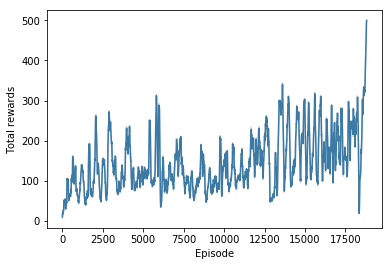

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

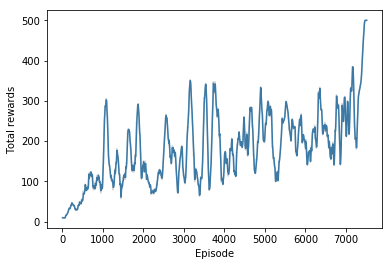

In [29]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

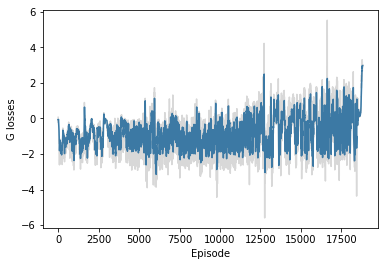

In [29]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

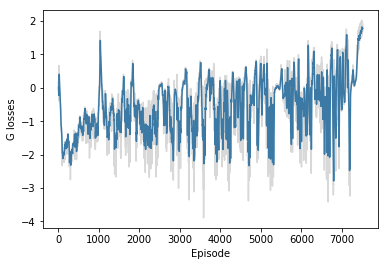

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

Text(0,0.5,'D losses')

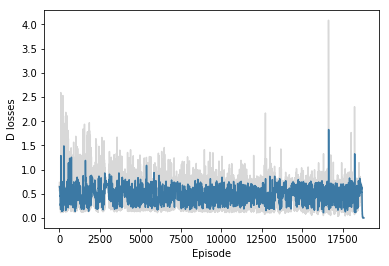

In [30]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

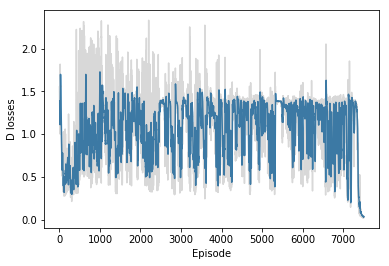

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

Text(0,0.5,'D losses R')

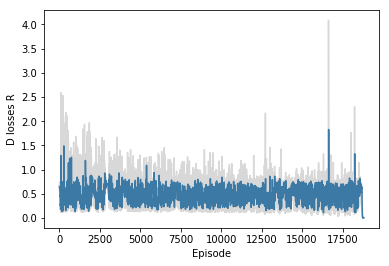

In [31]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

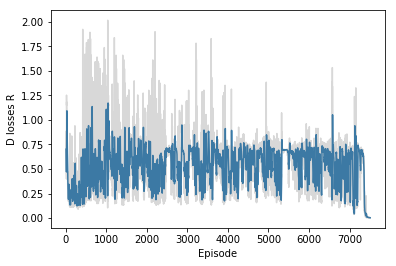

In [32]:
# eps, arr = np.array(d_lossR_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

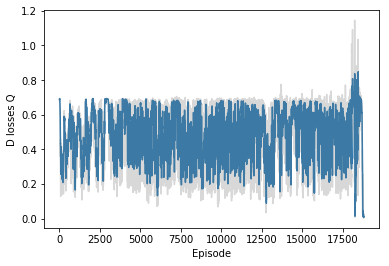

In [32]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

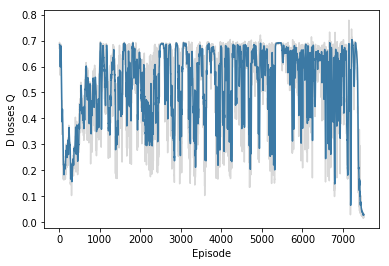

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [ ]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model2.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.